# TCC IA 2019/1 - RFID Prediction
### *Manuel Rodrigues - RA: 191362*
### *Rafael Leme - RA: 122187*

GitHub Repository: [link text](https:// [link text](https://))

# Introdução

## Objetivo

O objetivo deste projeto é desenvolver um sistema de análise de uma série temporal, proveniente de um banco de dados de leituras de sinal de antenas RFID, com a finalidade de prever o momento em que as leituras mudem de comportamento, permitindo assim uma manutenção preditiva dos equipamentos.

## O que é RFID?
RFID (Radio Frequency Identification em inglês) é uma tecnologia de identificação por rádio frequência, amplamente utilizado para realizar a identificação única de objetos por meio de tags, tendo vasta aplicação em diversos meios, como na área de indústria e logística, tornando possível fazer o manejo de produção e estoque, por exemplo.

Amplamente popular, o RFID pode ser implementado em diversos tipos de material, como cartões de identificação, tags para chaveiro e como etiquetas que podem ser colada em emalagens ou diretamente em produtos, sendo estas etiquetas conhecidas popularmente como smart labels (etiquetas inteligentes).

Conforme abaixo, pode-se observar algumas aplicações típicas de RFID.

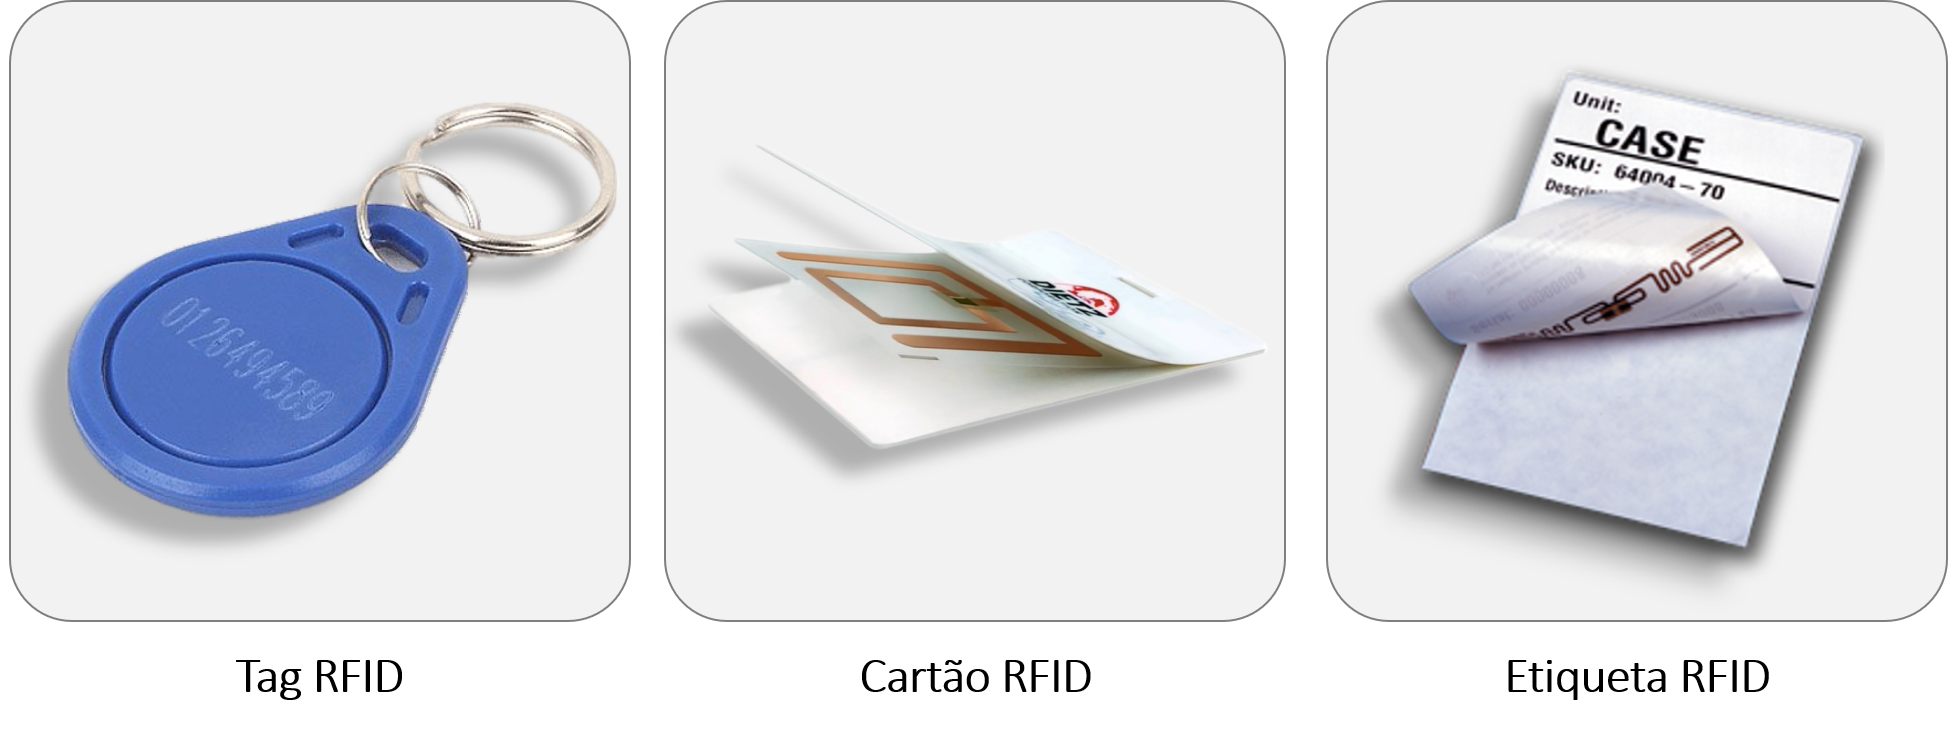

## O sistema RFID
O RFID (Radio Frequency Idenfitication) é composto basicamente por 3 componentes.

**Etiquetas:** também conhecidas popularmente como Tags e tecnicamente como transponder. Elas possuem em sua composição um circuito integrado (microchip) ligado à uma pequena antena. Esse chip possui uma memória onde as características de identificação do produto estarão armazenadas e ela transmite essas informações para o Leitor (Reader) quando solicitado.

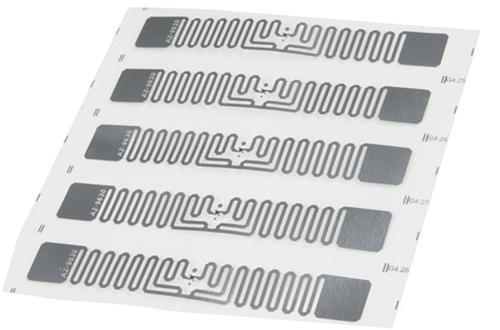


**Leitores (Reader):** é denominado como um sofisticado equipamento de rádio que possui em suas principais características a criação, ampliação e envios dos sinais de radiofrequência, receber os sinais das etiquetas e de-modular a informação e organizar os dados recebidos a fim de enviá-los para um computador.
Uma outra característica dos leitores é de fazer escrita ou gravação de informação nas etiquetas. Abaixo um exemplo de um leitor de RFID.

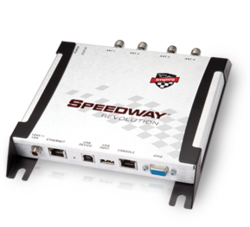

**Antenas:** elas são os condutores da comunicação de dados entre as etiquetas e o leitor. Existem vários tipos de antenas e, devido a isso, é muito importante conhecê-las, pois dependendo da sua aplicação o tipo da antena influenciará muito na performance de leitura. Outro fator importante é o posicionamento da mesma, pois ele impacta na força de retorno de sinal de leitura, o que chamaremos mais adiante de **RSSI**.

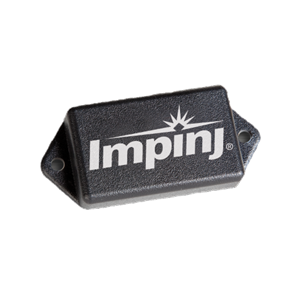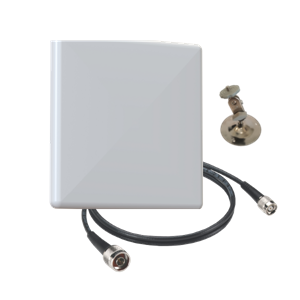

O **RSSI (Received Signal Strength Indicator)** é na prática um valor que indica a força do sinal de resposta. É usado para estimar a distância entre uma etiqueta e a antena ou simplesmente para restringir a leitura em uma determinada distância. Em algumas aplicações ele pode ser usado para identificar a direção da etiqueta e até mesmo como filtro de validação para criar boas condições de leitura e gravação.

## Caso de estudo
O trabalho desenvolvido se baseia em um log capturado durante um dia de funcionamento em uma linha de produção industrial de embalagens, em uma fábrica na cidade de Sorocaba/SP.
<br>Esta linha de produção utiliza um sistema RFID, com Tags inteligentes, que são coladas nas embalagens produzidas para auxiliar o seu rastreamento ao longo do processo de produção automatizado.
<br>Os dados foram capturados de um leitor RFID ao longo do processo e registra informações como o código único de cada tag chamado EPC, a potência de resposta de leitura da tag (RSSI), o tempo exato de registro de leitura e um status de sucesso na operação de leitura. 
<br>Para cada tag que passa pela antena de leitura sobre a esteira, várias leituras são realizada da mesma tag, sendo que é necessária uma potência de resposta mínima para ser considerara como uma leitura eficaz e válida para o sistema de rastreabilidade.
<br>A potência de retorno do sinal, que é o foco principal do trabalho apresentado, pode ter influência de diversos fatores, como a qualidade em si da tag, a variação de posicionamento e distância da antena, a velocidade da esteira e a configuração do leitor (Reader).

# Desenvolvimento

## Pré-processamento dos dados

Os dados coletados dos equipamentos chamados READERS geram um log onde as informações são descritas conforme abaixo:

- Hora no formato (HH:MM:SS.mmm)
- TAG = Informação do número armazenado na memória da TAG é um identificador único denominado de EPC.
- ANTENNA = Registro da antena que a informação foi capturada.
- RSSI = Informação de retorno de potência.
- TIMESTAMP = Momento em que a informação foi capturada.

É através do parâmetro de RSSI que se pode identificar se a leitura realizada pela antena está boa ou não.

Inicialmente carregaremos o log e iremos fazer um pré-processamento para excluir as linhas que não são referentes às leituras da antena e deixá-lo em um formato mais fácil de se trabalhar.

In [1]:
# Bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=11)

In [2]:
# Abrindo a estrutura de pastas do google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive/TCC


/content/gdrive/My Drive/TCC


### Limpeza e Transformação do Log

Carregamento dos dados, arquivo de log esta separado por vírgula, e seus valores estão com "sujeira" e precisam ser tratados posteriormente

In [4]:
dfTemp = pd.read_csv('Dataset/DeviceReader.txt', names=['EPC', 'ANTENNA', 'RSSI', 'TIMESTAMP'], sep=',')
print ('Linhas: ', dfTemp.shape[0])
dfTemp.head()

Linhas:  2826720


EPC  ...                   TIMESTAMP
0  07:57:47.025;TAG=36343647403A50683162C60B566C1...  ...  TIMESTAMP=1559285819989794
1  07:57:47.025;TAG=36343647403A50683162C60B566C1...  ...  TIMESTAMP=1559285819990783
2  07:57:47.025;TAG=36343647403A50683162C60B566C1...  ...  TIMESTAMP=1559285819991764
3  07:57:47.025;TAG=36343647403A50683162C60B566C1...  ...  TIMESTAMP=1559285819993897
4  07:57:47.025;TAG=36343647403A50683162C60B566C1...  ...  TIMESTAMP=1559285819995780

[5 rows x 4 columns]

In [5]:
dfTemp.tail(5)

EPC  ...  TIMESTAMP
2826715             15:09:10.463;InputChannel  ...        NaN
2826716  15:09:11.493;ClearQueue;InputChannel  ...        NaN
2826717             15:09:11.493;InputChannel  ...        NaN
2826718       15:09:18.918;WriteOutputChannel  ...  Timeout=0
2826719       15:15:09.507;WriteOutputChannel  ...  Timeout=0

[5 rows x 4 columns]

#### 1ª Etapa

A EPC é uma tag de evento de leitura de antena RFID, que registra cada leitura de maneira sequêncial, sendo que cada tag é única.

Para a preparação do banco de dados, a primeira etapa a ser realizada é separar a EPC do restante da string, podendo saber assim a tag de cada leitura.

In [6]:
dfTemp['TIME'], dfTemp['EPC'] = dfTemp['EPC'].str.split(';',1).str
print ('Linhas: ', dfTemp.shape[0])
dfTemp.head(5)

Linhas:  2826720


EPC  ...          TIME
0  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...  07:57:47.025
1  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...  07:57:47.025
2  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...  07:57:47.025
3  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...  07:57:47.025
4  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...  07:57:47.025

[5 rows x 5 columns]

#### 2ª Etapa

No log registrado pelo equipamento, quando uma leitura é validada pelo sistema, uma string é iniciada com "RFIDValidation". O valor da potência de resposta (RSSI) é adotado como o valor da próxima string.

A segunda etapa de preparação do banco de dados é criar uma coluna VALIDATION, sendo que quando houver um valor de potência de resposta adotado (RSSI), o valor de VALIDATION deverá ser 1.

In [7]:
dfTemp['VALIDATION'] = 0
dfTemp.loc[dfTemp['EPC'].str.contains("RFIDValidation"), 'VALIDATION'] = 1
dfTemp['VALIDATION'] = dfTemp['VALIDATION'].shift()
dfTemp.dropna(inplace=True)
print ('Linhas: ', dfTemp.shape[0])
dfTemp.head(40)

Linhas:  2776016


EPC  ... VALIDATION
1   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
2   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
3   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
4   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
5   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
6   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
7   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
8   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
9   TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
10  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
11  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
12  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
13  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
14  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
15  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
16  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
17  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
18  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
19  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
20  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
21  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
22  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
23  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
24  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
25  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
26  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
28  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
29  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
30  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
31                                     RFIDValidation  ...        0.0
32  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        1.0
33  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
34  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
35  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
36  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
37  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
38  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
39  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
40  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
41  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0

[40 rows x 6 columns]

#### 3ª Etapa

A etapa seguinte de preparação do banco de dados consiste e manter apenas os logs que contenham a substring "TAG=", eliminando assim os demais casos

In [8]:
dfTemp = dfTemp[dfTemp['EPC'].str.contains("TAG=")]
print ('Linhas: ', dfTemp.shape[0])
dfTemp.head(5)

Linhas:  2675751


EPC  ... VALIDATION
1  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
2  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
3  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
4  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0
5  TAG=36343647403A50683162C60B566C1B3168DDB326EC...  ...        0.0

[5 rows x 6 columns]

#### 4ª Etapa

Nesta etapa, foram removidos os marcadores específicos de cada coluna, mantendo apenas os respectivos valores.

In [9]:
dfTemp['EPC'] = dfTemp['EPC'].str.replace('TAG=', '')
dfTemp['RSSI'] = dfTemp['RSSI'].str.replace('RSSI=', '')
dfTemp['TIMESTAMP'] = dfTemp['TIMESTAMP'].str.replace('TIMESTAMP=', '')
print ('Linhas: ', dfTemp.shape[0])
dfTemp.head(5)

Linhas:  2675751


EPC  ... VALIDATION
1  36343647403A50683162C60B566C1B3168DDB326EC3400...  ...        0.0
2  36343647403A50683162C60B566C1B3168DDB326EC3400...  ...        0.0
3  36343647403A50683162C60B566C1B3168DDB326EC3400...  ...        0.0
4  36343647403A50683162C60B566C1B3168DDB326EC3400...  ...        0.0
5  36343647403A50683162C60B566C1B3168DDB326EC3400...  ...        0.0

[5 rows x 6 columns]

#### 5ª Etapa

Para melhorar a visualização do banco de dados, um novo dataset foi criado, alterando-se a ordem das colunas e reiniciando os índices de linha, por fim, salvando o dataset gerado.
Finalizando o primeiro processo de transformação vou salvar os dados em um novo dataset corrigindo a ordem das colunas para uma melhor visualização, excluindo as que não serão necessárias e atualizando os tipos das colunas para melhor trabalhar com os dados posteriormente. E por fim será feito um reset no index.

In [10]:
df = dfTemp[['TIMESTAMP','EPC','RSSI','VALIDATION']]
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2675751 entries, 1 to 2826712
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   TIMESTAMP   object 
 1   EPC         object 
 2   RSSI        object 
 3   VALIDATION  float64
dtypes: float64(1), object(3)
memory usage: 102.1+ MB
None


TIMESTAMP  ... VALIDATION
1  1559285819990783  ...        0.0
2  1559285819991764  ...        0.0
3  1559285819993897  ...        0.0
4  1559285819995780  ...        0.0
5  1559285819997566  ...        0.0

[5 rows x 4 columns]

In [11]:
df['TIMESTAMP'] = pd.to_numeric(df['TIMESTAMP'])
df['RSSI'] = pd.to_numeric(df['RSSI'])
df['VALIDATION'] = df['VALIDATION'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2675751 entries, 1 to 2826712
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   TIMESTAMP   int64 
 1   EPC         object
 2   RSSI        int64 
 3   VALIDATION  int64 
dtypes: int64(3), object(1)
memory usage: 102.1+ MB


In [12]:
df.reset_index(drop=True)
print ('Linhas: ', df.shape[0])
df.head(5)

Linhas:  2675751


TIMESTAMP  ... VALIDATION
1  1559285819990783  ...          0
2  1559285819991764  ...          0
3  1559285819993897  ...          0
4  1559285819995780  ...          0
5  1559285819997566  ...          0

[5 rows x 4 columns]

Salvarei os dados em um novo arquivo para não precisar refazer esses passos novamente.

In [16]:
df.to_csv('Dataset/Output.csv')

### Agrupamento dos Dados

Nessa segunda fase do pré-processamento a idéia é fazer um agrupamento dos dados por EPC e identificar os valores de RSSI máximo (que determina o melhor momento de validação), Mínimo (que identifica o valor da pior leitura), Médio (que determina a média das leituras por EPC), Contagem (para identificar quantas vezes aquele EPC foi capturado pela antena), Valor de Validação (que será o valor do RSSI onde o sistema considerou como item válido) e o Timestamp (valor do momento que a leitura aconteceu).

O timestamp será o índice desse dataset agrupado e será importante dado para o modelo de série temporal que será utilizado para prever as próximas leituras.

Iniciarei com o carregamente do Dataset.

In [17]:
df = pd.read_csv('Dataset/Output.csv', index_col=0)
print ("Tamanho Original (Linhas x Colunas): ", df.shape)
df.head()

Tamanho Original (Linhas x Colunas):  (2675751, 4)


TIMESTAMP  ... VALIDATION
1  1559285819990783  ...          0
2  1559285819991764  ...          0
3  1559285819993897  ...          0
4  1559285819995780  ...          0
5  1559285819997566  ...          0

[5 rows x 4 columns]

#### 1ª Etapa

Para facilitar a captura dos valores que precisarei vou atualizar o valor do Campo VALIDATION com o valor do RSSI correspondente.
Com isso conseguirei pegar qual foi o RSSI no momento da validação.

In [18]:
df['VALIDATION'] = df.RSSI[df['VALIDATION']==1]

#### 2ª Etapa

O agrupamento pelo EPC pegando os valores MIN, MAX, MEAN e COUNT.

O valor MIN é importante pois representa para aquele EPC qual foi a pior leitura dentre todas as leituras feitas. Como a leitura é feita em movimento, os EPCs terão uma leitura ruim enquanto estiver afastado da antena.

O valor MAX representa o ponto de melhor leitura do EPC, ou seja, o ponto onde ele esta posicionado bem acima da antena. Esse normalmente é a melhor posição para validação de leitura e é através dele que se estipula o valor limite para validação do sistema que controla essas leituras e considera a TAG como boa ou ruim.

O valor MEAN (média) é o valor médio entre as leituras feitas para cada EPC em relação a quantidade de leituras feitas.

O COUNT representa quantas leituras a antena recebeu da TAG. Ele servirá de filtro para remoção de outliers. Por exemplo, as vezes, a máquina pode parar por problema mecânico e nesse caso a antena fará muitas leituras das TAGs que estiverem próximas. Mas como a máquina esta parada, essas leituras não são válidas para analise e estudo do comportamento e previsão.

Será criado um novo dataset temporário contemplando esse agrupamento.

In [19]:
df1 = df.groupby(['EPC'])['RSSI'].agg(['min','max','mean','count'])
print (df1.shape)
df1.head()

(49655, 4)


min  max       mean  count
EPC                                                                           
363435FB10606B283162C60B568C1BB162DE0B26B0F4000...  -53  -37 -43.767857     56
363435FB10606B283162C60B568C1BB162DE0B26B134000...  -52  -36 -41.458333     48
363435FB10606B283162C60B568C1BB162DE0B26B174000...  -46  -35 -37.360000     25
363435FB10606B283162C60B568C1BB162DE0B26B1B4000...  -53  -36 -42.895833     48
363435FB10606B283162C60B568C1BB162DE0B26CC34000...  -56  -36 -43.327273     55

#### 3ª Etapa

Foi escolhido como data (timestamp) o tempo da primeira leitura recebida pela antena de cada EPC. E um novo dataset será criado contendo essa informação.

In [20]:
df2 = df.groupby(['EPC'])['TIMESTAMP'].min()
print (df2.shape)
df2.head()

(49655,)


EPC
363435FB10606B283162C60B568C1BB162DE0B26B0F400000000    1559288006669161
363435FB10606B283162C60B568C1BB162DE0B26B13400000000    1559288006411266
363435FB10606B283162C60B568C1BB162DE0B26B17400000000    1559288006208139
363435FB10606B283162C60B568C1BB162DE0B26B1B400000000    1559288005894531
363435FB10606B283162C60B568C1BB162DE0B26CC3400000000    1559288005639682
Name: TIMESTAMP, dtype: int64

#### 4ª Etapa

Para cada EPC foi salvo o valor do RSSI do momento que o sistema validou a TAG. Esse valor é importante, pois serve como base de estudo do quão distante do valor MAX (melhot ponto de validação) ele está. Hoje ele é utilizado para ajustes de posicionamento de antena e configuração de filtro de validação.

Quanto mais próximo do valor MAX, mas ideal estará a configuração (setup) da máquina.

Um terceiro dataset temporário foi criado para armazenar essa informação.

In [21]:
df3 = df.groupby(['EPC'])['VALIDATION'].max()
print (df3.shape)
df3.head()

(49655,)


EPC
363435FB10606B283162C60B568C1BB162DE0B26B0F400000000   -38.0
363435FB10606B283162C60B568C1BB162DE0B26B13400000000   -38.0
363435FB10606B283162C60B568C1BB162DE0B26B17400000000   -36.0
363435FB10606B283162C60B568C1BB162DE0B26B1B400000000   -38.0
363435FB10606B283162C60B568C1BB162DE0B26CC3400000000   -38.0
Name: VALIDATION, dtype: float64

#### 5ª Etapa


Por fim, todas essas colunas foram concatenadas, nomes alterados, e definido o Timestamp como indice. Um novo arquivo de saída foi gerado para facilitar nas etapas posteriores.

In [22]:
df_final = pd.concat([df2, df3, df1], axis=1)
print (df_final.shape)
df_final.head()

(49655, 6)


TIMESTAMP  ...  count
EPC                                                                   ...       
363435FB10606B283162C60B568C1BB162DE0B26B0F4000...  1559288006669161  ...     56
363435FB10606B283162C60B568C1BB162DE0B26B134000...  1559288006411266  ...     48
363435FB10606B283162C60B568C1BB162DE0B26B174000...  1559288006208139  ...     25
363435FB10606B283162C60B568C1BB162DE0B26B1B4000...  1559288005894531  ...     48
363435FB10606B283162C60B568C1BB162DE0B26CC34000...  1559288005639682  ...     55

[5 rows x 6 columns]

In [23]:
df_final = df_final.reset_index()
df_final = df_final.set_index(['TIMESTAMP'], drop=True)
df_final = df_final.rename(columns={"min": "MIN", "max": "MAX", "mean":"MEAN", "count":"COUNT"})
df_final.head()

EPC  ...  COUNT
TIMESTAMP                                                            ...       
1559288006669161  363435FB10606B283162C60B568C1BB162DE0B26B0F400...  ...     56
1559288006411266  363435FB10606B283162C60B568C1BB162DE0B26B13400...  ...     48
1559288006208139  363435FB10606B283162C60B568C1BB162DE0B26B17400...  ...     25
1559288005894531  363435FB10606B283162C60B568C1BB162DE0B26B1B400...  ...     48
1559288005639682  363435FB10606B283162C60B568C1BB162DE0B26CC3400...  ...     55

[5 rows x 6 columns]

In [24]:
df_final.to_csv('Dataset/GroupOutput.csv')

### Análise para Remoção de Outliers

Agora, faremos algumas análises no dataset resultante para definir a melhor estratégia de separação dos dados e remoção de outliers.

Iniciando pelo carregamento dos dados salvos.

In [25]:
df_final = pd.read_csv('Dataset/GroupOutput.csv', index_col=0)
df_final.head(5)

EPC  ...  COUNT
TIMESTAMP                                                            ...       
1559288006669161  363435FB10606B283162C60B568C1BB162DE0B26B0F400...  ...     56
1559288006411266  363435FB10606B283162C60B568C1BB162DE0B26B13400...  ...     48
1559288006208139  363435FB10606B283162C60B568C1BB162DE0B26B17400...  ...     25
1559288005894531  363435FB10606B283162C60B568C1BB162DE0B26B1B400...  ...     48
1559288005639682  363435FB10606B283162C60B568C1BB162DE0B26CC3400...  ...     55

[5 rows x 6 columns]

In [26]:
df_final = df_final.reset_index()
df_final.head()

TIMESTAMP  ... COUNT
0  1559288006669161  ...    56
1  1559288006411266  ...    48
2  1559288006208139  ...    25
3  1559288005894531  ...    48
4  1559288005639682  ...    55

[5 rows x 7 columns]

Observando a análise estatística dos dados abaixo, nele demonstra que existem itens (EPCs) que fizeram uma quantidade muito grande de leituras, muito acima da média que é de 53.8 leituras. Isso se caracteriza por momentos que talvez a máquina ficou parada com a TAG posicionada em cima da antena e ela ficou capturando valores da mesma TAG.

In [27]:
df_final.describe()

TIMESTAMP    VALIDATION  ...          MEAN         COUNT
count  4.965500e+04  49648.000000  ...  49655.000000  49655.000000
mean   1.559298e+15    -37.765469  ...    -43.250267     53.886839
std    7.974881e+09      0.668383  ...      1.510433     37.868983
min    1.559286e+15    -58.000000  ...    -52.210417      4.000000
25%    1.559292e+15    -38.000000  ...    -44.145161     50.000000
50%    1.559297e+15    -38.000000  ...    -43.491525     54.000000
75%    1.559306e+15    -37.000000  ...    -42.654545     58.000000
max    1.559312e+15    -31.000000  ...    -29.708333   2711.000000

[8 rows x 6 columns]

A estratégia utilizada para remoção desses itens é manter no dataset apenas os itens cuja contagem for menor ou igual a 60. Esse valor foi escolhido, pois a maior parte dos dados se encontram próximos a esse valor o que demonstra que é um bom parâmetro de leitura da antena.

In [28]:
df_filtered = df_final[(df_final['COUNT']<=60)]
print ("Tamanho Final (Linhas x Colunas): ", df_filtered.shape)

df_filtered.dropna(inplace=True)

Tamanho Final (Linhas x Colunas):  (44482, 7)


O novo resultado estatístico do dataset demonstrado abaixo, mostra que os dados agrupados de cada item tem um padrão coerente com os valores coletados da antena para cada item.

Propositalmente foi decidido manter os itens com contagem baixa, como exemplo o item cujo minimo foi 4. Isso porque ao analisar o log, tratava-se de um item que foi aprovado pelo sistema. Esse tipo de comportamente é comum acontecer, apesar de fugir de um padrão de comportamento de leituras boas.

In [29]:
df_filtered.describe()

TIMESTAMP    VALIDATION  ...          MEAN         COUNT
count  4.447500e+04  44475.000000  ...  44475.000000  44475.000000
mean   1.559298e+15    -37.777560  ...    -43.125173     51.527847
std    7.918640e+09      0.654278  ...      1.516709      7.354241
min    1.559286e+15    -42.000000  ...    -47.228070      4.000000
25%    1.559292e+15    -38.000000  ...    -44.018519     49.000000
50%    1.559297e+15    -38.000000  ...    -43.381818     53.000000
75%    1.559306e+15    -37.000000  ...    -42.527525     57.000000
max    1.559312e+15    -31.000000  ...    -29.708333     60.000000

[8 rows x 6 columns]

## Testes Estatísticos - Sérias Estacionárias

### Plot do Gráfico

In [30]:
import matplotlib.pyplot as plt

Foi escolhido apenas uma fatia de 200 itens do dataset para melhor visualizar a série.

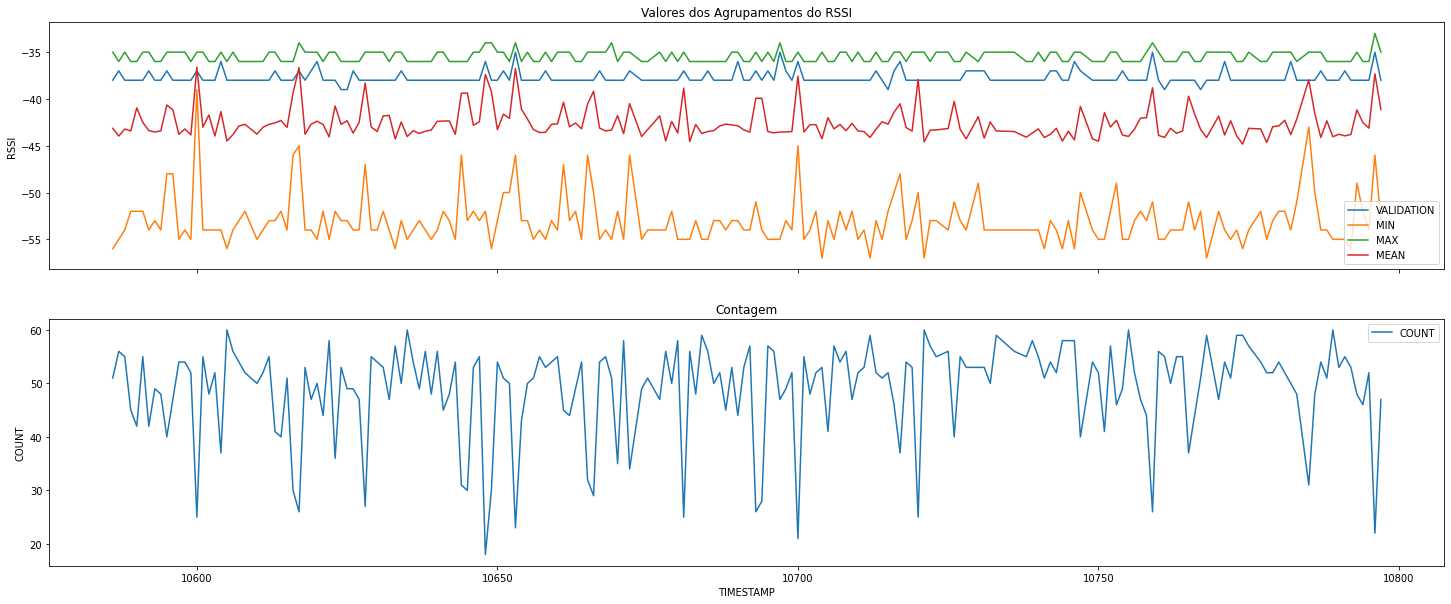

In [31]:
plt.figure(figsize=(25,10))

ax1 = plt.subplot(211)
plt.plot(df_filtered.iloc[10000:10200, 2:6])
plt.ylabel('RSSI')
plt.title('Valores dos Agrupamentos do RSSI')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend(df_filtered.columns[2:6])

ax2 = plt.subplot(212)
plt.plot(df_filtered.iloc[10000:10200, 6:7])
plt.ylabel('COUNT')
plt.xlabel('TIMESTAMP')
plt.title('Contagem')
plt.legend(df_filtered.columns[6:7])

plt.show()

### Decomposição da Série Temporal

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### *VALIDATION, MIN, MAX, MEAN*

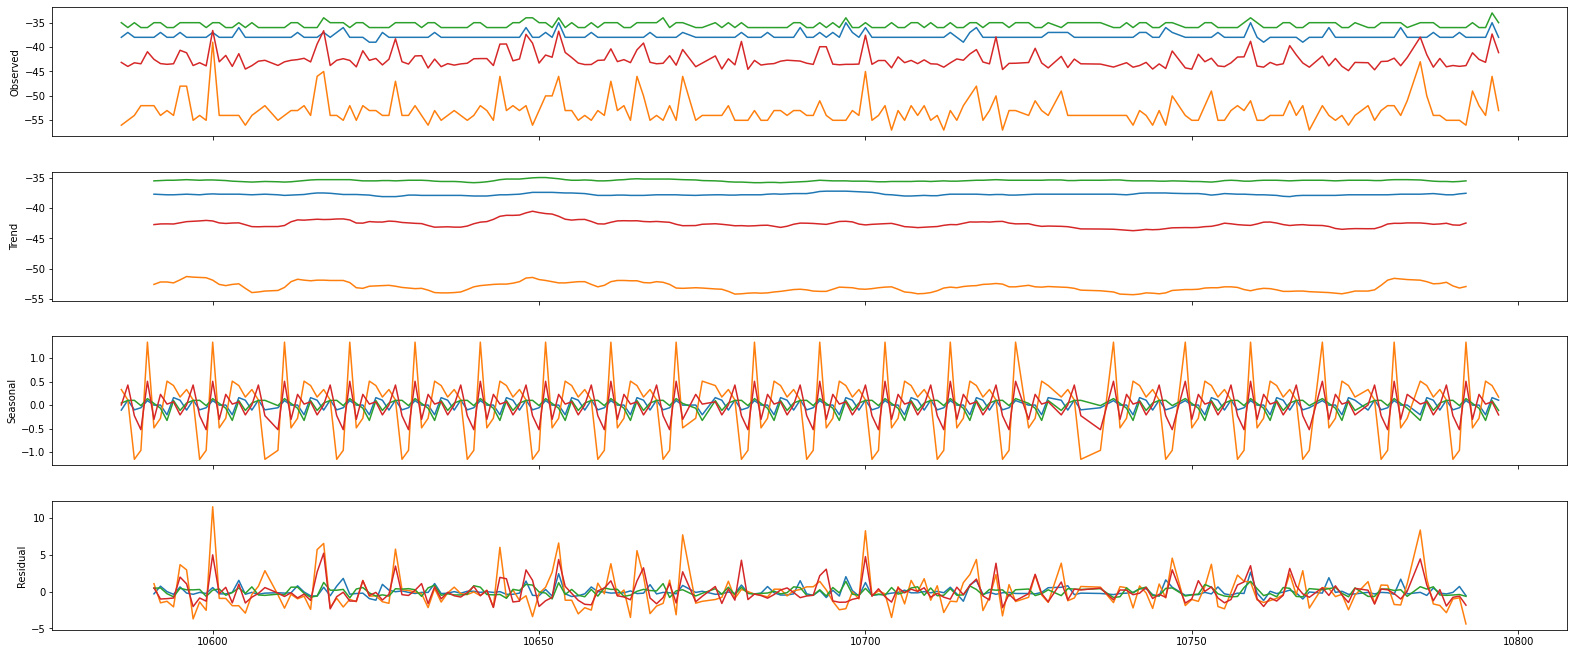

In [33]:
temp = seasonal_decompose(df_filtered.iloc[10000:10200, 2:6], model='additive', freq=10)
fig = temp.plot()
fig.set_size_inches(25,10)

#### *COUNT*

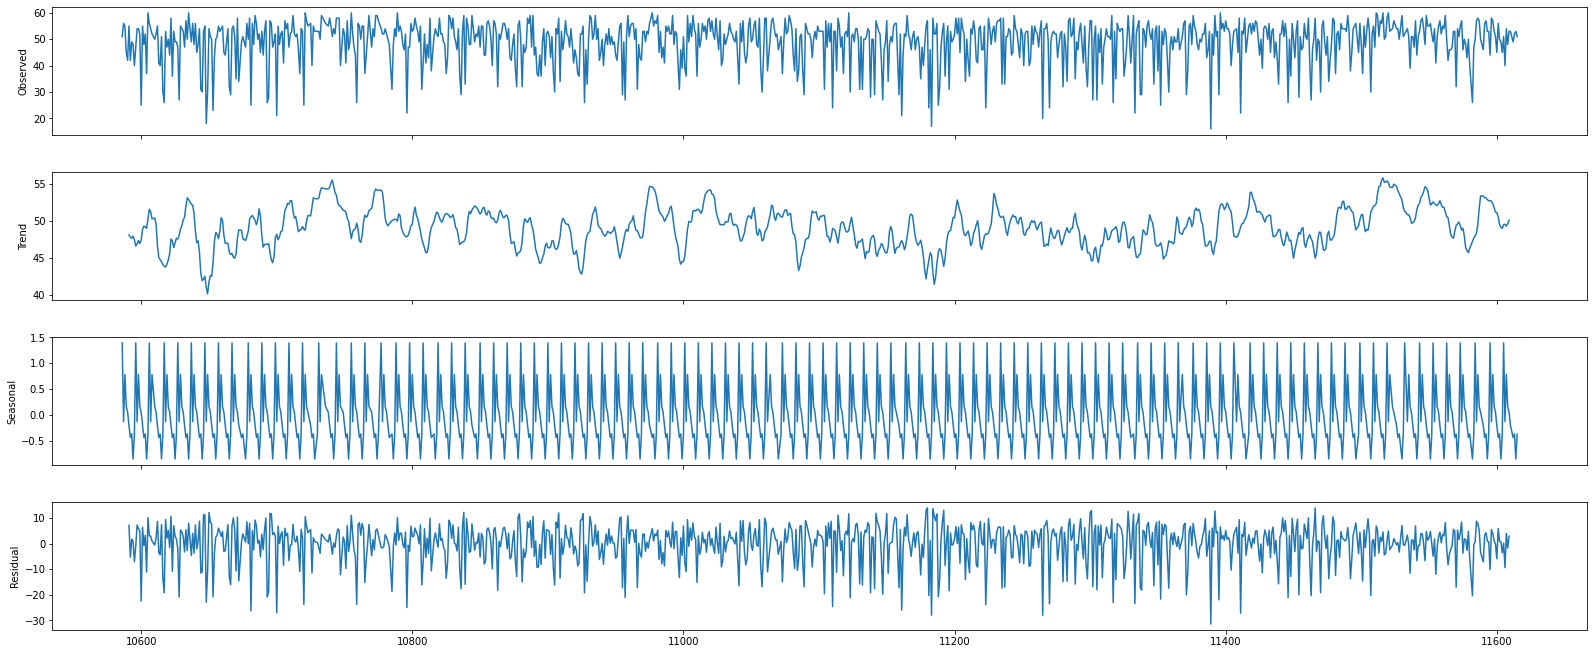

In [34]:
temp = seasonal_decompose(df_filtered.iloc[10000:11000, 6:7], model='additive',freq=10)
fig = temp.plot()
fig.set_size_inches(25,10)

Observando os dados acima, percebemos que os valores mantem uma tendência estável sem viés de alta ou baixa, para um processo produtivo isso é um sinal muito bom, pois demonstra uma estabilidade das leituras.

Sua sazonalidade é mínima variando apenas 1 ponto para quase todos os campos. Confirmando assim a estabilidade das leituras.

### Teste Estatístico Móveis (Média e Desvio Padrão)

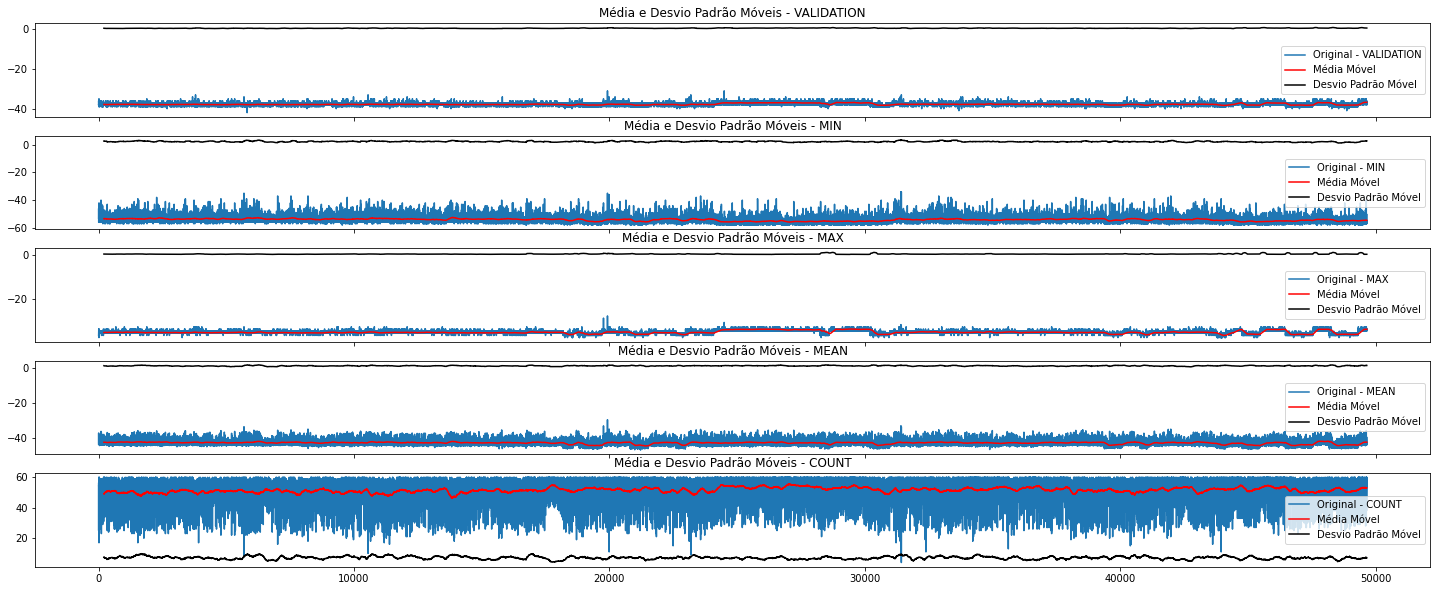

In [35]:
timeseries = df_filtered[['VALIDATION','MIN','MAX','MEAN','COUNT']].copy()

rollingmean = timeseries.rolling(window=200).mean()
rollingstd = timeseries.rolling(window=200).std()

rollingmean.dropna(inplace=True)
rollingstd.dropna(inplace=True)

plt.figure(figsize=(25,10))

for ix, col in enumerate(timeseries.columns):

  ax = plt.subplot(5,1,ix+1)

  plt.plot(timeseries[col], label='Original - ' + col)
  plt.plot(rollingmean[col], color='red', label='Média Móvel')
  plt.plot(rollingstd[col], color='black', label = 'Desvio Padrão Móvel')
  plt.legend(loc='best')
  plt.title('Média e Desvio Padrão Móveis - '+ col)
  plt.tick_params(labelbottom=False)    

plt.tick_params(labelbottom=True)  
plt.show(block=False)

Através dessa técnica podemos assumir visualmente que a série é estacionária pois sua média e desvio padrão se mantiveram praticamente constantes. Outro método que faremos a seguir é o teste estatístico de Dicky-Fuller.

### Teste Estatístico Dickey-Fuller

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
for ix, col in enumerate(timeseries.columns):
  print ('\nResultados do Teste Dickey-Fuller (%s)' % col)

  dftest = adfuller(timeseries[col], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Teste Estatístico','P-value','#Lags Usados','Num Observações'])

  for key, value in dftest[4].items():
      dfoutput['Valores Críticos (%s)' % key] = value
  
  print (dfoutput)


Resultados do Teste Dickey-Fuller (VALIDATION)
Teste Estatístico        -8.487488e+00
P-value                   1.341025e-13
#Lags Usados              5.400000e+01
Num Observações           4.442000e+04
Valores Críticos (1%)    -3.430497e+00
Valores Críticos (5%)    -2.861605e+00
Valores Críticos (10%)   -2.566805e+00
dtype: float64

Resultados do Teste Dickey-Fuller (MIN)
Teste Estatístico        -1.034742e+01
P-value                   2.589086e-18
#Lags Usados              5.500000e+01
Num Observações           4.441900e+04
Valores Críticos (1%)    -3.430497e+00
Valores Críticos (5%)    -2.861605e+00
Valores Críticos (10%)   -2.566805e+00
dtype: float64

Resultados do Teste Dickey-Fuller (MAX)
Teste Estatístico        -7.450805e+00
P-value                   5.677401e-11
#Lags Usados              5.200000e+01
Num Observações           4.442200e+04
Valores Críticos (1%)    -3.430497e+00
Valores Críticos (5%)    -2.861605e+00
Valores Críticos (10%)   -2.566805e+00
dtype: float64

Resul

Os testes estatísticos de DF confirmam que a série é estacionária. Pois o Teste Estatístico foi menor que os valores críticos rejeitando a hipótese nula do teste de DF (Ho = Não Estacionária).

Devido a isso nenhuma transformação será necessária na série.

In [38]:
df_filtered.to_csv('Dataset/FinalOutput.csv')

## Modelos

A ideia será utlizar o Dataset resultante para treinar um modelo onde como entrada usaremos uma abordagem Multivariada com os valores do passado dos campos VALIDATION, MIN, MAX, MEAN e COUNT para prever os valores futuros do VALIDATION.

Também faremos uma abordagem Univariada com os valores do passado do campo VALIDATION para prever os valores futuros do próprio VALIDATION.

Com isso foi escolhido 2 modelos LSTM (Long-Short Term Memory) do Keras e o Prophet do Facebook. Ambos modelos muito utilizados em problemas de séries temporais.

Optamos por escolher o modelo LSTM, abordado em aula, com o intuito de explorar seu uso e suas variações, expandindo assim o conhecimento aprendido em aula. Nos proximos tópicos faremos algumas abortagens nesse modelo com o uso de atributos Multivariado e Univariado. E também iremos usar uma abordagem para prever mais de um resultado (Multi-Step).

Escolhemos outro modelo, não apresentado em aula, para explorar outras opções de modelos de Machine Learning e compará-lo com o primeiro modelo escolhido. Decidimos usar o Prophet do Facebook, pois é um modelo que tem sido considerado muito bom para problemas de séries temporais.

###LSTM (Long-Short Term Memory)

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

####Preparação dos Dados:

A primeira etapa será transformar o dataset atual em um dataset característico de um problema de aprendizado supervisionado, onde dado os valores X(t-1) (VALIDATION, MIN, MAX, MEAN e COUNT), ele deverá prever o valor de y (t) (VALIDATION). Ou dado o período X(t), ele deverá prever o valor de y(t+1)...y(t+n). Onde (t) é o periodo presente, (t-1) é o período passado e (t+n) é o período futuro.

Para isso será utilizado uma função que faz essa transformação com a intenção de ter uma flexibilidade da escolha dos períodos.

In [41]:
#Função para conversão de um dataset em formato para aprendizado supervisionado. Trecho tirado do artigo abaixo:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Carregamento do dataset e pegando apenas os seus valores:

In [42]:
df_LSTM = pd.read_csv('Dataset/FinalOutput.csv', index_col=0)
df_LSTM = df_LSTM.drop(['TIMESTAMP','EPC'], axis=1)
dfValues = df_LSTM.values
dfValues = dfValues.astype('float32')
dfValues

array([[-38.      , -53.      , -37.      , -43.767857,  56.      ],
       [-38.      , -52.      , -36.      , -41.458332,  48.      ],
       [-36.      , -46.      , -35.      , -37.36    ,  25.      ],
       ...,
       [-37.      , -55.      , -34.      , -43.407406,  54.      ],
       [-38.      , -57.      , -34.      , -44.2     ,  60.      ],
       [-38.      , -55.      , -34.      , -43.07143 ,  56.      ]],
      dtype=float32)

Inicialmente faremos a transformação da série apenas para mostrar o funcionamento da função com 1 período.

In [43]:
dfNovo = series_to_supervised(dfValues, n_in=1, n_out=1, dropnan=True)
dfNovo.head()

var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t)    var4(t)  var5(t)
1      -38.0      -53.0      -37.0  ...    -36.0 -41.458332     48.0
2      -38.0      -52.0      -36.0  ...    -35.0 -37.360001     25.0
3      -36.0      -46.0      -35.0  ...    -36.0 -42.895832     48.0
4      -38.0      -53.0      -36.0  ...    -36.0 -43.327274     55.0
5      -38.0      -56.0      -36.0  ...    -36.0 -43.559322     59.0

[5 rows x 10 columns]

Abaixo a transformação escolhida será para atender o que chamamos de método Multivariating - Multi-Step forecast, na realidade é a junção de 2 métodos que encontramos na literatura e exemplos do LSTM.

**Multivariating** significa que utilizaremos mais de 1 característica com entrada para treinar o modelo.

**Multi-Step** significa que iremos, através de um período passado prever 10 períodos futuros.
Como o objetivo é prever o valor do campo VALIDATION aqui representado pela (var1) não precisaremos dos outros atributos e por isso vamos removê-lo desse resultado.

In [44]:
dfNovo10 = series_to_supervised(dfValues, n_in=30, n_out=10, dropnan=True)

dropList = list()
for i in range(0, 10, 1):
  if i==0:
    dropList.append('var2(t)')
    dropList.append('var3(t)')
    dropList.append('var4(t)')
    dropList.append('var5(t)')
  else:
    dropList.append('var2(t+'+str(i)+')')
    dropList.append('var3(t+'+str(i)+')')
    dropList.append('var4(t+'+str(i)+')')
    dropList.append('var5(t+'+str(i)+')')
    
dfNovo10.drop(dropList, axis=1, inplace=True)
dfNovo10.head()

var1(t-30)  var2(t-30)  var3(t-30)  ...  var1(t+7)  var1(t+8)  var1(t+9)
30       -38.0       -53.0       -37.0  ...      -37.0      -38.0      -38.0
31       -38.0       -52.0       -36.0  ...      -38.0      -38.0      -39.0
32       -36.0       -46.0       -35.0  ...      -38.0      -39.0      -37.0
33       -38.0       -53.0       -36.0  ...      -39.0      -37.0      -37.0
34       -38.0       -56.0       -36.0  ...      -37.0      -37.0      -38.0

[5 rows x 160 columns]

#### Separação dos dados em treino e teste

Para separação entre treino e teste, deixaremos 80% dos dados para treino e 20% para teste.

In [45]:
dfNovo10.head(5)

var1(t-30)  var2(t-30)  var3(t-30)  ...  var1(t+7)  var1(t+8)  var1(t+9)
30       -38.0       -53.0       -37.0  ...      -37.0      -38.0      -38.0
31       -38.0       -52.0       -36.0  ...      -38.0      -38.0      -39.0
32       -36.0       -46.0       -35.0  ...      -38.0      -39.0      -37.0
33       -38.0       -53.0       -36.0  ...      -39.0      -37.0      -37.0
34       -38.0       -56.0       -36.0  ...      -37.0      -37.0      -38.0

[5 rows x 160 columns]

Os 5 primeiros atributos dos 30 periodos passados serão salvos em X. E as 10 próximas colunas que representam nossa Classe serão salvos em y.

In [46]:
X = np.array(dfNovo10)[:, :(30*5)]
print ('Atributos (%d x %d):' % (X.shape[0],X.shape[1]))
print (X)
y = np.array(dfNovo10)[:,(30*5):]
print ('Classe (%d x %d):' % (y.shape[0],y.shape[1]))
print (y)

Atributos (44436 x 150):
[[-38.       -53.       -37.       ... -36.       -43.48077   52.      ]
 [-38.       -52.       -36.       ... -36.       -43.654545  55.      ]
 [-36.       -46.       -35.       ... -35.       -42.865383  52.      ]
 ...
 [-38.       -57.       -34.       ... -34.       -43.21818   55.      ]
 [-36.       -56.       -34.       ... -34.       -43.929825  57.      ]
 [-37.       -49.       -34.       ... -34.       -43.333332  57.      ]]
Classe (44436 x 10):
[[-38. -38. -38. ... -37. -38. -38.]
 [-38. -38. -37. ... -38. -38. -39.]
 [-38. -37. -38. ... -38. -39. -37.]
 ...
 [-37. -37. -37. ... -36. -37. -37.]
 [-37. -37. -37. ... -37. -37. -38.]
 [-37. -37. -38. ... -37. -38. -38.]]


Aplicaremos a normalização dos dados usando o MinMaxScaler para cada X e y para melhorar a performance do treinamento e trazer todos os atributos para a mesma base.

In [47]:
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
X_N = scalerX.fit_transform(X)
y_N = scalerY.fit_transform(y)

print('Tamanho do Dataset: ', X_N.shape[0])
print('Quantidade de Períodos (Atributos): ', X_N.shape[1])
print('Quantidade de Períodos (Classe): ', y_N.shape[1])

Tamanho do Dataset:  44436
Quantidade de Períodos (Atributos):  150
Quantidade de Períodos (Classe):  10


Faremos a separação entre os atributos e classes para ambos os arrays (treino e teste) usando a biblioteca do sklearn.

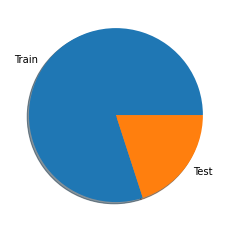

Atributos - Train:  (35548, 150)
Atributos - Test: (8888, 150)
Classes - Train:  (35548, 10)
Classes - Test: (8888, 10)


In [48]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X_N, y_N, test_size=0.2, shuffle=False, random_state=100)

plt.pie([X_Train.shape[0],X_Test.shape[0]], labels=['Train','Test'], shadow=True)
plt.show()

print('Atributos - Train: ', X_Train.shape)
print('Atributos - Test:', X_Test.shape)

print('Classes - Train: ', y_Train.shape)
print('Classes - Test:', y_Test.shape)

Precisaremos acerter a dimensão dos arrays pois o LSMT espera um que seja um array 3D (samples, timesteps, attributes). Nesse caso utilizaremos (Shape[0], 30, 5) onde o valor 30 é devido à 30 periodos e o valor 5 é referente aos 5 atributos que a série possui.

In [49]:
X_Train = X_Train.reshape((X_Train.shape[0], 30, 5))
X_Test = X_Test.reshape((X_Test.shape[0], 30, 5))

print (X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape)

(35548, 30, 5) (8888, 30, 5) (35548, 10) (8888, 10)


In [50]:
X_Train[0]

array([[0.3636365 , 0.20833325, 0.0999999 , 0.1975038 , 0.9285714 ],
       [0.3636365 , 0.25      , 0.19999981, 0.32932782, 0.7857143 ],
       [0.5454545 , 0.5       , 0.29999995, 0.5632546 , 0.37500003],
       ...,
       [0.3636365 , 0.16666675, 0.29999995, 0.33603024, 0.71428573],
       [0.3636365 , 0.25      , 0.19999981, 0.23237824, 0.83928573],
       [0.3636365 , 0.125     , 0.19999981, 0.21389031, 0.85714287]],
      dtype=float32)

#### Arquitetura do Modelo e Treino

In [51]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

Foi criado essa função para facilitar na análise dos parametros do modelo, onde foram testadas várias arquiteturas e a que melhor apresentou resultados foi a arquitetura abaixo.

In [52]:
def fitModel (X_Train, y_Train, X_Test, y_Test, input, batch, epochs):
  model = Sequential()
  model.add(LSTM(input, input_shape=(X_Train.shape[1], X_Train.shape[2])))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(X_Train, y_Train, epochs=epochs, batch_size=batch, validation_data=(X_Test, y_Test), verbose=1, shuffle=False)
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  return history, model

Criamos um gridSearch manual no qual ele treina o modelo para cada parametro estipulado. Sua entrada é a quantidade de loops que cada FOR vai executar. O primeiro é a variação entre os batchs que vai de 2 à 64, crescendo de forma exponencial. A próxima variação é o input da rede que varia da mesma forma e por fim a quantidade de épocas que aumenta de 5 em 5.

In [53]:
def myGridSearch(loopA, loopB, loopC):
  hist = []
  input = 1
  batch = 1

  epochs = 0

  for i in range(loopA):
    epochs = epochs+5
    
    for z in range(loopB):
      input = input*2

      for j in range(loopC):
        batch = batch*2
        print('================FIT Parameters -> epochs: %d -> input: %d -> batch: %d ====================' % (epochs,input,batch))
        hist.append(fitModel(X_Train, y_Train, X_Test, y_Test, input, batch, epochs))

      batch=1

    input=1
    
  return hist

Analizando o resultado abaixo identificamos que o melhor parâmetro foram **Epochs = 15, Input = 64 e Batch = 4** ou **Epoch = 10, Input = 32 e Batch = 2**. Esses dois resultados deram um valor de loss muito parecidos.

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 70s 4ms/step - loss: 0.0287 - val_loss: 0.0421
Epoch 2/5
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0261 - val_loss: 0.0424
Epoch 3/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0421
Epoch 4/5
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0260 - val_loss: 0.0422
Epoch 5/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0422


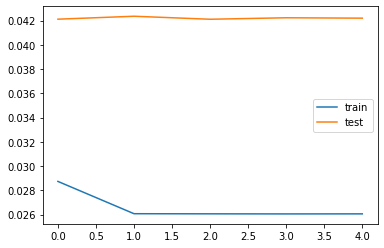

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0311 - val_loss: 0.0421
Epoch 2/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0421
Epoch 3/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0423
Epoch 4/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0421
Epoch 5/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0421


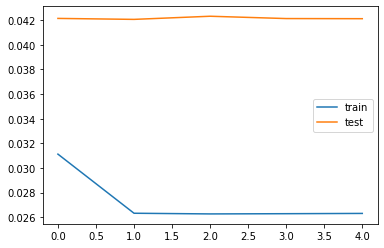

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0311 - val_loss: 0.0422
Epoch 2/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0268 - val_loss: 0.0422
Epoch 3/5
4444/4444 [==============================] - 21s 5ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 4/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 5/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0267 - val_loss: 0.0421


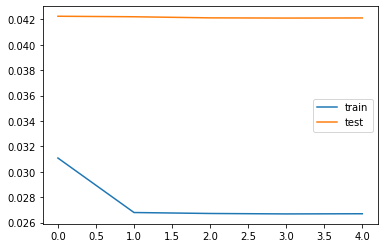

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 11s 5ms/step - loss: 0.0387 - val_loss: 0.0418
Epoch 2/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0275 - val_loss: 0.0419
Epoch 3/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0272 - val_loss: 0.0419
Epoch 4/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0270 - val_loss: 0.0419
Epoch 5/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0270 - val_loss: 0.0419


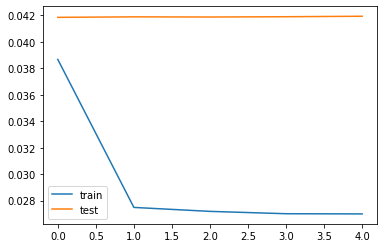

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 6s 5ms/step - loss: 0.0483 - val_loss: 0.0439
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0301 - val_loss: 0.0428
Epoch 3/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0292 - val_loss: 0.0424
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0287 - val_loss: 0.0421
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0284 - val_loss: 0.0420


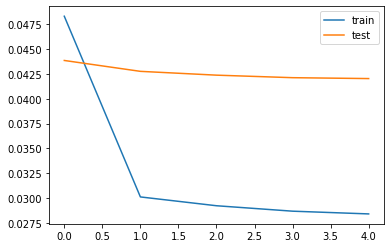

================FIT Parameters -> epochs: 5 -> input: 2 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0808 - val_loss: 0.0431
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0424
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0299 - val_loss: 0.0424
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0424
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0296 - val_loss: 0.0424


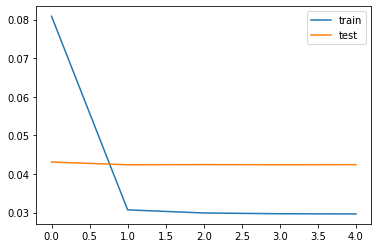

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0280 - val_loss: 0.0426
Epoch 2/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 3/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0262 - val_loss: 0.0426
Epoch 4/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 5/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0423


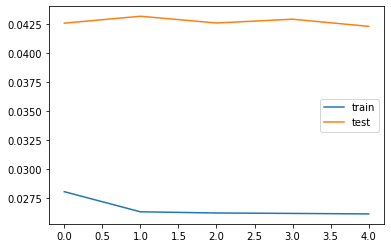

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0296 - val_loss: 0.0425
Epoch 2/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0266 - val_loss: 0.0428
Epoch 3/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0423
Epoch 4/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0425
Epoch 5/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0427


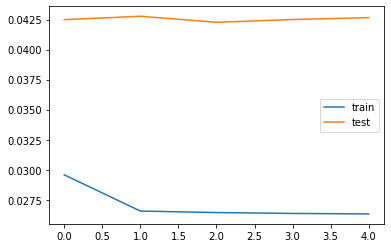

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0363 - val_loss: 0.0420
Epoch 2/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 3/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 4/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0266 - val_loss: 0.0420
Epoch 5/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0266 - val_loss: 0.0421


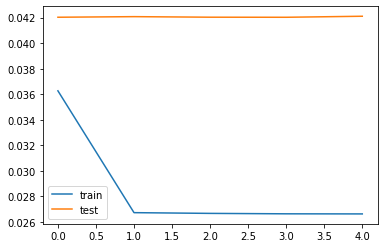

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 11s 5ms/step - loss: 0.0465 - val_loss: 0.0423
Epoch 2/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0276 - val_loss: 0.0423
Epoch 3/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 4/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 5/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0419


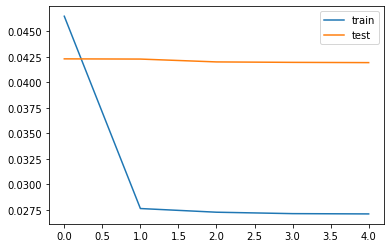

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 6s 5ms/step - loss: 0.0606 - val_loss: 0.0422
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0281 - val_loss: 0.0422
Epoch 3/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0423
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0421


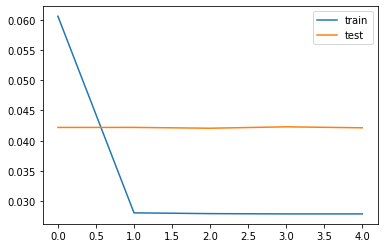

================FIT Parameters -> epochs: 5 -> input: 4 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0835 - val_loss: 0.0442
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0435
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0302 - val_loss: 0.0427
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0299 - val_loss: 0.0425
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0427


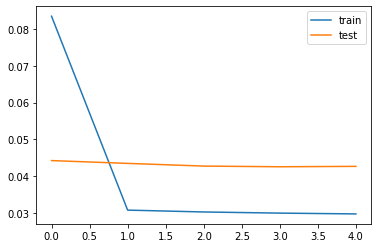

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0277 - val_loss: 0.0430
Epoch 2/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0262 - val_loss: 0.0430
Epoch 3/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0262 - val_loss: 0.0435
Epoch 4/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0263 - val_loss: 0.0428
Epoch 5/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0262 - val_loss: 0.0426


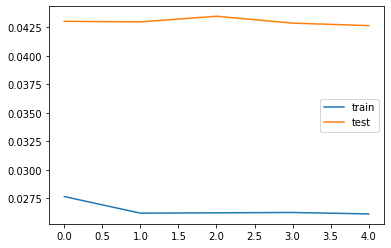

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 35s 4ms/step - loss: 0.0298 - val_loss: 0.0426
Epoch 2/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0425
Epoch 3/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 4/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0423
Epoch 5/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0424


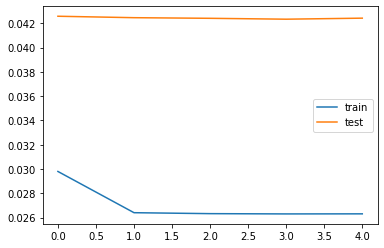

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0335 - val_loss: 0.0421
Epoch 2/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0269 - val_loss: 0.0421
Epoch 3/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 4/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 5/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0421


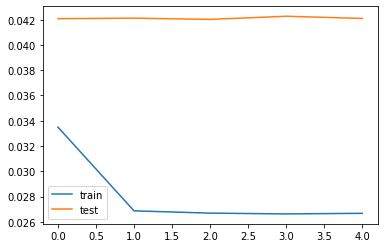

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 2/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0275 - val_loss: 0.0420
Epoch 3/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 4/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 5/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0420


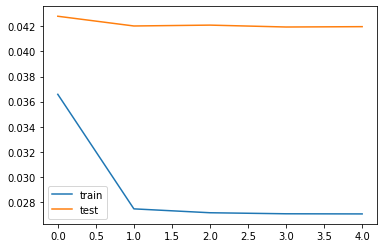

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 6s 5ms/step - loss: 0.0448 - val_loss: 0.0430
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0285 - val_loss: 0.0424
Epoch 3/5
1111/1111 [==============================] - 6s 5ms/step - loss: 0.0282 - val_loss: 0.0421
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0281 - val_loss: 0.0421
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0280 - val_loss: 0.0420


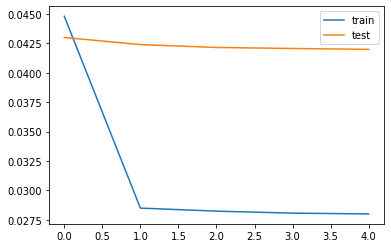

================FIT Parameters -> epochs: 5 -> input: 8 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.1027 - val_loss: 0.0424
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0305 - val_loss: 0.0422
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0301 - val_loss: 0.0420
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0300 - val_loss: 0.0420
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0299 - val_loss: 0.0419


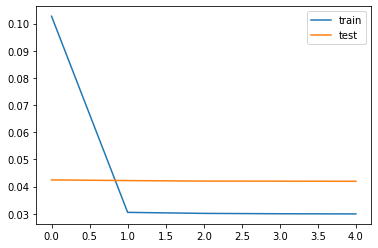

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0285 - val_loss: 0.0436
Epoch 2/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0265 - val_loss: 0.0437
Epoch 3/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 4/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0262 - val_loss: 0.0439
Epoch 5/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0262 - val_loss: 0.0438


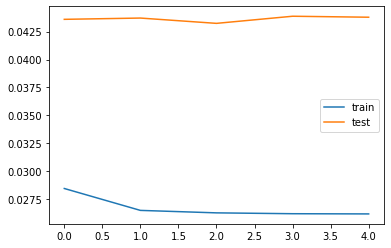

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0286 - val_loss: 0.0429
Epoch 2/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0268 - val_loss: 0.0430
Epoch 3/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0266 - val_loss: 0.0429
Epoch 4/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 5/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0265 - val_loss: 0.0425


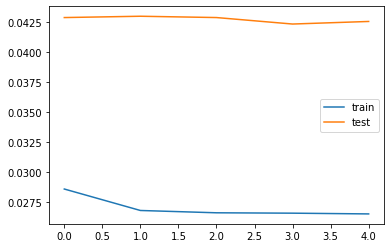

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0331 - val_loss: 0.0423
Epoch 2/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0422
Epoch 3/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0424
Epoch 4/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 5/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0267 - val_loss: 0.0421


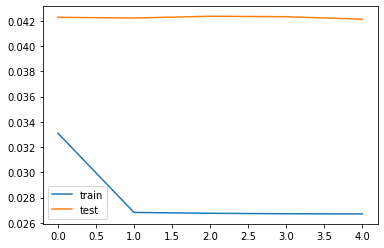

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0403 - val_loss: 0.0419
Epoch 2/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 3/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 4/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 5/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0420


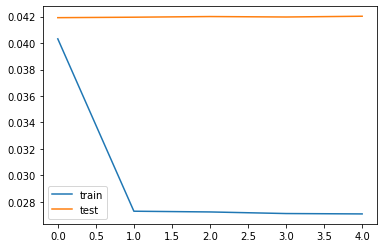

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0527 - val_loss: 0.0424
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0280 - val_loss: 0.0422
Epoch 3/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0424
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 0.0422
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 0.0422


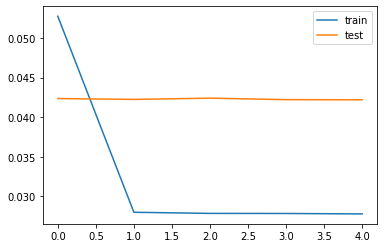

================FIT Parameters -> epochs: 5 -> input: 16 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0635 - val_loss: 0.0438
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0433
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0294 - val_loss: 0.0419
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0296 - val_loss: 0.0429
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0296 - val_loss: 0.0426


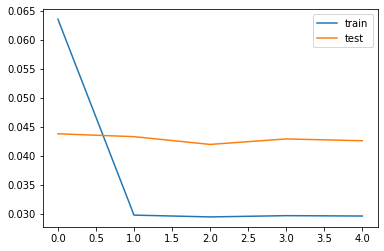

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0281 - val_loss: 0.0427
Epoch 2/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0262 - val_loss: 0.0435
Epoch 3/5
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0261 - val_loss: 0.0437
Epoch 4/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 5/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0430


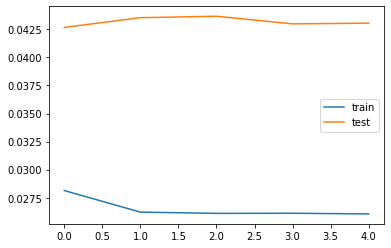

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0293 - val_loss: 0.0427
Epoch 2/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0266 - val_loss: 0.0425
Epoch 3/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0265 - val_loss: 0.0433
Epoch 4/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0438
Epoch 5/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0438


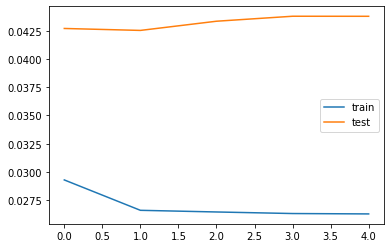

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0372 - val_loss: 0.0421
Epoch 2/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0268 - val_loss: 0.0421
Epoch 3/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 4/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0266 - val_loss: 0.0420
Epoch 5/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0421


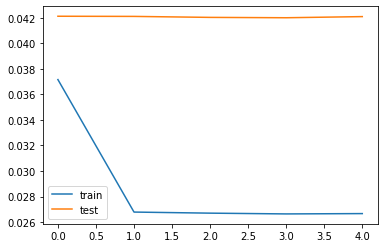

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0344 - val_loss: 0.0421
Epoch 2/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0277 - val_loss: 0.0421
Epoch 3/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0275 - val_loss: 0.0423
Epoch 4/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0274 - val_loss: 0.0422
Epoch 5/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0273 - val_loss: 0.0422


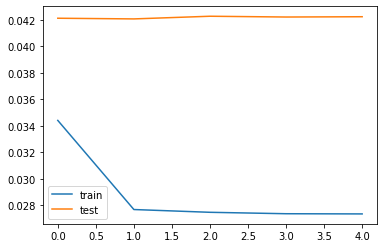

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 6s 5ms/step - loss: 0.0673 - val_loss: 0.0421
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0286 - val_loss: 0.0420
Epoch 3/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0283 - val_loss: 0.0419
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0281 - val_loss: 0.0419
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0281 - val_loss: 0.0419


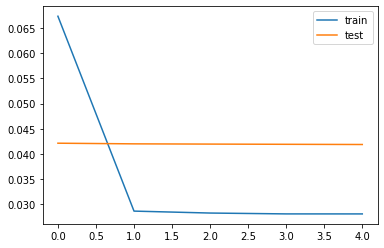

================FIT Parameters -> epochs: 5 -> input: 32 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0610 - val_loss: 0.0429
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0298 - val_loss: 0.0430
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0295 - val_loss: 0.0427
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0293 - val_loss: 0.0427
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0294 - val_loss: 0.0425


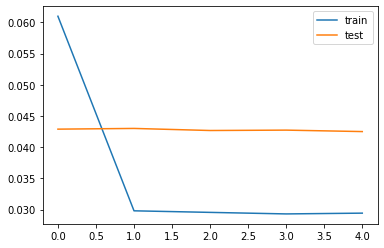

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 2 ====================
Epoch 1/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0288 - val_loss: 0.0434
Epoch 2/5
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0424
Epoch 3/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 4/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 5/5
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0426


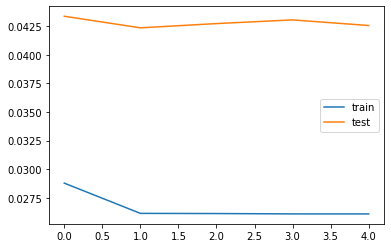

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 4 ====================
Epoch 1/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0299 - val_loss: 0.0429
Epoch 2/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0266 - val_loss: 0.0426
Epoch 3/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0264 - val_loss: 0.0430
Epoch 4/5
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0431
Epoch 5/5
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0428


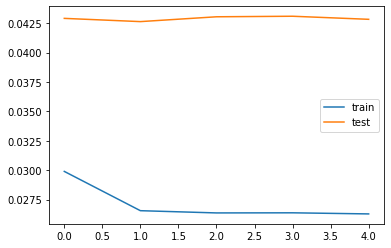

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 8 ====================
Epoch 1/5
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0336 - val_loss: 0.0423
Epoch 2/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0423
Epoch 3/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0266 - val_loss: 0.0424
Epoch 4/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0266 - val_loss: 0.0424
Epoch 5/5
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0266 - val_loss: 0.0421


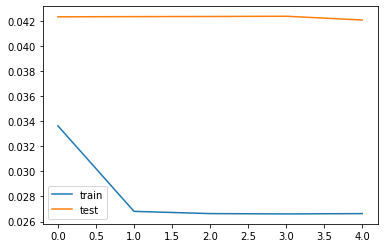

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 16 ====================
Epoch 1/5
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0353 - val_loss: 0.0419
Epoch 2/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0277 - val_loss: 0.0420
Epoch 3/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0275 - val_loss: 0.0425
Epoch 4/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0274 - val_loss: 0.0425
Epoch 5/5
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0273 - val_loss: 0.0429


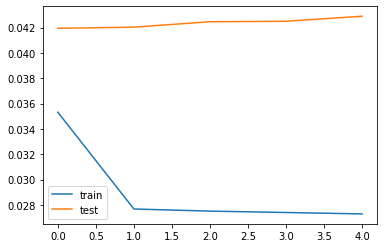

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 32 ====================
Epoch 1/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0468 - val_loss: 0.0424
Epoch 2/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0286 - val_loss: 0.0421
Epoch 3/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0282 - val_loss: 0.0420
Epoch 4/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0419
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0421


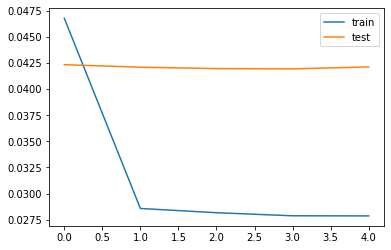

================FIT Parameters -> epochs: 5 -> input: 64 -> batch: 64 ====================
Epoch 1/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0556 - val_loss: 0.0425
Epoch 2/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0295 - val_loss: 0.0420
Epoch 3/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0292 - val_loss: 0.0420
Epoch 4/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0293 - val_loss: 0.0422
Epoch 5/5
556/556 [==============================] - 3s 5ms/step - loss: 0.0291 - val_loss: 0.0419


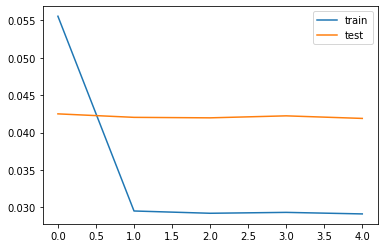

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0284 - val_loss: 0.0430
Epoch 2/10
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0262 - val_loss: 0.0425
Epoch 3/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0262 - val_loss: 0.0425
Epoch 4/10
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 5/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 6/10
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 7/10
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0261 - val_loss: 0.0425
Epoch 8/10
17774/17774 [==============================] - 69s 4ms/step - loss: 0.0261 - val_loss: 0.0425
Epoch 9/10
17774/17774 [==============================] - 68s 4ms/step

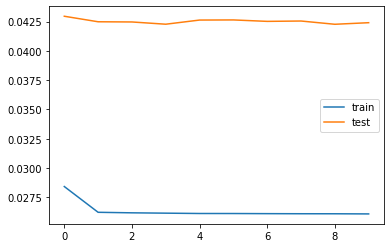

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0319 - val_loss: 0.0422
Epoch 2/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0421
Epoch 3/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0422
Epoch 4/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0422
Epoch 5/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0422
Epoch 6/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0423
Epoch 7/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0421
Epoch 8/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0421
Epoch 9/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - 

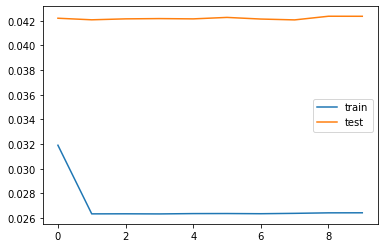

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0348 - val_loss: 0.0424
Epoch 2/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 3/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0269 - val_loss: 0.0421
Epoch 4/10
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 5/10
4444/4444 [==============================] - 20s 5ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 6/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 7/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 8/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 9/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - 

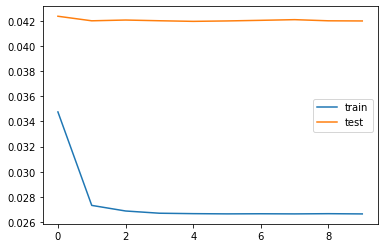

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0437 - val_loss: 0.0420
Epoch 2/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 3/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 4/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 5/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 6/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 7/10
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 8/10
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 9/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 -

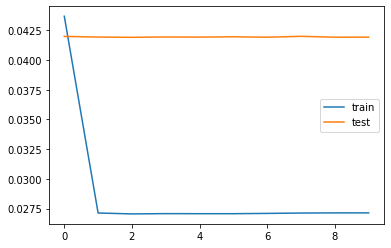

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0533 - val_loss: 0.0426
Epoch 2/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0428
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0428
Epoch 4/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0277 - val_loss: 0.0430
Epoch 5/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 0.0432
Epoch 6/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0283 - val_loss: 0.0422
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 8/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0421
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss

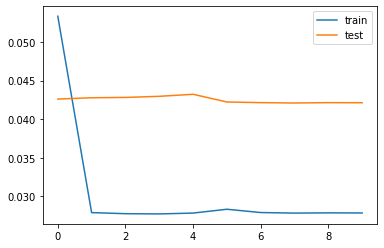

================FIT Parameters -> epochs: 10 -> input: 2 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.1158 - val_loss: 0.0446
Epoch 2/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0312 - val_loss: 0.0433
Epoch 3/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0303 - val_loss: 0.0426
Epoch 4/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0424
Epoch 5/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0422
Epoch 6/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0422
Epoch 7/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0421
Epoch 8/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0421
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0421
Epoch 10/

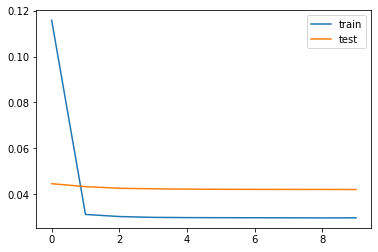

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 64s 4ms/step - loss: 0.0288 - val_loss: 0.0430
Epoch 2/10
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0262 - val_loss: 0.0426
Epoch 3/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 4/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 5/10
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 6/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 7/10
17774/17774 [==============================] - 67s 4ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 8/10
17774/17774 [==============================] - 68s 4ms/step - loss: 0.0260 - val_loss: 0.0426
Epoch 9/10
17774/17774 [==============================] - 68s 4ms/step

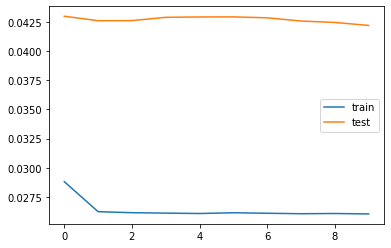

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0306 - val_loss: 0.0432
Epoch 2/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0265 - val_loss: 0.0429
Epoch 3/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 4/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 5/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0262 - val_loss: 0.0428
Epoch 6/10
8887/8887 [==============================] - 34s 4ms/step - loss: 0.0262 - val_loss: 0.0432
Epoch 7/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0435
Epoch 8/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0435
Epoch 9/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - 

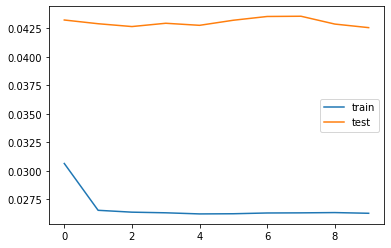

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0314 - val_loss: 0.0421
Epoch 2/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0422
Epoch 3/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0421
Epoch 5/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 6/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 7/10
4444/4444 [==============================] - 20s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 8/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0425
Epoch 9/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - 

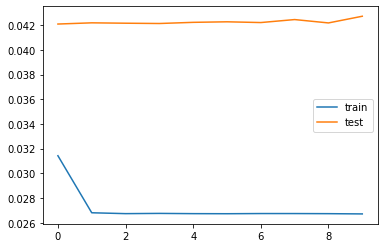

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0424 - val_loss: 0.0424
Epoch 2/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0424
Epoch 3/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0421
Epoch 4/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 5/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0269 - val_loss: 0.0419
Epoch 6/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0270 - val_loss: 0.0419
Epoch 7/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 8/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0270 - val_loss: 0.0419
Epoch 9/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0270 - va

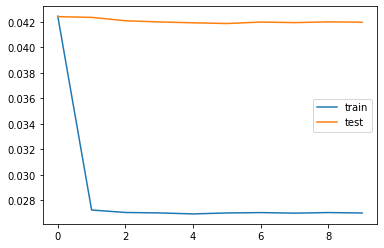

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0549 - val_loss: 0.0426
Epoch 2/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0284 - val_loss: 0.0422
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss: 0.0421
Epoch 4/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0421
Epoch 5/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 6/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 8/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss

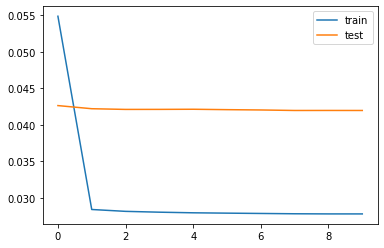

================FIT Parameters -> epochs: 10 -> input: 4 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0752 - val_loss: 0.0425
Epoch 2/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0424
Epoch 3/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0422
Epoch 4/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0422
Epoch 5/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0422
Epoch 6/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0422
Epoch 7/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0293 - val_loss: 0.0423
Epoch 8/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0421
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0423
Epoch 10/

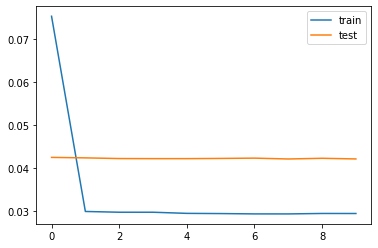

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 64s 4ms/step - loss: 0.0281 - val_loss: 0.0434
Epoch 2/10
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0263 - val_loss: 0.0428
Epoch 3/10
17774/17774 [==============================] - 64s 4ms/step - loss: 0.0262 - val_loss: 0.0427
Epoch 4/10
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 5/10
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0262 - val_loss: 0.0427
Epoch 6/10
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0262 - val_loss: 0.0423
Epoch 7/10
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0431
Epoch 8/10
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 9/10
17774/17774 [==============================] - 65s 4ms/step

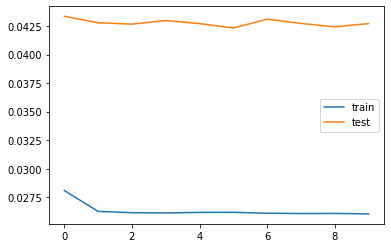

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0297 - val_loss: 0.0426
Epoch 2/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0264 - val_loss: 0.0424
Epoch 3/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0426
Epoch 4/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - val_loss: 0.0427
Epoch 5/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - val_loss: 0.0430
Epoch 6/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - val_loss: 0.0430
Epoch 7/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - val_loss: 0.0426
Epoch 8/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - val_loss: 0.0423
Epoch 9/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - 

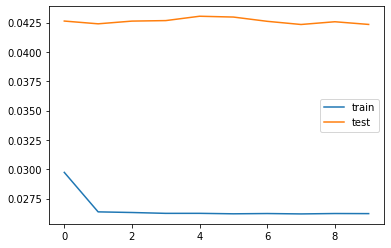

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0342 - val_loss: 0.0422
Epoch 2/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0268 - val_loss: 0.0422
Epoch 3/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 4/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 5/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 6/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 8/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 9/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - 

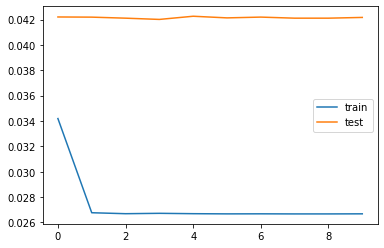

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 11s 5ms/step - loss: 0.0359 - val_loss: 0.0422
Epoch 2/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0276 - val_loss: 0.0423
Epoch 3/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0274 - val_loss: 0.0420
Epoch 4/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 5/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 6/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 7/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 8/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 9/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val

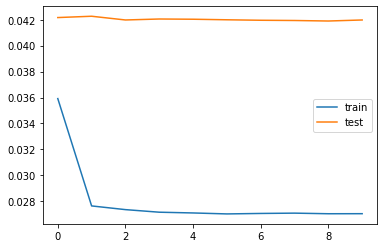

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0436 - val_loss: 0.0424
Epoch 2/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0282 - val_loss: 0.0421
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 4/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 5/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 6/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0419
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0277 - val_loss: 0.0420
Epoch 8/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss

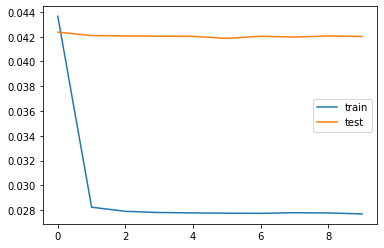

================FIT Parameters -> epochs: 10 -> input: 8 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0588 - val_loss: 0.0431
Epoch 2/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0308 - val_loss: 0.0424
Epoch 3/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0301 - val_loss: 0.0425
Epoch 4/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0299 - val_loss: 0.0424
Epoch 5/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0298 - val_loss: 0.0430
Epoch 6/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0431
Epoch 7/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0430
Epoch 8/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0431
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0427
Epoch 10/

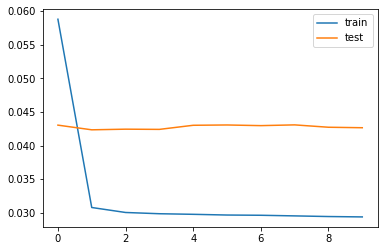

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0282 - val_loss: 0.0438
Epoch 2/10
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 3/10
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0262 - val_loss: 0.0432
Epoch 4/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0428
Epoch 5/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0260 - val_loss: 0.0426
Epoch 6/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 7/10
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0260 - val_loss: 0.0427
Epoch 8/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0422
Epoch 9/10
17774/17774 [==============================] - 60s 3ms/ste

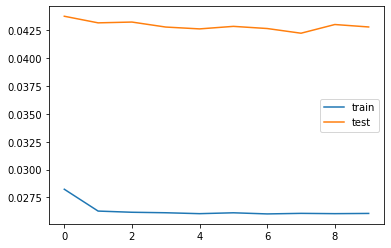

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0288 - val_loss: 0.0426
Epoch 2/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0266 - val_loss: 0.0428
Epoch 3/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 4/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0425
Epoch 5/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 6/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0433
Epoch 7/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0433
Epoch 8/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 9/10
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 -

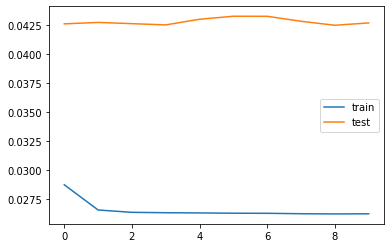

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0338 - val_loss: 0.0424
Epoch 2/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0268 - val_loss: 0.0423
Epoch 3/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0268 - val_loss: 0.0423
Epoch 4/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 5/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 6/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 8/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 9/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 -

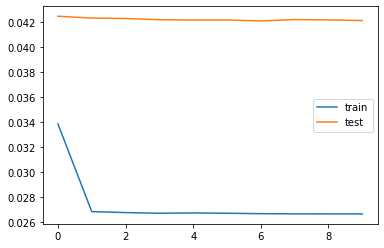

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0357 - val_loss: 0.0424
Epoch 2/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 3/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 4/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0425
Epoch 5/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0422
Epoch 6/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0426
Epoch 7/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0421
Epoch 8/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 9/10
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_los

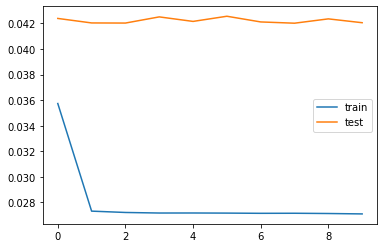

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0376 - val_loss: 0.0422
Epoch 2/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0285 - val_loss: 0.0422
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss: 0.0422
Epoch 4/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 5/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0423
Epoch 6/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0421
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0421
Epoch 8/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0277 - val_loss: 0.0420
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_los

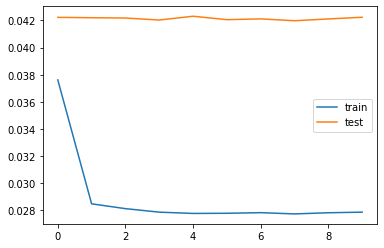

================FIT Parameters -> epochs: 10 -> input: 16 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0521 - val_loss: 0.0426
Epoch 2/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0303 - val_loss: 0.0421
Epoch 3/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0423
Epoch 4/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0423
Epoch 5/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0425
Epoch 6/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0424
Epoch 7/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0423
Epoch 8/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0423
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0423
Epoch 10

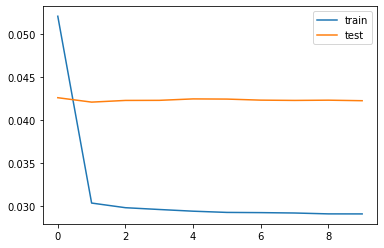

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0283 - val_loss: 0.0431
Epoch 2/10
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0265 - val_loss: 0.0431
Epoch 3/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0432
Epoch 4/10
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0262 - val_loss: 0.0424
Epoch 5/10
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0261 - val_loss: 0.0431
Epoch 6/10
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0261 - val_loss: 0.0437
Epoch 7/10
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 8/10
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0260 - val_loss: 0.0424
Epoch 9/10
17774/17774 [==============================] - 63s 4ms/ste

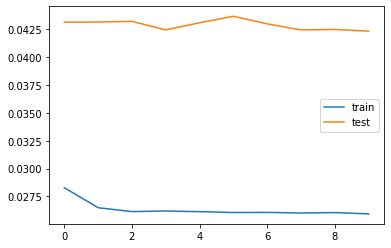

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0300 - val_loss: 0.0428
Epoch 2/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 3/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 4/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 5/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0434
Epoch 6/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 7/10
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0431
Epoch 8/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 9/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 -

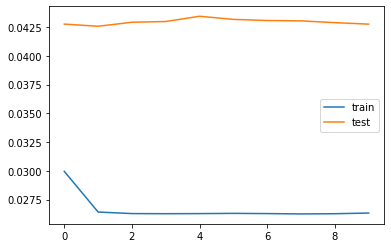

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0331 - val_loss: 0.0422
Epoch 2/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0269 - val_loss: 0.0423
Epoch 3/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 5/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 6/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 8/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0421
Epoch 9/10
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 -

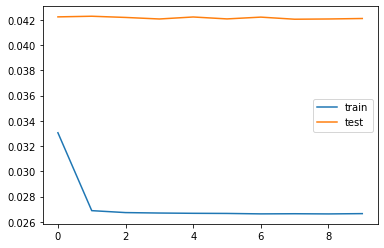

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0348 - val_loss: 0.0421
Epoch 2/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0275 - val_loss: 0.0421
Epoch 3/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0274 - val_loss: 0.0420
Epoch 4/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 5/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 6/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0424
Epoch 7/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 8/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 9/10
2222/2222 [==============================] - 10s 5ms/step - loss: 0.0271 

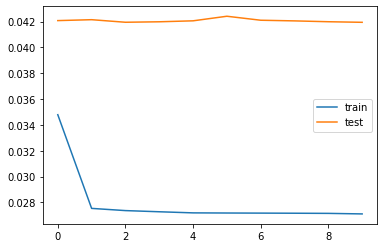

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 6s 6ms/step - loss: 0.0472 - val_loss: 0.0422
Epoch 2/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0284 - val_loss: 0.0420
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0422
Epoch 4/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0279 - val_loss: 0.0422
Epoch 5/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0425
Epoch 6/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 7/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 0.0419
Epoch 8/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0277 - val_los

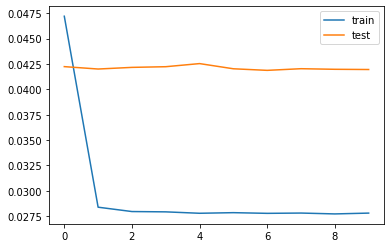

================FIT Parameters -> epochs: 10 -> input: 32 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0597 - val_loss: 0.0430
Epoch 2/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0424
Epoch 3/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0426
Epoch 4/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0420
Epoch 5/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0423
Epoch 6/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0422
Epoch 7/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0290 - val_loss: 0.0425
Epoch 8/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0290 - val_loss: 0.0421
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0423
Epoch 10

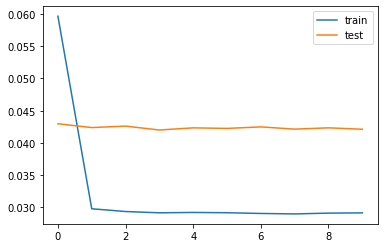

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 2 ====================
Epoch 1/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0290 - val_loss: 0.0424
Epoch 2/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 3/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0260 - val_loss: 0.0426
Epoch 4/10
17774/17774 [==============================] - 64s 4ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 5/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0260 - val_loss: 0.0425
Epoch 6/10
17774/17774 [==============================] - 62s 4ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 7/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0260 - val_loss: 0.0424
Epoch 8/10
17774/17774 [==============================] - 63s 4ms/step - loss: 0.0259 - val_loss: 0.0420
Epoch 9/10
17774/17774 [==============================] - 64s 4ms/ste

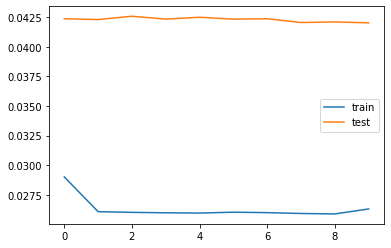

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 4 ====================
Epoch 1/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0290 - val_loss: 0.0429
Epoch 2/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0265 - val_loss: 0.0427
Epoch 3/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 4/10
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 5/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0425
Epoch 6/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 7/10
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0262 - val_loss: 0.0426
Epoch 8/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0433
Epoch 9/10
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 -

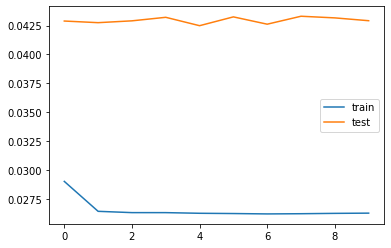

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 8 ====================
Epoch 1/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0312 - val_loss: 0.0423
Epoch 2/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0269 - val_loss: 0.0422
Epoch 3/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 4/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 5/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 6/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 8/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 9/10
4444/4444 [==============================] - 19s 4ms/step - loss: 0.0267 -

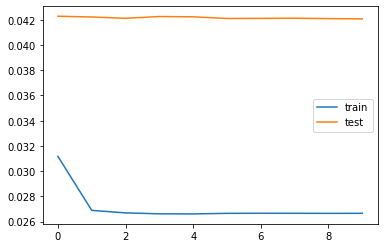

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 16 ====================
Epoch 1/10
2222/2222 [==============================] - 11s 5ms/step - loss: 0.0334 - val_loss: 0.0430
Epoch 2/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0281 - val_loss: 0.0426
Epoch 3/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0275 - val_loss: 0.0421
Epoch 4/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0273 - val_loss: 0.0424
Epoch 5/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 6/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0419
Epoch 7/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 8/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 9/10
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0271 

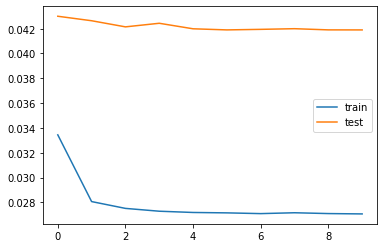

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 32 ====================
Epoch 1/10
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0421 - val_loss: 0.0420
Epoch 2/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0286 - val_loss: 0.0421
Epoch 3/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0283 - val_loss: 0.0424
Epoch 4/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss: 0.0420
Epoch 5/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 6/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 8/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 9/10
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_los

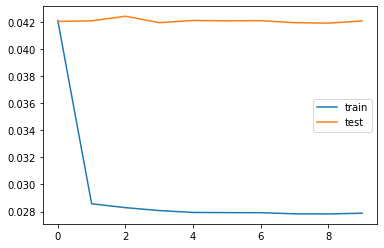

================FIT Parameters -> epochs: 10 -> input: 64 -> batch: 64 ====================
Epoch 1/10
556/556 [==============================] - 3s 5ms/step - loss: 0.0803 - val_loss: 0.0428
Epoch 2/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0301 - val_loss: 0.0436
Epoch 3/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0433
Epoch 4/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0431
Epoch 5/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0433
Epoch 6/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0419
Epoch 7/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0430
Epoch 8/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0428
Epoch 9/10
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0428
Epoch 10

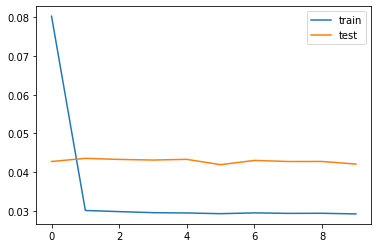

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0289 - val_loss: 0.0422
Epoch 2/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 3/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 4/15
17774/17774 [==============================] - 64s 4ms/step - loss: 0.0261 - val_loss: 0.0425
Epoch 5/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0424
Epoch 6/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0429
Epoch 7/15
17774/17774 [==============================] - 66s 4ms/step - loss: 0.0261 - val_loss: 0.0428
Epoch 8/15
17774/17774 [==============================] - 65s 4ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 9/15
17774/17774 [==============================] - 65s 4ms/step

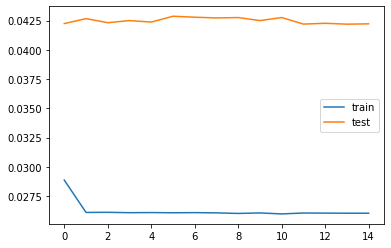

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0311 - val_loss: 0.0421
Epoch 2/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0264 - val_loss: 0.0423
Epoch 3/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0422
Epoch 4/15
8887/8887 [==============================] - 33s 4ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 5/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 6/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 7/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0446
Epoch 8/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0263 - val_loss: 0.0425
Epoch 9/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0262 - 

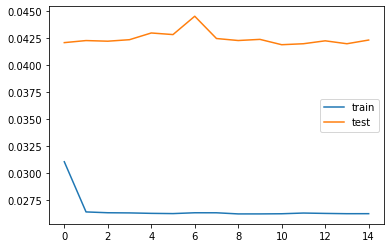

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0365 - val_loss: 0.0426
Epoch 2/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0269 - val_loss: 0.0423
Epoch 3/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 5/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 6/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 7/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0421
Epoch 8/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0420
Epoch 9/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - 

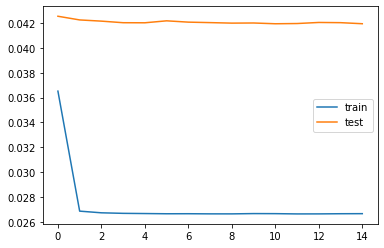

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0459 - val_loss: 0.0421
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 6/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss

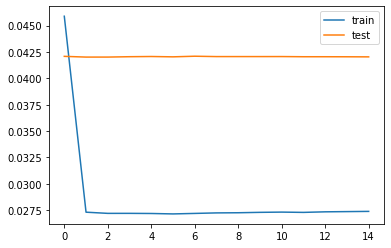

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 5ms/step - loss: 0.0564 - val_loss: 0.0430
Epoch 2/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0289 - val_loss: 0.0422
Epoch 3/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0284 - val_loss: 0.0427
Epoch 4/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0284 - val_loss: 0.0424
Epoch 5/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0421
Epoch 6/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0435
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0283 - val_loss: 0.0422
Epoch 9/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss

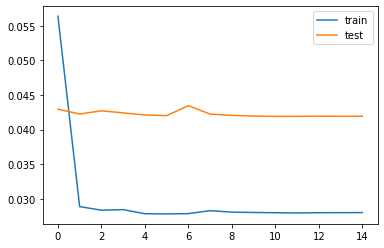

================FIT Parameters -> epochs: 15 -> input: 2 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0669 - val_loss: 0.0426
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0300 - val_loss: 0.0428
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0426
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0425
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0424
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0423
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0423
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0423
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0422
Epoch 10/

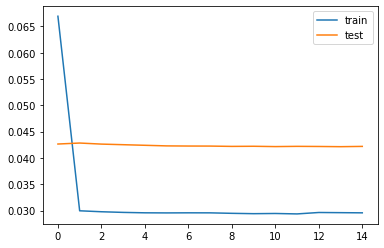

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 62s 3ms/step - loss: 0.0280 - val_loss: 0.0430
Epoch 2/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 3/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0428
Epoch 4/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 5/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0260 - val_loss: 0.0428
Epoch 6/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0260 - val_loss: 0.0421
Epoch 7/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 8/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0260 - val_loss: 0.0422
Epoch 9/15
17774/17774 [==============================] - 60s 3ms/step

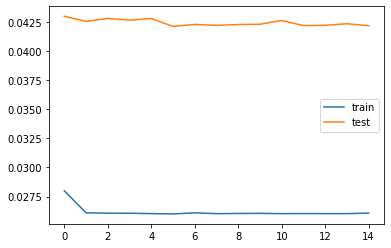

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0298 - val_loss: 0.0426
Epoch 2/15
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0265 - val_loss: 0.0424
Epoch 3/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0425
Epoch 4/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 5/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 6/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0423
Epoch 7/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0423
Epoch 8/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 9/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - 

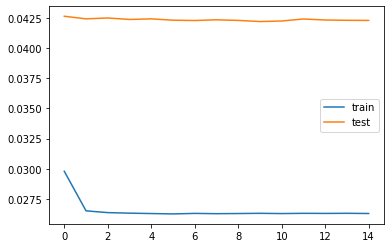

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0320 - val_loss: 0.0426
Epoch 2/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0269 - val_loss: 0.0424
Epoch 3/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0268 - val_loss: 0.0424
Epoch 4/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 5/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0268 - val_loss: 0.0421
Epoch 6/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 8/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 9/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - 

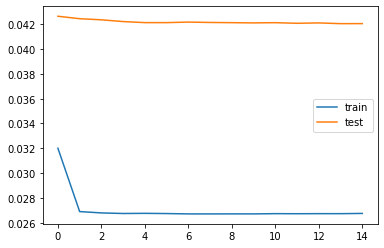

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0415 - val_loss: 0.0429
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0276 - val_loss: 0.0422
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0422
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0422
Epoch 6/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0423
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0422
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss

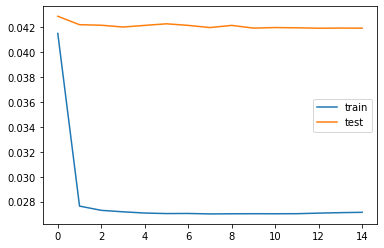

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0539 - val_loss: 0.0428
Epoch 2/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0282 - val_loss: 0.0422
Epoch 3/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0421
Epoch 4/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 5/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 6/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0419
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0419
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 9/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss

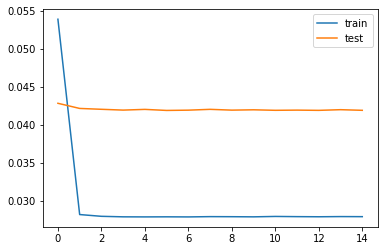

================FIT Parameters -> epochs: 15 -> input: 4 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0764 - val_loss: 0.0435
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0303 - val_loss: 0.0433
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0300 - val_loss: 0.0432
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0429
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0428
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0427
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0426
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0424
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0423
Epoch 10/

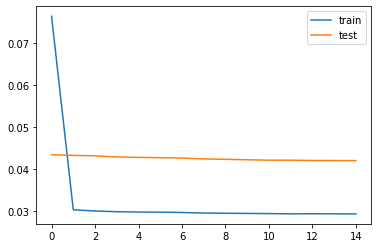

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0286 - val_loss: 0.0432
Epoch 2/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 3/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0427
Epoch 4/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 5/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 6/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 7/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0421
Epoch 8/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0422
Epoch 9/15
17774/17774 [==============================] - 59s 3ms/step

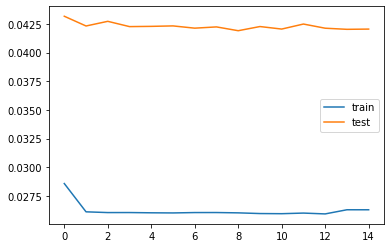

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0299 - val_loss: 0.0426
Epoch 2/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 3/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 4/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0424
Epoch 5/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0424
Epoch 6/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0264 - val_loss: 0.0425
Epoch 7/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0424
Epoch 8/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0428
Epoch 9/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - 

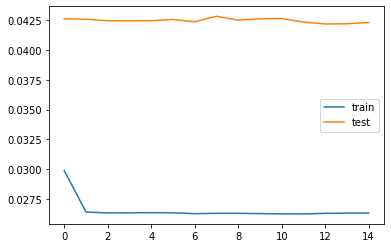

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0353 - val_loss: 0.0420
Epoch 2/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0269 - val_loss: 0.0420
Epoch 3/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 5/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 6/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 8/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 9/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - 

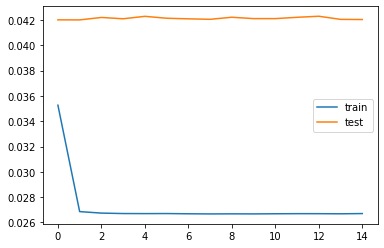

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0346 - val_loss: 0.0422
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0275 - val_loss: 0.0421
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0422
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0421
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 6/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0421
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0419
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss

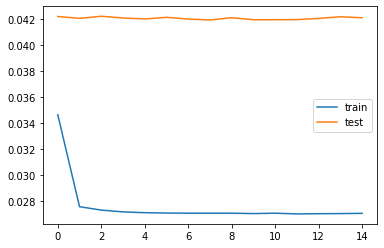

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0583 - val_loss: 0.0425
Epoch 2/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0284 - val_loss: 0.0423
Epoch 3/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0282 - val_loss: 0.0422
Epoch 4/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss: 0.0421
Epoch 5/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0422
Epoch 6/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0419
Epoch 9/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss

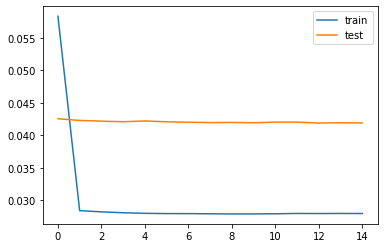

================FIT Parameters -> epochs: 15 -> input: 8 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0774 - val_loss: 0.0423
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0425
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0429
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0428
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0426
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0425
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0425
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0424
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0421
Epoch 10/

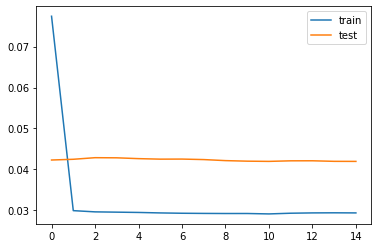

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0283 - val_loss: 0.0431
Epoch 2/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0265 - val_loss: 0.0431
Epoch 3/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0263 - val_loss: 0.0433
Epoch 4/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0262 - val_loss: 0.0429
Epoch 5/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 6/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 7/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0260 - val_loss: 0.0426
Epoch 8/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0260 - val_loss: 0.0423
Epoch 9/15
17774/17774 [==============================] - 58s 3ms/ste

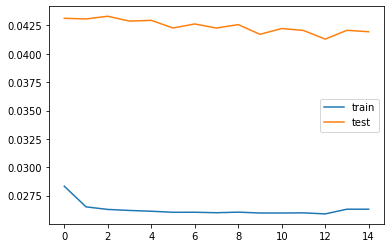

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0298 - val_loss: 0.0429
Epoch 2/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0264 - val_loss: 0.0428
Epoch 3/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0426
Epoch 4/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0425
Epoch 5/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0425
Epoch 6/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0427
Epoch 7/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0425
Epoch 8/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0262 - val_loss: 0.0431
Epoch 9/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 -

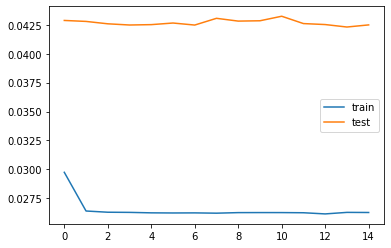

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0316 - val_loss: 0.0422
Epoch 2/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0268 - val_loss: 0.0422
Epoch 3/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 5/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 6/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0420
Epoch 8/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 9/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 -

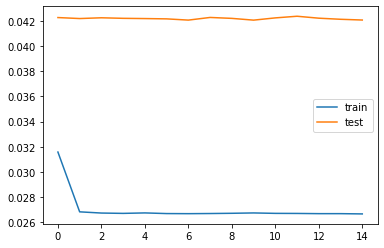

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0400 - val_loss: 0.0423
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0275 - val_loss: 0.0419
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0274 - val_loss: 0.0420
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0422
Epoch 6/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0422
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0425
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_lo

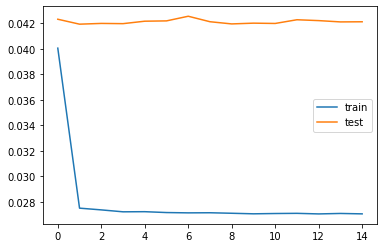

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0900 - val_loss: 0.0420
Epoch 2/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0322 - val_loss: 0.0419
Epoch 3/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0320 - val_loss: 0.0420
Epoch 4/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0320 - val_loss: 0.0419
Epoch 5/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0320 - val_loss: 0.0420
Epoch 6/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0319 - val_loss: 0.0420
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0319 - val_loss: 0.0420
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0320 - val_loss: 0.0420
Epoch 9/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0319 - val_los

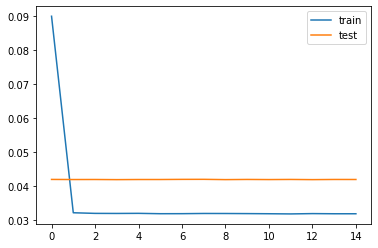

================FIT Parameters -> epochs: 15 -> input: 16 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0871 - val_loss: 0.0435
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0301 - val_loss: 0.0433
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0431
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0432
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0431
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0429
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0428
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0428
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0427
Epoch 10

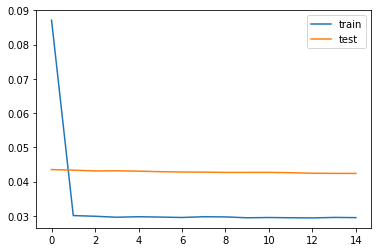

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0288 - val_loss: 0.0438
Epoch 2/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0262 - val_loss: 0.0427
Epoch 3/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0261 - val_loss: 0.0430
Epoch 4/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 5/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 6/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0260 - val_loss: 0.0422
Epoch 7/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0260 - val_loss: 0.0421
Epoch 8/15
17774/17774 [==============================] - 58s 3ms/step - loss: 0.0259 - val_loss: 0.0423
Epoch 9/15
17774/17774 [==============================] - 58s 3ms/ste

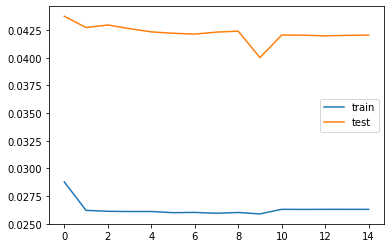

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0297 - val_loss: 0.0428
Epoch 2/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0265 - val_loss: 0.0428
Epoch 3/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 - val_loss: 0.0429
Epoch 4/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 - val_loss: 0.0425
Epoch 5/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 6/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0431
Epoch 7/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 - val_loss: 0.0430
Epoch 8/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0425
Epoch 9/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 -

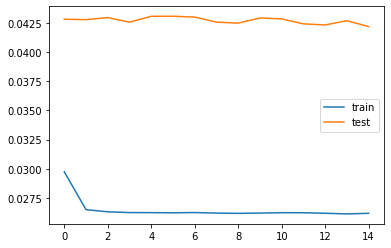

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0348 - val_loss: 0.0424
Epoch 2/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 3/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0422
Epoch 4/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0266 - val_loss: 0.0421
Epoch 5/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 6/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0266 - val_loss: 0.0421
Epoch 7/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 8/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 9/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0266 -

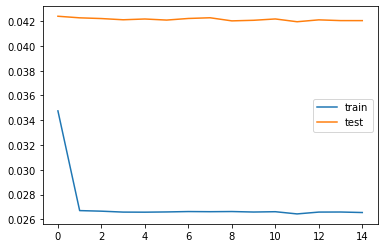

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0327 - val_loss: 0.0427
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0280 - val_loss: 0.0423
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0276 - val_loss: 0.0420
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0275 - val_loss: 0.0421
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0421
Epoch 6/15
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0273 - val_loss: 0.0421
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0272 - val_loss: 0.0420
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_lo

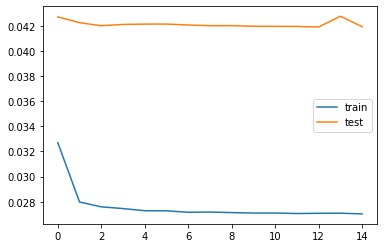

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0619 - val_loss: 0.0422
Epoch 2/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0282 - val_loss: 0.0421
Epoch 3/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0422
Epoch 4/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0421
Epoch 5/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0423
Epoch 6/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0420
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0280 - val_loss: 0.0419
Epoch 9/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_los

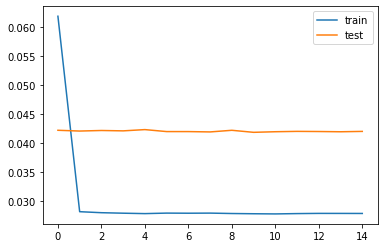

================FIT Parameters -> epochs: 15 -> input: 32 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0806 - val_loss: 0.0426
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0297 - val_loss: 0.0422
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0295 - val_loss: 0.0429
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0427
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0428
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0426
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0427
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0292 - val_loss: 0.0426
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0427
Epoch 10

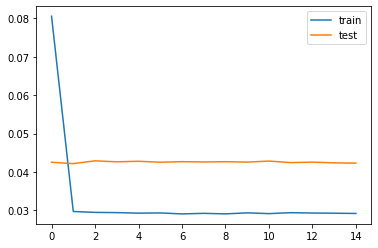

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 2 ====================
Epoch 1/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0284 - val_loss: 0.0431
Epoch 2/15
17774/17774 [==============================] - 61s 3ms/step - loss: 0.0263 - val_loss: 0.0435
Epoch 3/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0262 - val_loss: 0.0432
Epoch 4/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0262 - val_loss: 0.0438
Epoch 5/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0261 - val_loss: 0.0434
Epoch 6/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0435
Epoch 7/15
17774/17774 [==============================] - 59s 3ms/step - loss: 0.0261 - val_loss: 0.0425
Epoch 8/15
17774/17774 [==============================] - 60s 3ms/step - loss: 0.0260 - val_loss: 0.0424
Epoch 9/15
17774/17774 [==============================] - 59s 3ms/ste

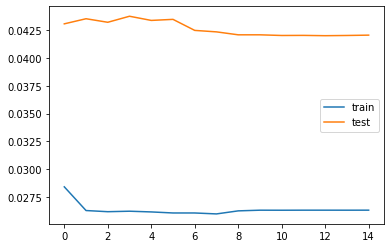

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 4 ====================
Epoch 1/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0304 - val_loss: 0.0427
Epoch 2/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0265 - val_loss: 0.0428
Epoch 3/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0432
Epoch 4/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0263 - val_loss: 0.0427
Epoch 5/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0428
Epoch 6/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0261 - val_loss: 0.0426
Epoch 7/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0424
Epoch 8/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 - val_loss: 0.0426
Epoch 9/15
8887/8887 [==============================] - 29s 3ms/step - loss: 0.0262 -

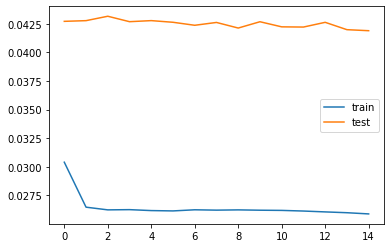

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 8 ====================
Epoch 1/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0298 - val_loss: 0.0425
Epoch 2/15
4444/4444 [==============================] - 18s 4ms/step - loss: 0.0271 - val_loss: 0.0422
Epoch 3/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0268 - val_loss: 0.0424
Epoch 4/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0424
Epoch 5/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0424
Epoch 6/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0421
Epoch 7/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0266 - val_loss: 0.0423
Epoch 8/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 - val_loss: 0.0424
Epoch 9/15
4444/4444 [==============================] - 17s 4ms/step - loss: 0.0267 -

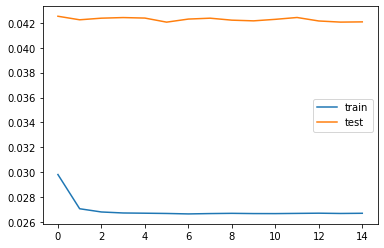

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 16 ====================
Epoch 1/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0375 - val_loss: 0.0420
Epoch 2/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0277 - val_loss: 0.0419
Epoch 3/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 4/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0273 - val_loss: 0.0421
Epoch 5/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 6/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0271 - val_loss: 0.0420
Epoch 7/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 8/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_loss: 0.0420
Epoch 9/15
2222/2222 [==============================] - 9s 4ms/step - loss: 0.0270 - val_los

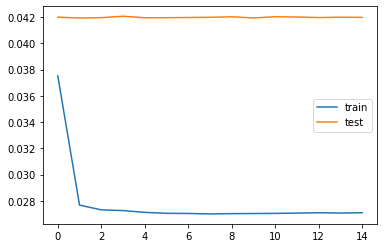

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 32 ====================
Epoch 1/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0403 - val_loss: 0.0423
Epoch 2/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0285 - val_loss: 0.0424
Epoch 3/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0281 - val_loss: 0.0422
Epoch 4/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0280 - val_loss: 0.0426
Epoch 5/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 6/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0419
Epoch 7/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 8/15
1111/1111 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0419
Epoch 9/15
1111/1111 [==============================] - 4s 4ms/step - loss: 0.0278 - val_los

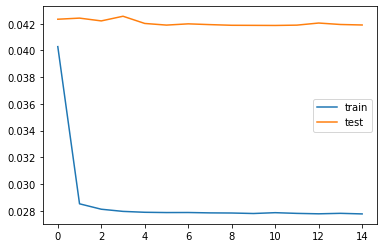

================FIT Parameters -> epochs: 15 -> input: 64 -> batch: 64 ====================
Epoch 1/15
556/556 [==============================] - 3s 5ms/step - loss: 0.0702 - val_loss: 0.0423
Epoch 2/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0298 - val_loss: 0.0434
Epoch 3/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0436
Epoch 4/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0437
Epoch 5/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0293 - val_loss: 0.0437
Epoch 6/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0435
Epoch 7/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0294 - val_loss: 0.0433
Epoch 8/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0290 - val_loss: 0.0431
Epoch 9/15
556/556 [==============================] - 2s 4ms/step - loss: 0.0291 - val_loss: 0.0431
Epoch 10

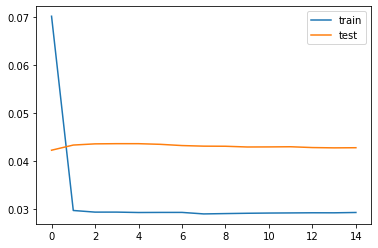

[(<tensorflow.python.keras.callbacks.History object at 0x7fec37c8e6a0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec37d9c4a8>), (<tensorflow.python.keras.callbacks.History object at 0x7fec584c8ef0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec58511f60>), (<tensorflow.python.keras.callbacks.History object at 0x7fec36e1f748>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec377b0b00>), (<tensorflow.python.keras.callbacks.History object at 0x7fec35977ef0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec61fa8c50>), (<tensorflow.python.keras.callbacks.History object at 0x7fec342d9828>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec3542c240>), (<tensorflow.python.keras.callbacks.History object at 0x7fec33c3b7f0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fec3407c390>), (<tensorflow.python.keras.callbacks.History object at 0x7fec31855080>, <tensorflo

In [ ]:
losses = myGridSearch(3,6,6)
print(losses)

Para critério de comparação criamos um GridSearch utilizando o SKlearn e os mesmos parâmetros.

In [54]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_classifier(optimizer,units):
    grid_model = Sequential()
    grid_model.add(LSTM(units = units, input_shape = (30,5)))
    grid_model.add(Dense(10, activation='relu'))
    grid_model.add(Dense(10))

    grid_model.compile(loss = 'mae',optimizer = optimizer, metrics = ['mean_squared_error'])
    return grid_model



Os valores abaixo foram os mesmos utilizados no myGridSearch. A diferença foi no dado de entrada, nesse caso utilizei o dataset inteiro devido ao parâmetro de crossvalidation do gridsearch.

In [ ]:
grid_model = KerasRegressor(build_fn=build_classifier)
parameters = {'batch_size' : [2,4,8,16,32,64],
              'epochs' : [5,10,15],
              'units' : [2,4,8,16,32,64],
              'optimizer' : ['adam'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            #scoring = 'max_error',
                            cv = 2)

grid_search = grid_search.fit(X_N.reshape((X_N.shape[0], 30, 5)), y_N)

Epoch 1/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0380 - mean_squared_error: 0.0045
Epoch 2/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0302 - mean_squared_error: 0.0031
Epoch 3/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0301 - mean_squared_error: 0.0031
Epoch 4/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0300 - mean_squared_error: 0.0031
Epoch 5/5
11109/11109 [==============================] - 24s 2ms/step - loss: 0.0235 - mean_squared_error: 0.0025
Epoch 1/5
11109/11109 [==============================] - 37s 3ms/step - loss: 0.0261 - mean_squared_error: 0.0033
Epoch 2/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0234 - mean_squared_error: 0.0025
Epoch 3/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0233 - mean_squared_error: 0.0025
Epoch 4/5
11109/11109 [==============================] - 38s 3ms/step - loss: 0.0232 - m

In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

O melhor valor sugerido deu bem diferente dos testes do myGridSearch. Para validar novamente os resultados sugeridos eu rodei o treino individualmente.

In [ ]:
best_parameters

{'batch_size': 64, 'epochs': 10, 'optimizer': 'adam', 'units': 16}

Treinamento utilizando os parâmetros do GridSearch (sklearn):

Epoch 1/10
556/556 [==============================] - 5s 8ms/step - loss: 0.0540 - val_loss: 0.0427
Epoch 2/10
556/556 [==============================] - 4s 8ms/step - loss: 0.0302 - val_loss: 0.0425
Epoch 3/10
556/556 [==============================] - 4s 8ms/step - loss: 0.0297 - val_loss: 0.0423
Epoch 4/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0296 - val_loss: 0.0425
Epoch 5/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0295 - val_loss: 0.0429
Epoch 6/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0293 - val_loss: 0.0426
Epoch 7/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0293 - val_loss: 0.0425
Epoch 8/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0292 - val_loss: 0.0422
Epoch 9/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0292 - val_loss: 0.0424
Epoch 10/10
556/556 [==============================] - 4s 7ms/step - loss: 0.0292 - val_loss: 0.0426

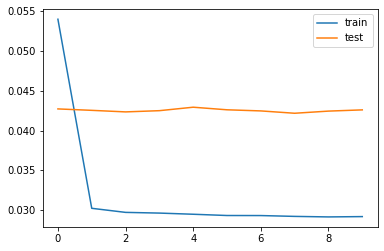

In [ ]:
hist, model = fitModel (X_Train, y_Train, X_Test, y_Test, 16, 64, 10)

Treinamento utilizando os parâmetros do myGridSearch:

Epoch 1/15
8887/8887 [==============================] - 32s 4ms/step - loss: 0.0324 - val_loss: 0.0423
Epoch 2/15
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0264 - val_loss: 0.0422
Epoch 3/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0262 - val_loss: 0.0421
Epoch 4/15
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0262 - val_loss: 0.0422
Epoch 5/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0263 - val_loss: 0.0422
Epoch 6/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0262 - val_loss: 0.0424
Epoch 7/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0261 - val_loss: 0.0424
Epoch 8/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0262 - val_loss: 0.0421
Epoch 9/15
8887/8887 [==============================] - 31s 4ms/step - loss: 0.0262 - val_loss: 0.0422
Epoch 10/15
8887/8887 [==============================] - 32s 4ms/step - l

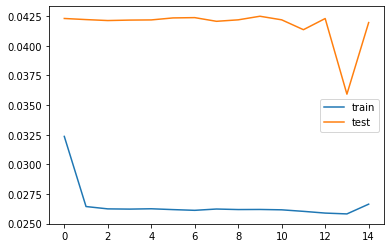

In [55]:
hist, model = fitModel (X_Train, y_Train, X_Test, y_Test, 64, 4, 15)

In [56]:
model.save('model_LSTM.h5')

O modelo escolhido foi salvo para uso futuro e não precisar rodar as etapas acima novamente. Em seguida carregaremos o modelo treinado para iniciar as predições.

#### Predição e Métricas (RMSE)

In [57]:
model = load_model('model_LSTM.h5')

Lembrando que a idéia é fazer a predição ou forecast dos próximos 10 valores de validação do sistema RFID e compará-lo com a base de teste para calcular o erro e medir sua eficácia.

A função abaixo será chamada para fazer a predição que retornar um array de tamanho 10 com os resultados.

In [58]:
def predict_lstm(model, X, n_batch):
	# reshape para [samples, timesteps, features]
  # Como será feito o predict de item a item a transformação será feita conforme abaixo.
	X = X.reshape(1, X.shape[0], X.shape[1])
  
	# Fazer o forecast
	forecast = model.predict(X, batch_size=n_batch)
	# Transforma em array para melhor trabalhar com os resultados
	return [x for x in forecast[0, :]]

Abaixo iremos montar o yPred, ou seja, as predições de todo o X_Test.

In [59]:
yPred = list()
for i in range (len(X_Test)):
  forecast = predict_lstm(model, X_Test[i], 1)
  yPred.append(forecast)

yPred

[[0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  0.36363026,
  0.3634336,
  0.363519,
  0.36401206,
  0.36381894,
  0.36359712],
 [0.363351,
  0.36375475,
  0.36391369,
  0.3635513,
  

Para facilitar a comparação iremos transformar o y_Test em uma lista de arrays.

In [60]:
yTest = [row[:] for row in y_Test]
yTest

[array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.3636365 , 0.27272725, 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.27272725, 0.3636365 , 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.27272725, 0.3636365 , 0.3636365 , 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.27272725, 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725,
        0.3636365 , 0.3636365 , 0.3636365 , 0.27272725, 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.363636

Utilizando a função de Mean_Squared_Error do Sklearn iremos calcular o erro em cada saida.

In [61]:
from sklearn.metrics import mean_squared_error
from math import sqrt

for i in range(10):
  actuals = [row[i] for row in yTest]
  predicted = [forecast[i] for forecast in yPred]
  rmse = sqrt(mean_squared_error(actuals, predicted))
  print('t+%d RMSE: %f' % ((i+1), rmse))

t+1 RMSE: 0.069658
t+2 RMSE: 0.069558
t+3 RMSE: 0.069517
t+4 RMSE: 0.069618
t+5 RMSE: 0.069604
t+6 RMSE: 0.069683
t+7 RMSE: 0.069667
t+8 RMSE: 0.069544
t+9 RMSE: 0.069595
t+10 RMSE: 0.069653


Em valores que variam entre 0 e 1 o erro quadrático médio, para todos os períodos futuros estão próximos de 6.9%. Valor considerado coerente para natureza da operação. Se converter em RSSI, isso daria menos de 1db, ou seja, isso não influenciaria na qualidade da validação do sistema.

Veremos em mais detalhes a frente com as devidas conversões.

A função abaixo foi criada para facilitar a conversão inversa da transformação feita no inicio do estudo.

In [62]:
# inverse data transform on forecasts
# https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(forecasts, scaler):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]

		# store
		inverted.append(inv_scale)
	return inverted

Conversão do yPred

In [63]:
iforecasts = inverse_transform(yPred, scalerY)
iforecasts

[array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.99695 , -38.000935, -38.00007 ,
        -38.00223 , -38.001293, -37.99587 , -37.997993, -38.00043 ],
       dtype=float32),
 array([-38.00314 , -37.9987  , -37.9969

Conversão do Y Test

In [64]:
iyTest = inverse_transform(yTest, scalerY)
iyTest

[array([-38., -38., -38., -38., -38., -38., -38., -38., -38., -39.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -38., -38., -39., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -38., -39., -38., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -39., -38., -38., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -39., -38., -38., -38., -39.],
       dtype=float32),
 array([-38., -38., -38., -38., -39., -38., -38., -38., -39., -38.],
       dtype=float32),
 array([-38., -38., -38., -39., -38., -38., -38., -39., -38., -38.],
       dtype=float32),
 array([-38., -38., -39., -38., -38., -38., -39., -38., -38., -39.],
       dtype=float32),
 array([-38., -39., -38., -38., -38., -39., -38., -38., -39., -38.],
       dtype=float32),
 array([-39., -38., -38., -38., -39., -38., -38., -39., -38., -37.],
       dtype=float32),
 array([-38., -38., -38., -39., -38., -38., -39., -38., -37., -39.],
       dtyp

Conversão do Y Treino

In [65]:
iyTrain = inverse_transform(y_Train, scalerY)
iyTrain

[array([-38., -38., -38., -37., -38., -38., -38., -37., -38., -38.],
       dtype=float32),
 array([-38., -38., -37., -38., -38., -38., -37., -38., -38., -39.],
       dtype=float32),
 array([-38., -37., -38., -38., -38., -37., -38., -38., -39., -37.],
       dtype=float32),
 array([-37., -38., -38., -38., -37., -38., -38., -39., -37., -37.],
       dtype=float32),
 array([-38., -38., -38., -37., -38., -38., -39., -37., -37., -38.],
       dtype=float32),
 array([-38., -38., -37., -38., -38., -39., -37., -37., -38., -38.],
       dtype=float32),
 array([-38., -37., -38., -38., -39., -37., -37., -38., -38., -38.],
       dtype=float32),
 array([-37., -38., -38., -39., -37., -37., -38., -38., -38., -38.],
       dtype=float32),
 array([-38., -38., -39., -37., -37., -38., -38., -38., -38., -38.],
       dtype=float32),
 array([-38., -39., -37., -37., -38., -38., -38., -38., -38., -38.],
       dtype=float32),
 array([-39., -37., -37., -38., -38., -38., -38., -38., -38., -38.],
       dtyp

Após as conversões iremos criar um novo dataset para mostrar os resultados em um gráfico comparativo.

In [66]:
iforecasts = [row[:1] for row in iforecasts]
iyTest = [row[:1] for row in iyTest]
iyTrain = [row[:1] for row in iyTrain] 

In [67]:
iyTrain=np.array(iyTrain).reshape(-1)
iyTest=np.array(iyTest).reshape(-1)
iforecasts=np.array(iforecasts).reshape(-1)

In [68]:
print(iyTrain.shape)
print(iyTest.shape)

(35548,)
(8888,)


In [69]:
dfOriginal = pd.DataFrame(iyTrain, columns=['TRAIN'])
dfOriginal

TRAIN
0      -38.0
1      -38.0
2      -38.0
3      -37.0
4      -38.0
...      ...
35543  -38.0
35544  -37.0
35545  -38.0
35546  -38.0
35547  -38.0

[35548 rows x 1 columns]

In [70]:
dfOriginalTest = pd.DataFrame(iyTest, columns=['TEST'])
dfOriginalTest.index = np.arange(len(dfOriginal)-1, len(dfOriginalTest)+len(dfOriginal)-1)
dfOriginalTest

TEST
35547 -38.0
35548 -38.0
35549 -38.0
35550 -38.0
35551 -38.0
...     ...
44430 -36.0
44431 -37.0
44432 -37.0
44433 -37.0
44434 -37.0

[8888 rows x 1 columns]

In [71]:
dftempor = pd.DataFrame(iforecasts, columns=['FORECAST'])
dftempor.index = dfOriginalTest.index
dfOriginalTest['FORECAST'] = dftempor['FORECAST']
dfOriginalTest

TEST   FORECAST
35547 -38.0 -38.003139
35548 -38.0 -38.003139
35549 -38.0 -38.003139
35550 -38.0 -38.003139
35551 -38.0 -38.003139
...     ...        ...
44430 -36.0 -38.003139
44431 -37.0 -38.003139
44432 -37.0 -38.003139
44433 -37.0 -38.003139
44434 -37.0 -38.003139

[8888 rows x 2 columns]

Escolhemos apenas uma fatia do todo para melhor visualizar o gráfico e entender a comparação dos resultados em relação ao Forecast.

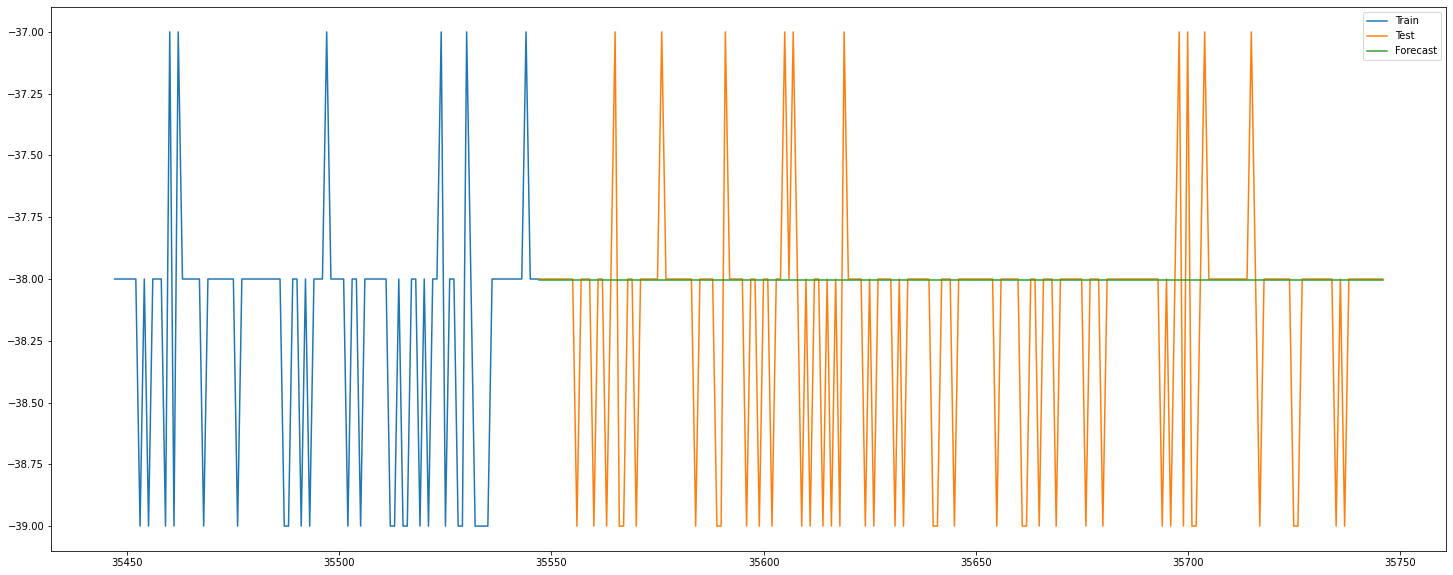

In [72]:
plt.figure(figsize=(25,10))

plt.plot(dfOriginal.iloc[35447:, :])
plt.plot(dfOriginalTest.iloc[:200, :])

plt.legend(['Train', 'Test', 'Forecast'])
plt.show()

De acordo com a figura acima, percebemos que a linha do Forecast se manteve em tendencia uniforme para o modelo LSTM Multivariate.

#### Outros testes LSTM (Univariate)

No modelo a seguir iremos utilizar todos os métodos que ja foram desenvolvidos e explicados acima para gerar um novo modelo para um único atributo e assim comparar os resultados a fim de entender a relevância que os atributos escolhidos influenciam no resultado final.

In [73]:
df_LSTMSingle = pd.read_csv('Dataset/FinalOutput.csv', index_col=0)
df_LSTMSingle
df_LSTMSingle = df_LSTMSingle.drop(['TIMESTAMP','EPC','MIN','MAX','MEAN','COUNT'], axis=1)
dfValuesSingle = df_LSTMSingle.values
dfValuesSingle = dfValuesSingle.astype('float32')
dfValuesSingle

array([[-38.],
       [-38.],
       [-36.],
       ...,
       [-37.],
       [-38.],
       [-38.]], dtype=float32)

In [74]:
dfSingle = series_to_supervised(dfValuesSingle, n_in=30, n_out=10, dropnan=True)
dfSingle.head()

var1(t-30)  var1(t-29)  var1(t-28)  ...  var1(t+7)  var1(t+8)  var1(t+9)
30       -38.0       -38.0       -36.0  ...      -37.0      -38.0      -38.0
31       -38.0       -36.0       -38.0  ...      -38.0      -38.0      -39.0
32       -36.0       -38.0       -38.0  ...      -38.0      -39.0      -37.0
33       -38.0       -38.0       -38.0  ...      -39.0      -37.0      -37.0
34       -38.0       -38.0       -37.0  ...      -37.0      -37.0      -38.0

[5 rows x 40 columns]

In [75]:
X = np.array(dfSingle)[:, :30]
print ('Atributos (%d x %d):' % (X.shape[0],X.shape[1]))
print (X)
y = np.array(dfSingle)[:,30:]
print ('Classe (%d x %d):' % (y.shape[0],y.shape[1]))
print (y)

Atributos (44436 x 30):
[[-38. -38. -36. ... -38. -38. -38.]
 [-38. -36. -38. ... -38. -38. -38.]
 [-36. -38. -38. ... -38. -38. -38.]
 ...
 [-38. -36. -37. ... -37. -36. -37.]
 [-36. -37. -36. ... -36. -37. -37.]
 [-37. -36. -36. ... -37. -37. -37.]]
Classe (44436 x 10):
[[-38. -38. -38. ... -37. -38. -38.]
 [-38. -38. -37. ... -38. -38. -39.]
 [-38. -37. -38. ... -38. -39. -37.]
 ...
 [-37. -37. -37. ... -36. -37. -37.]
 [-37. -37. -37. ... -37. -37. -38.]
 [-37. -37. -38. ... -37. -38. -38.]]


In [76]:
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
X_N = scalerX.fit_transform(X)
y_N = scalerY.fit_transform(y)

print('Tamanho do Dataset: ', X_N.shape[0])
print('Quantidade de Períodos (Atributos): ', X_N.shape[1])
print('Quantidade de Períodos (Classe): ', y_N.shape[1])

Tamanho do Dataset:  44436
Quantidade de Períodos (Atributos):  30
Quantidade de Períodos (Classe):  10


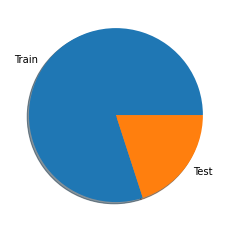

Atributos - Train:  (35548, 30)
Atributos - Test: (8888, 30)
Classes - Train:  (35548, 10)
Classes - Test: (8888, 10)


In [77]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X_N, y_N, test_size=0.2, shuffle=False, random_state=100)

plt.pie([X_Train.shape[0],X_Test.shape[0]], labels=['Train','Test'], shadow=True)
plt.show()

print('Atributos - Train: ', X_Train.shape)
print('Atributos - Test:', X_Test.shape)

print('Classes - Train: ', y_Train.shape)
print('Classes - Test:', y_Test.shape)

In [78]:
X_Train = X_Train.reshape((X_Train.shape[0], 30, 1))
X_Test = X_Test.reshape((X_Test.shape[0], 30, 1))

print (X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape)

(35548, 30, 1) (8888, 30, 1) (35548, 10) (8888, 10)


Epoch 1/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0302 - val_loss: 0.0434
Epoch 2/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0267 - val_loss: 0.0435
Epoch 3/15
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0264 - val_loss: 0.0445
Epoch 4/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0445
Epoch 5/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0442
Epoch 6/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0439
Epoch 7/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0442
Epoch 8/15
8887/8887 [==============================] - 31s 3ms/step - loss: 0.0263 - val_loss: 0.0432
Epoch 9/15
8887/8887 [==============================] - 30s 3ms/step - loss: 0.0263 - val_loss: 0.0433
Epoch 10/15
8887/8887 [==============================] - 30s 3ms/step - l

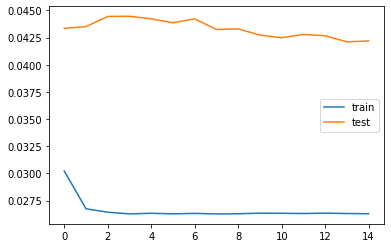

In [79]:
histSingle, modelSingle = fitModel(X_Train, y_Train, X_Test, y_Test, 64, 4, 15)

In [81]:
modelSingle.save('model_LSTM_Single.h5')

In [82]:
yPred = list()
for i in range (len(X_Test)):
  forecast = predict_lstm(modelSingle, X_Test[i], 1)
  yPred.append(forecast)

yPred

[[0.36368775,
  0.36389542,
  0.36313242,
  0.36349705,
  0.36369723,
  0.36349094,
  0.36353123,
  0.36408067,
  0.36350796,
  0.36382332],
 [0.36366934,
  0.3638849,
  0.36312425,
  0.36347196,
  0.3636989,
  0.36350232,
  0.363529,
  0.3640536,
  0.36350372,
  0.36379293],
 [0.36363417,
  0.3638648,
  0.36310866,
  0.36342403,
  0.36370212,
  0.3635241,
  0.36352473,
  0.36400193,
  0.36349565,
  0.36373487],
 [0.36362547,
  0.36385983,
  0.3631048,
  0.36341217,
  0.3637029,
  0.3635295,
  0.36352366,
  0.36398914,
  0.36349365,
  0.3637205],
 [0.36359575,
  0.36384284,
  0.36309162,
  0.36337167,
  0.3637056,
  0.36354786,
  0.36352006,
  0.36394548,
  0.36348683,
  0.36367148],
 [0.36359146,
  0.3638404,
  0.3630897,
  0.36336583,
  0.363706,
  0.3635505,
  0.36351955,
  0.3639392,
  0.36348584,
  0.36366442],
 [0.36358863,
  0.36383876,
  0.36308846,
  0.36336195,
  0.36370626,
  0.3635523,
  0.3635192,
  0.363935,
  0.3634852,
  0.3636597],
 [0.36361083,
  0.36385146,
  0.36309

In [83]:
yTest = [row[:] for row in y_Test]
yTest

[array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.3636365 , 0.27272725, 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.3636365 , 0.27272725, 0.3636365 , 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.3636365 , 0.27272725, 0.3636365 , 0.3636365 , 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 ,
        0.27272725, 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.3636365 , 0.3636365 , 0.27272725,
        0.3636365 , 0.3636365 , 0.3636365 , 0.27272725, 0.3636365 ],
       dtype=float32),
 array([0.3636365 , 0.3636365 , 0.363636

In [84]:
for i in range(10):
  actuals = [row[i] for row in yTest]
  predicted = [forecast[i] for forecast in yPred]
  rmse = sqrt(mean_squared_error(actuals, predicted))
  print('t+%d RMSE: %f' % ((i+1), rmse))

t+1 RMSE: 0.069874
t+2 RMSE: 0.069513
t+3 RMSE: 0.069881
t+4 RMSE: 0.070471
t+5 RMSE: 0.069580
t+6 RMSE: 0.069055
t+7 RMSE: 0.069594
t+8 RMSE: 0.070270
t+9 RMSE: 0.069872
t+10 RMSE: 0.070121


In [85]:
iforecasts = inverse_transform(yPred, scalerY)
iforecasts

[array([-37.999435, -37.99715 , -38.005543, -38.001534, -37.999332,
        -38.0016  , -38.00116 , -37.995113, -38.00141 , -37.997944],
       dtype=float32),
 array([-37.999638, -37.997265, -38.005634, -38.00181 , -37.999313,
        -38.001476, -38.001183, -37.99541 , -38.00146 , -37.99828 ],
       dtype=float32),
 array([-38.000027, -37.997486, -38.005806, -38.002335, -37.99928 ,
        -38.001236, -38.00123 , -37.99598 , -38.00155 , -37.998917],
       dtype=float32),
 array([-38.00012 , -37.997543, -38.005848, -38.00247 , -37.99927 ,
        -38.00118 , -38.00124 , -37.99612 , -38.00157 , -37.999077],
       dtype=float32),
 array([-38.000446, -37.997726, -38.005993, -38.002914, -37.999237,
        -38.000977, -38.001278, -37.9966  , -38.001648, -37.999615],
       dtype=float32),
 array([-38.000496, -37.997757, -38.006012, -38.002975, -37.999233,
        -38.000946, -38.001286, -37.99667 , -38.001656, -37.99969 ],
       dtype=float32),
 array([-38.000526, -37.997776, -38.0060

In [86]:
iyTest = inverse_transform(yTest, scalerY)
iyTest

[array([-38., -38., -38., -38., -38., -38., -38., -38., -38., -39.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -38., -38., -39., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -38., -39., -38., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -38., -39., -38., -38., -38.],
       dtype=float32),
 array([-38., -38., -38., -38., -38., -39., -38., -38., -38., -39.],
       dtype=float32),
 array([-38., -38., -38., -38., -39., -38., -38., -38., -39., -38.],
       dtype=float32),
 array([-38., -38., -38., -39., -38., -38., -38., -39., -38., -38.],
       dtype=float32),
 array([-38., -38., -39., -38., -38., -38., -39., -38., -38., -39.],
       dtype=float32),
 array([-38., -39., -38., -38., -38., -39., -38., -38., -39., -38.],
       dtype=float32),
 array([-39., -38., -38., -38., -39., -38., -38., -39., -38., -37.],
       dtype=float32),
 array([-38., -38., -38., -39., -38., -38., -39., -38., -37., -39.],
       dtyp

In [87]:
iyTrain = inverse_transform(y_Train, scalerY)
iyTrain

[array([-38., -38., -38., -37., -38., -38., -38., -37., -38., -38.],
       dtype=float32),
 array([-38., -38., -37., -38., -38., -38., -37., -38., -38., -39.],
       dtype=float32),
 array([-38., -37., -38., -38., -38., -37., -38., -38., -39., -37.],
       dtype=float32),
 array([-37., -38., -38., -38., -37., -38., -38., -39., -37., -37.],
       dtype=float32),
 array([-38., -38., -38., -37., -38., -38., -39., -37., -37., -38.],
       dtype=float32),
 array([-38., -38., -37., -38., -38., -39., -37., -37., -38., -38.],
       dtype=float32),
 array([-38., -37., -38., -38., -39., -37., -37., -38., -38., -38.],
       dtype=float32),
 array([-37., -38., -38., -39., -37., -37., -38., -38., -38., -38.],
       dtype=float32),
 array([-38., -38., -39., -37., -37., -38., -38., -38., -38., -38.],
       dtype=float32),
 array([-38., -39., -37., -37., -38., -38., -38., -38., -38., -38.],
       dtype=float32),
 array([-39., -37., -37., -38., -38., -38., -38., -38., -38., -38.],
       dtyp

In [88]:
iforecasts = [row[:1] for row in iforecasts]
iyTest = [row[:1] for row in iyTest]
iyTrain = [row[:1] for row in iyTrain] 

iyTrain=np.array(iyTrain).reshape(-1)
iyTest=np.array(iyTest).reshape(-1)
iforecasts=np.array(iforecasts).reshape(-1)

In [89]:
dfOriginalSingle = pd.DataFrame(iyTrain, columns=['TRAIN'])
dfOriginalSingle

TRAIN
0      -38.0
1      -38.0
2      -38.0
3      -37.0
4      -38.0
...      ...
35543  -38.0
35544  -37.0
35545  -38.0
35546  -38.0
35547  -38.0

[35548 rows x 1 columns]

In [90]:
dfOriginalTestSingle = pd.DataFrame(iyTest, columns=['TEST'])
dfOriginalTestSingle.index = np.arange(len(dfOriginalSingle)-1, len(dfOriginalTestSingle)+len(dfOriginalSingle)-1)
dfOriginalTestSingle

TEST
35547 -38.0
35548 -38.0
35549 -38.0
35550 -38.0
35551 -38.0
...     ...
44430 -36.0
44431 -37.0
44432 -37.0
44433 -37.0
44434 -37.0

[8888 rows x 1 columns]

In [91]:
dftempor = pd.DataFrame(iforecasts, columns=['FORECAST'])
dftempor.index = dfOriginalTestSingle.index
dfOriginalTestSingle['FORECAST'] = dftempor['FORECAST']
dfOriginalTestSingle

TEST   FORECAST
35547 -38.0 -37.999435
35548 -38.0 -37.999638
35549 -38.0 -38.000027
35550 -38.0 -38.000118
35551 -38.0 -38.000446
...     ...        ...
44430 -36.0 -37.991978
44431 -37.0 -37.981354
44432 -37.0 -37.985592
44433 -37.0 -37.982487
44434 -37.0 -37.987549

[8888 rows x 2 columns]

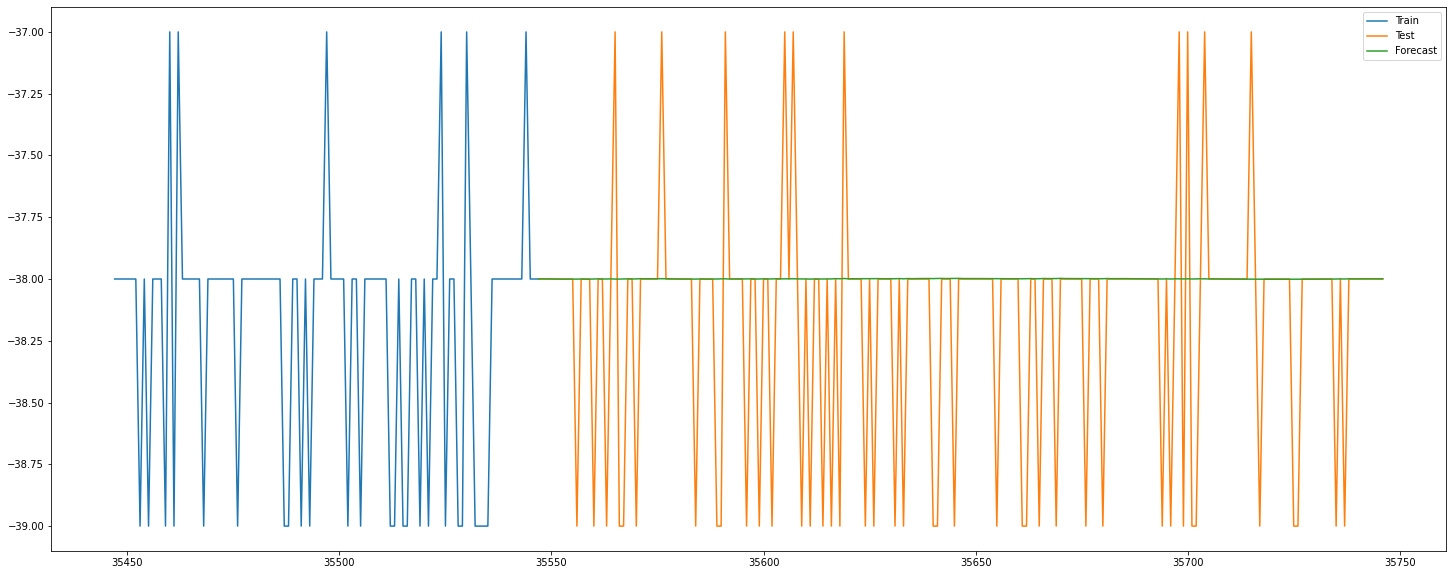

In [92]:
plt.figure(figsize=(25,10))

plt.plot(dfOriginalSingle.iloc[35447:, :])
plt.plot(dfOriginalTestSingle.iloc[:200, :])

plt.legend(['Train', 'Test', 'Forecast'])
plt.show()

#### Conclusão LSTM

Em relação aos dois modelos LSTM que utilizamos percebemos que não existem muitas diferenças entre eles, ou seja, o uso de todos os atributos não melhorou o modelo de forma significativa. A natureza dos dados coletados são uniformes, como vistos na analise estatísticas o que justifica essa mínima diferença entre os dois.

Quanto a predição estar próxima dos -38 pode ser pelo fato da maioria dos dados de treino estarem dentro desse intervalo, como observado no histograma abaixo.

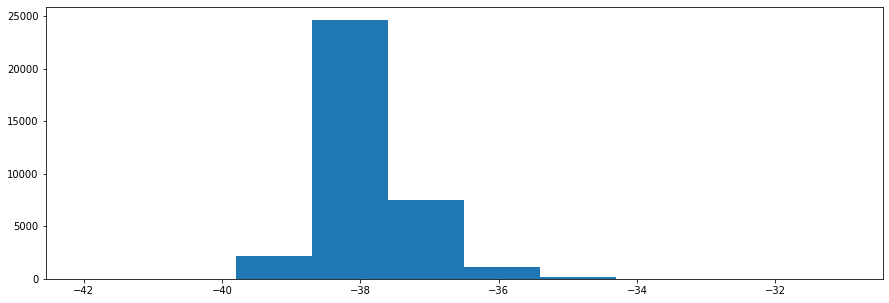

In [93]:
plt.figure(figsize=(15,5))
plt.hist(iyTrain, cumulative=False)
plt.show()

Um ensaio foi feito apresentando para o modelo (utilizado o univariate) novos valores simulando uma condição de problema.

In [121]:
NovaEntrada = np.array([[-60,-60,-60,-62,-62,-62,-62,-62,-55,-55,-55,-55,-55,-53,-53,-53,-53,-53,-53,-53,-60,-60,-60,-60,-60,-60,-62,-62,-62,-62]])
NovaEntrada.shape

(1, 30)

In [122]:
NovaEntrada = scalerX.transform(NovaEntrada.reshape(1,30))
NovaEntrada

array([[-1.63636363, -1.63636363, -1.63636363, ..., -1.81818181,
        -1.81818181, -1.81818181]])

In [123]:
pred = predict_lstm(modelSingle, NovaEntrada.reshape(30,1), 1)
pred

[0.41971892,
 0.55843335,
 0.33050498,
 0.4434513,
 0.3736791,
 0.2494572,
 0.3370798,
 0.4736527,
 0.5341856,
 0.5657874]

In [124]:
pred = scalerY.inverse_transform(np.array(pred).reshape(1,10))

In [125]:
pred

array([[-37.38309 , -35.857235, -38.36445 , -37.122036, -37.88953 ,
        -39.255974, -38.29212 , -36.78982 , -36.12396 , -35.77634 ]],
      dtype=float32)

Muitos resultados demonstraram um comportamento fora do padrão aceitável para o processo de validação na linha de produção que seria entre -37 e -39. Significa que através dessa predição o sistema poderia identificar um comportamento inaceitável.

### Prophet

O modelo de previsão base do Prophet utiliza a equação abaixo:<br>
y(t) = g(t) + h(t) + s(t) + et

Onde:<br>
g(t): função de tendência, que no Prophet pode ser linear ou logístico<br><br>
s(t): sazonalidade, que neste caso são períodos específicos de tempo que podem afetar a tendência e por padrão são desativados no Prophet<br><br>
h(t): ciclos do ano, que são os "feriados", os quais possuem uma listagem no Prophet específica por país e por padrão não são considerados no modelo<br><br>
et: erro da previsão, que é tratado como distribuição gausiana no Prophet<br><br>
O modelo do Prophet se baseia em uma análise univariada, sendo que os únicos parâmetros recebidos são o espaço de tempo (ds) e y(t) VALIDATION.

In [126]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [128]:
df_original = pd.read_csv('Dataset/FinalOutput.csv', index_col=0)
df_original.tail()

TIMESTAMP  ... COUNT
49650  1559310373087455  ...    60
49651  1559310373347245  ...    57
49652  1559310373608031  ...    54
49653  1559310373860986  ...    60
49654  1559310374120188  ...    56

[5 rows x 7 columns]

O Prophet requer um dataframe contendo as colunas ds (datastamp) e y (classe).
A coluna ds requer algum tipo de time stamp reconhecido pelo Pandas para poder treinar de maneira adequada.
Neste caso, criou-se um range com data de inicio arbitraria, um tamanho igual ao tamanho do dataframe original e um incremento de um milissegundo. 

In [129]:
time_index = pd.date_range(start='1/1/2019', periods=df_original.shape[0],freq='ms') # criação de série com time stamp com incremento de 1 ms
min_period = 0 # ponto inicial da análise do dataframe
max_period = df_original.shape[0] # ponto final da análise do dataframe

O novo dataset foi criado, mantendo-se apenas as colunas VALIDATION e TIMESTAMP do dataset original.
Conforme necessário pelo Prophet, a coluna VALIDATION foi renomeada para y e a coluna TIMESTAMP foi renomeada para ds.

In [130]:
df_Prophet = df_original.drop(['EPC','MIN','MAX','MEAN','COUNT'], axis=1) # Remoção das colunas EPC, MIN, MAX e COUNT

df_Prophet = df_Prophet.rename(columns={'VALIDATION': 'y','TIMESTAMP':'ds'}) # Coluna VALIDATION renomeada para y e coluna TIMESTAMP renomeada para ds
df_Prophet.head()

ds     y
0  1559288006669161 -38.0
1  1559288006411266 -38.0
2  1559288006208139 -36.0
3  1559288005894531 -38.0
4  1559288005639682 -38.0

Como haviam inconsistências no index do dataset, reiniciaram-se os valores, deixando assim o incremento contínuo.

In [131]:
df_Prophet.index = pd.RangeIndex(0,df_Prophet.shape[0]) # Reset dos índices do dataframe com índice inicial 0
df_Prophet

ds     y
0      1559288006669161 -38.0
1      1559288006411266 -38.0
2      1559288006208139 -36.0
3      1559288005894531 -38.0
4      1559288005639682 -38.0
...                 ...   ...
44470  1559310373087455 -36.0
44471  1559310373347245 -37.0
44472  1559310373608031 -37.0
44473  1559310373860986 -38.0
44474  1559310374120188 -38.0

[44475 rows x 2 columns]

Os valores da coluna ds foram sobrescritos com a série de tempo com incremento de um milissegundo criada.

In [132]:
df_Prophet['ds'] = time_index
df_Prophet.head()

ds     y
0 2019-01-01 00:00:00.000 -38.0
1 2019-01-01 00:00:00.001 -38.0
2 2019-01-01 00:00:00.002 -36.0
3 2019-01-01 00:00:00.003 -38.0
4 2019-01-01 00:00:00.004 -38.0

In [133]:
df_window = df_Prophet.iloc[min_period:max_period,:]
df_window

ds     y
0     2019-01-01 00:00:00.000 -38.0
1     2019-01-01 00:00:00.001 -38.0
2     2019-01-01 00:00:00.002 -36.0
3     2019-01-01 00:00:00.003 -38.0
4     2019-01-01 00:00:00.004 -38.0
...                       ...   ...
44470 2019-01-01 00:00:44.470 -36.0
44471 2019-01-01 00:00:44.471 -37.0
44472 2019-01-01 00:00:44.472 -37.0
44473 2019-01-01 00:00:44.473 -38.0
44474 2019-01-01 00:00:44.474 -38.0

[44475 rows x 2 columns]

#### Prophet com crescimento linear
O termo g(t) é o modelo de tendência do modelo de regressão aditiva utilizado pelo Prophet, ele pode ter modelo de crescimento linear ou logístico. <br>
Para este primeiro teste realizado, aplicou-se o modelo linear, que necessita de um dataset com ds (date stamp) e y (valor análisado).<br>
O modelo linear gera uma têndencia de crescimento linear, sendo que esta pode ser de crescimento positivo ou negativo.<br>
O modelo linear não é capaz de lidar com alterações de tendência ou saturação de crescimento.

Para se manter os parâmetros similares entre os modelos LSTM e Prophet, realizou-se a divisão do dataset entre treino e teste com a proporção de 80% e 20%, sem modo shuffle e com  semente aleatória 100

In [134]:
df_train, df_test = train_test_split(df_window, test_size=0.2, shuffle=False, random_state=100)

print (df_train.shape, df_test.shape)

train_size = df_train.shape[0]
test_size = df_test.shape[0]

(35580, 2) (8895, 2)


Outra prática adotada para que as métricas de avaliação pudessem ser comparadas foi o escalonamento do dataset de treino com valor de 0 a 1 (mínimo e máximo), com escalonador treinado sendo utilizado posteriormente para o dataset de previsão e de teste.

In [135]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[['y']])
df_train['y'] = scaler.transform(df_train[['y']])

df_train.head()

ds         y
0 2019-01-01 00:00:00.000  0.363636
1 2019-01-01 00:00:00.001  0.363636
2 2019-01-01 00:00:00.002  0.545455
3 2019-01-01 00:00:00.003  0.363636
4 2019-01-01 00:00:00.004  0.363636

Para a análise, instanciou-se um modelo Prophet e realizou o **método fit** do modelo utilizando como parâmetro o dataset de treino.<br>
Após o método fit, gerou-se um novo dataset, chamado de **future**, com o método make_future_dataframe. Este médoto recebe como parâmetro a quantidade de unidades futuras a se gerar e qual a frequência temporal considerada.<br>
Neste caso, utilizou-se uma quantidade igual ao tamanho do dataset de teste, para que seja possível realizar a comparação dos valores reais e previstos. Outro parâmetro utilizado foi a frequência em milissegundos.<br>
O dataset future gerado tem o mesmo tamanho do dataset original e possui apenas a coluna ds (date stamp), com a série temporal do dataset de treino mais o número de previsões futuras.<br><br>
Após a criação do dataset future, gerou-se o dataset de previsão (**forecast**), que é gerado a partir do método predict do modelo, passando como parâmetro o dataset future.

In [136]:
model = Prophet()
model.fit(df_train)
future = model.make_future_dataframe(periods=test_size, freq='ms')
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Após a realização da previsão dos dados futuros, gerou-se o gráfico com a apresentação dos resultados e o gráfico com os valores de treino mais a tendência gerada com seu intervalo de incerteza.<br>
No primeiro gráfico, pode-se observar a **linha sólida vermelha** como a tendência do modelo gerado, os **pontos pretos** distribuidos são os valores do dataset de treino original, as **linhas pontilhadas vermelhas verticais** são os pontos de mudança de tendência identificados e a **faixa azul clara** em torno da tendência são o intervalo de incerteza.<br>
No segundo gráfico, pode-se observar a linha de tendência gerada pelo modelo e o intervalo de incerteza da previsão futura gerada.

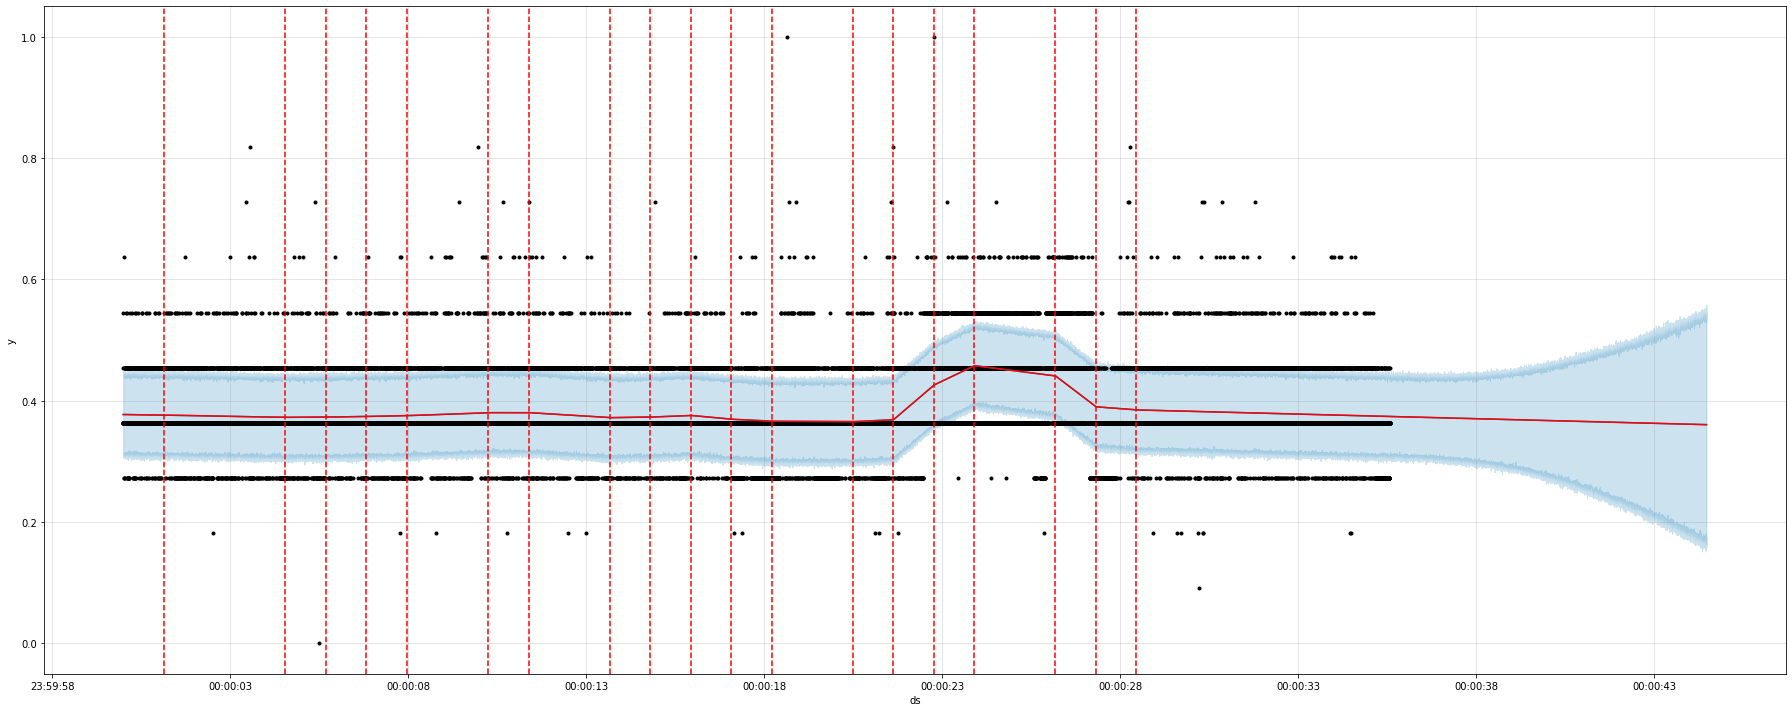

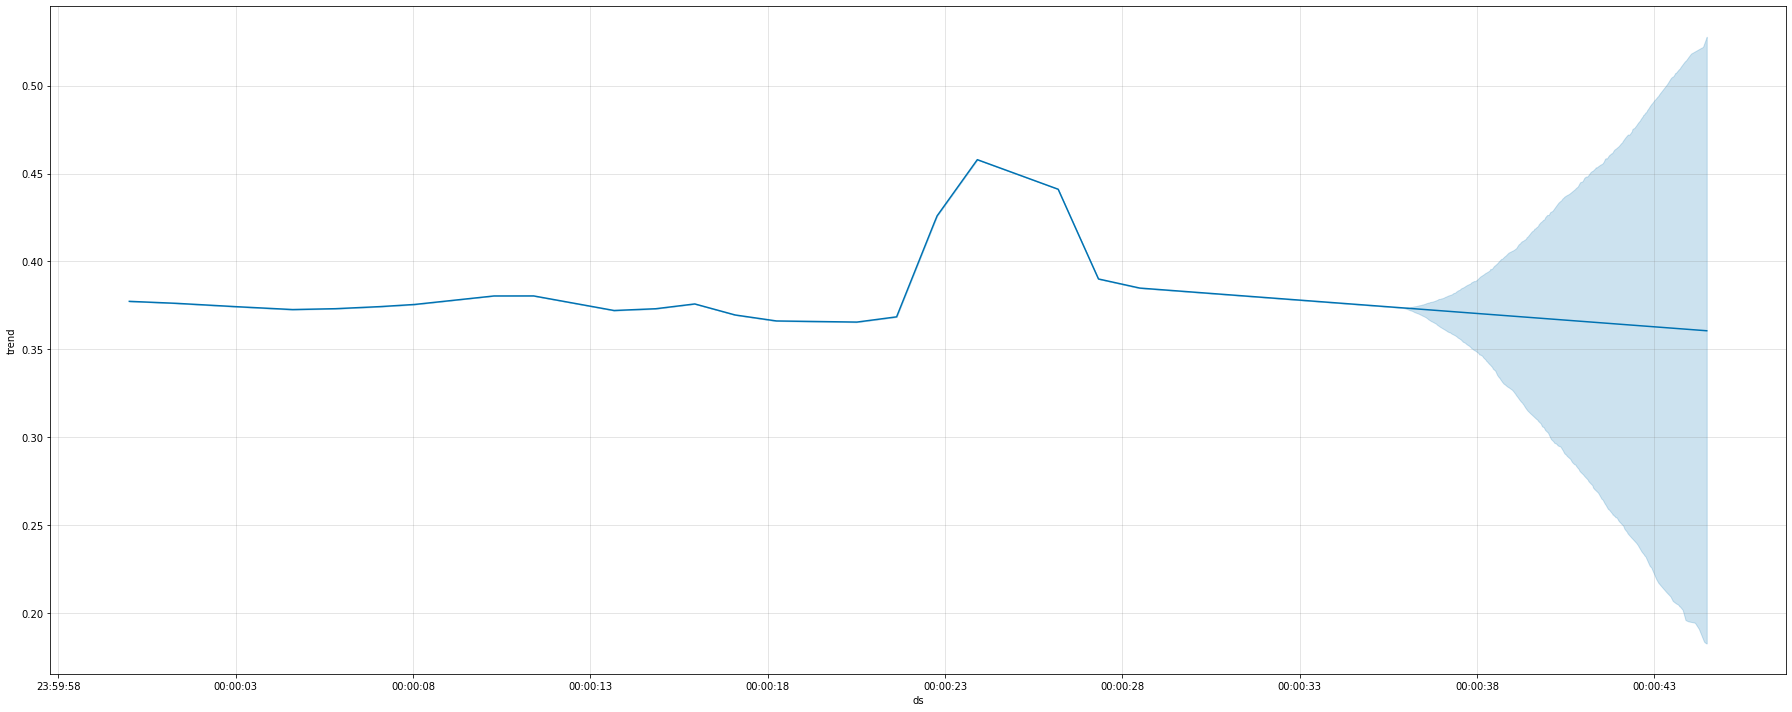

In [137]:
fig = model.plot(forecast,figsize=(25,10))
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig2 = model.plot_components(forecast,figsize=(25,10))
plt.show()

Para poder se avaliar a métrica da raíz do erro quadrático médio, escalonou-se também o dataset de teste, utilizando o escalonador gerado com o dataset de treino.

In [138]:
df_test_2 = df_test.copy()
df_test_2['y'] = scaler.transform(df_test[['y']])
df_test_2.head()

ds         y
35580 2019-01-01 00:00:35.580  0.363636
35581 2019-01-01 00:00:35.581  0.363636
35582 2019-01-01 00:00:35.582  0.363636
35583 2019-01-01 00:00:35.583  0.363636
35584 2019-01-01 00:00:35.584  0.363636

A métrica foi gerada a partir de um modelo treinado com valor escalonado a de 0 a 1, tornado-se possível realizar a comparação entre o resultado do modelo LSTM, pois ambos estão na mesma escala. 

In [140]:
rmse = sqrt(mean_squared_error(df_test_2.iloc[:,1], forecast.iloc[-df_test.shape[0]:,-1]))
print('RMSE: %f' % rmse)

RMSE: 0.069338


Para poder se exibir a distribuição dos valores reais com os valores previstos, geraram-se datasets adicionais, baseados nos datasets de treino, teste e previsão, com índices similares para facilitar a distribuição, além de os valores de y terem sido desescalonados, mostrando assim os valores na grandeza original.

In [141]:
df_train_show = df_train.copy()
df_train_show.index = pd.RangeIndex(0,df_train.shape[0]) # reseta index
df_test_show = df_test_2.copy()
df_test_show.index = pd.RangeIndex(df_train.shape[0],df_train.shape[0]+df_test.shape[0]) # reseta index

df_train_show['y'] = scaler.inverse_transform(df_train_show[['y']])
df_test_show['y'] = scaler.inverse_transform(df_test_show[['y']])

forecast_show = forecast.copy()
forecast_show['yhat'] = scaler.inverse_transform(forecast_show[['yhat']])

Pode-se observar no gráfico gerado, em azul uma distribuição dos valores de treino, em laranja os valores de teste e em verde os valores de teste previstos.<br>
Pode-se observar que o modelo linear gerou uma previsão com aspecto horizontal, demonstrando pouco ou nenhum crescimento (positivo ou negativo) dentro da faixa observada.

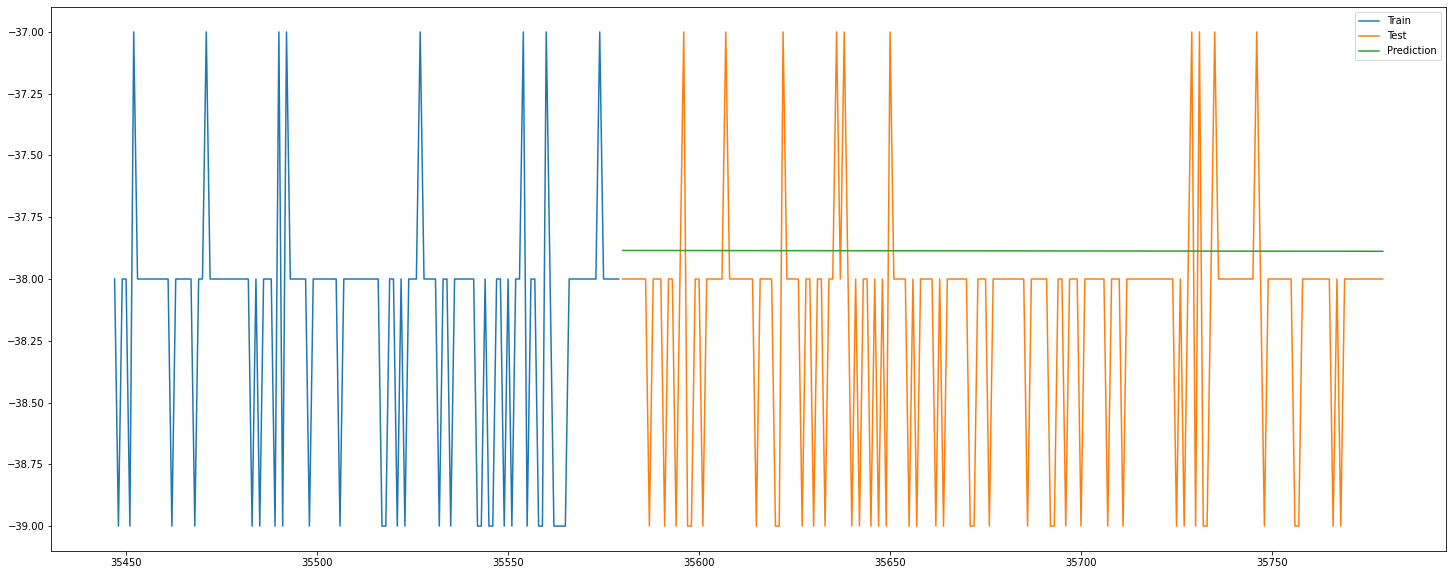

In [144]:
plt.figure(figsize=(25,10))

plt.plot(df_train_show.iloc[35447:,1])
plt.plot(df_test_show.iloc[:200,1])
plt.plot(forecast_show.iloc[df_test_show.index[0]:df_test_show.index[0]+200,-1])

plt.legend(['Train','Test','Prediction'])

plt.show()

#### Prophet com crescimento logístico

Para o segundo cenário análisado, utilizou-se o modelo de **crescimento logístico**, sendo que este modelo é utilizado quando há a mudança de tendência, de crescimento para decaimento e vice-versa e quando o crescimento é não-linear com saturação.<br>
Este modelo precisa receber adicionalmente, além de ds (data stamp) e y (VALIDATION), os valores de **cap** (limite superior de saturação da tendência) e **floor** (limite inferior de saturação da tendência).<br>
O dataset precisa ter um valor de cap e um de floor para cada observação registrada, podendo ser igual para toda a série ou variável para cada observação.<br>
Estes limites devem ser aplicados, pois o modelo logístico considera que a tendência não deve seguir ao infinito, tendo assim um limite inferior e superior.<br>
O crescimento não linear do modelo logístico se inicia com um crescimento aproximadamente exponencial, quando a saturação se inicia, o crescimento passa por uma tendência linear e no estágio de maturidade, o crescimento para.

##### *Prophet com crescimento logístico, RSSI max como cap e RSSI min como floor*

Para o primeiro teste com modelo de crescimento logístico, utilizou-se os valores de RSSI máximo (MAX) e mínimo (MIN) registrado para cada tag de RFID lida como o valor de cap e floor.<br>
Para o dataset criado, mantiveram-se as colunas de VALIDATION, TIMESTAMP, MIN e MAX, sendo que eles foram renomeados para y, ds, floor e cap respectivamente.

In [145]:
df_Prophet = df_original.drop(['EPC','MEAN','COUNT'], axis=1)

df_Prophet = df_Prophet.rename(columns={'VALIDATION': 'y','TIMESTAMP':'ds','MIN':'floor','MAX':'cap'})
df_Prophet.head()

ds     y  floor  cap
0  1559288006669161 -38.0    -53  -37
1  1559288006411266 -38.0    -52  -36
2  1559288006208139 -36.0    -46  -35
3  1559288005894531 -38.0    -53  -36
4  1559288005639682 -38.0    -56  -36

Como haviam inconsistências no index do dataset, reiniciaram-se os valores, deixando assim o incremento contínuo.

In [146]:
df_Prophet.index = pd.RangeIndex(0,df_Prophet.shape[0])
df_Prophet

ds     y  floor  cap
0      1559288006669161 -38.0    -53  -37
1      1559288006411266 -38.0    -52  -36
2      1559288006208139 -36.0    -46  -35
3      1559288005894531 -38.0    -53  -36
4      1559288005639682 -38.0    -56  -36
...                 ...   ...    ...  ...
44470  1559310373087455 -36.0    -57  -35
44471  1559310373347245 -37.0    -57  -34
44472  1559310373608031 -37.0    -55  -34
44473  1559310373860986 -38.0    -57  -34
44474  1559310374120188 -38.0    -55  -34

[44475 rows x 4 columns]

Os valores da coluna ds foram sobrescritos com a série de tempo com incremento de um milissegundo criada.

In [147]:
df_Prophet['ds'] = time_index
df_Prophet.head()

ds     y  floor  cap
0 2019-01-01 00:00:00.000 -38.0    -53  -37
1 2019-01-01 00:00:00.001 -38.0    -52  -36
2 2019-01-01 00:00:00.002 -36.0    -46  -35
3 2019-01-01 00:00:00.003 -38.0    -53  -36
4 2019-01-01 00:00:00.004 -38.0    -56  -36

In [148]:
df_window = df_Prophet.iloc[min_period:max_period,:]
df_window

ds     y  floor  cap
0     2019-01-01 00:00:00.000 -38.0    -53  -37
1     2019-01-01 00:00:00.001 -38.0    -52  -36
2     2019-01-01 00:00:00.002 -36.0    -46  -35
3     2019-01-01 00:00:00.003 -38.0    -53  -36
4     2019-01-01 00:00:00.004 -38.0    -56  -36
...                       ...   ...    ...  ...
44470 2019-01-01 00:00:44.470 -36.0    -57  -35
44471 2019-01-01 00:00:44.471 -37.0    -57  -34
44472 2019-01-01 00:00:44.472 -37.0    -55  -34
44473 2019-01-01 00:00:44.473 -38.0    -57  -34
44474 2019-01-01 00:00:44.474 -38.0    -55  -34

[44475 rows x 4 columns]

Para se manter os parâmetros similares entre os modelos LSTM e Prophet, realizou-se a divisão do dataset entre treino e teste com a proporção de 80% e 20%, sem modo shuffle e com  semente aleatória 100.

In [149]:
df_train, df_test = train_test_split(df_window, test_size=0.2, shuffle=False, random_state=100)

print (df_train.shape, df_test.shape)

train_size = df_train.shape[0]
test_size = df_test.shape[0]

(35580, 4) (8895, 4)


Outra prática adotada para que as métricas de avaliação pudessem ser comparadas foi o escalonamento do dataset de treino com valor de 0 a 1 (mínimo e máximo), com escalonador treinado sendo utilizado posteriormente para o dataset de previsão e de teste.

In [150]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[['y']])
df_train['y'] = scaler.transform(df_train[['y']])

df_train.head()

ds         y  floor  cap
0 2019-01-01 00:00:00.000  0.363636    -53  -37
1 2019-01-01 00:00:00.001  0.363636    -52  -36
2 2019-01-01 00:00:00.002  0.545455    -46  -35
3 2019-01-01 00:00:00.003  0.363636    -53  -36
4 2019-01-01 00:00:00.004  0.363636    -56  -36

Para manter-se a proporcionalidade dos valores, os valores de cap e floor foram escalonados com o escalonador treinado com os valores de VALIDATION do dataset de treino.

In [151]:
df_train['cap'] = scaler.transform(df_train[['cap']])
df_train['floor'] = scaler.transform(df_train[['floor']])
df_train.head()

ds         y     floor       cap
0 2019-01-01 00:00:00.000  0.363636 -1.000000  0.454545
1 2019-01-01 00:00:00.001  0.363636 -0.909091  0.545455
2 2019-01-01 00:00:00.002  0.545455 -0.363636  0.636364
3 2019-01-01 00:00:00.003  0.363636 -1.000000  0.545455
4 2019-01-01 00:00:00.004  0.363636 -1.272727  0.545455

Utilizou-se um valor fixo para cap e floor, sendo que como valor, selecionou-se o maior valor de MAX e o menor valor de MIN.

In [152]:
df_train['cap'] = df_train['cap'].max()
df_train['floor'] = df_train['floor'].min()
df_train.head()

ds         y     floor       cap
0 2019-01-01 00:00:00.000  0.363636 -1.454545  1.272727
1 2019-01-01 00:00:00.001  0.363636 -1.454545  1.272727
2 2019-01-01 00:00:00.002  0.545455 -1.454545  1.272727
3 2019-01-01 00:00:00.003  0.363636 -1.454545  1.272727
4 2019-01-01 00:00:00.004  0.363636 -1.454545  1.272727

Na criação do dataset **future**, gerou-se os periodos de tempo futuro conforme o tamanho do dataset de teste e adicionaram-se também as colunas de cap e floor, utilizando-se os mesmos valores adotados como cap e floor fixos para o dataset de treino.

In [153]:
model = Prophet(growth='logistic')
model.fit(df_train)
future = model.make_future_dataframe(periods=test_size, freq='ms')
future['cap'] = df_train['cap'].max()
future['floor'] = df_train['floor'].min()
future

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       cap     floor
0     2019-01-01 00:00:00.000  1.272727 -1.454545
1     2019-01-01 00:00:00.001  1.272727 -1.454545
2     2019-01-01 00:00:00.002  1.272727 -1.454545
3     2019-01-01 00:00:00.003  1.272727 -1.454545
4     2019-01-01 00:00:00.004  1.272727 -1.454545
...                       ...       ...       ...
44470 2019-01-01 00:00:44.470  1.272727 -1.454545
44471 2019-01-01 00:00:44.471  1.272727 -1.454545
44472 2019-01-01 00:00:44.472  1.272727 -1.454545
44473 2019-01-01 00:00:44.473  1.272727 -1.454545
44474 2019-01-01 00:00:44.474  1.272727 -1.454545

[44475 rows x 3 columns]

O dataset de previsão (forecast) foi então gerado a partir do método predict do modelo treinado com crescimento logístico.

In [154]:
forecast = model.predict(future)

Após a realização da previsão dos dados futuros, gerou-se o gráfico com a apresentação dos resultados e o gráfico com os valores de treino mais a tendência gerada com seu intervalo de incerteza.<br>
No primeiro gráfico, pode-se observar a **linha sólida vermelha** como a tendência do modelo gerado, os **pontos pretos** distribuidos são os valores do dataset de treino original, as **linhas pontilhadas vermelhas verticais** são os pontos de mudança de tendência identificados e a **faixa azul clara** em torno da tendência são o intervalo de incerteza.<br>
No segundo gráfico, pode-se observar a linha de tendência gerada pelo modelo e o intervalo de incerteza da previsão futura gerada.

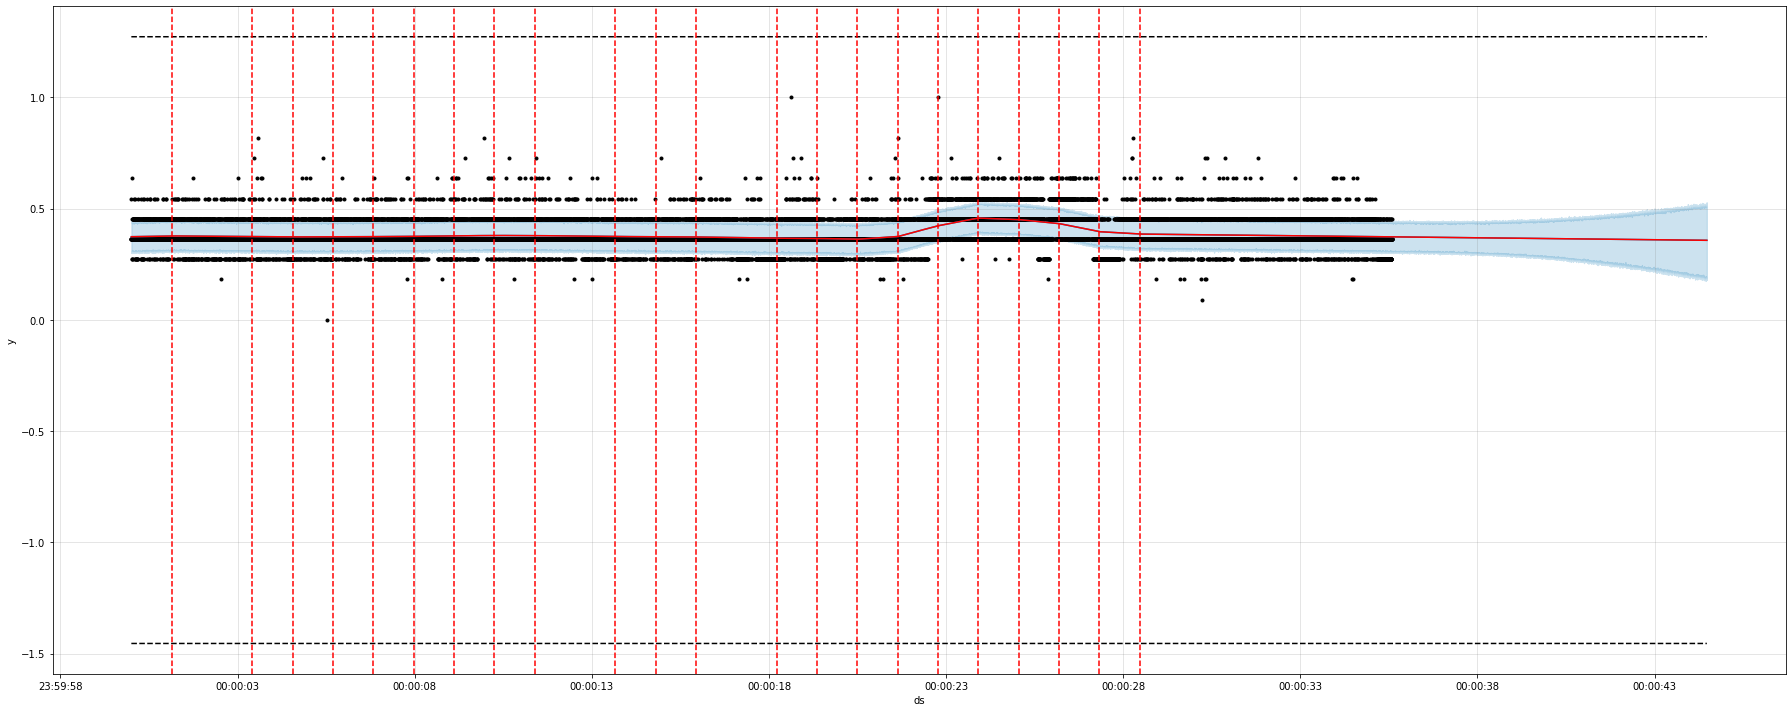

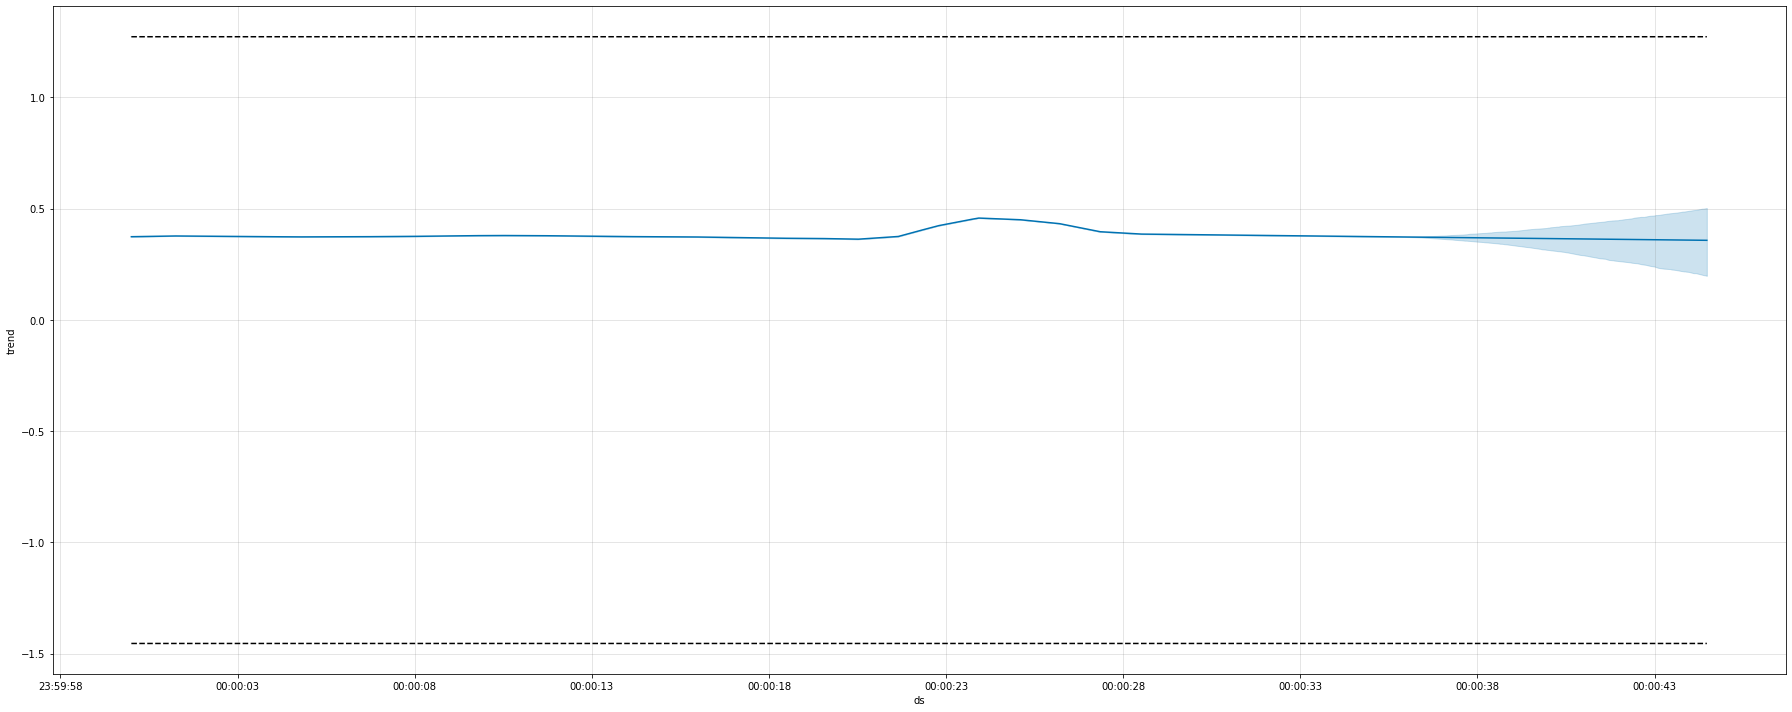

In [155]:
fig = model.plot(forecast,figsize=(25,10))
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig2 = model.plot_components(forecast,figsize=(25,10))
plt.show()

In [156]:
df_test['y'] = scaler.transform(df_test[['y']])
df_test.head()

ds         y  floor  cap
35580 2019-01-01 00:00:35.580  0.363636    -52  -36
35581 2019-01-01 00:00:35.581  0.363636    -55  -36
35582 2019-01-01 00:00:35.582  0.363636    -56  -37
35583 2019-01-01 00:00:35.583  0.363636    -50  -37
35584 2019-01-01 00:00:35.584  0.363636    -56  -37

In [158]:
rmse = sqrt(mean_squared_error(df_test.iloc[:,1], forecast.iloc[-df_test.shape[0]:,-1]))
print('RMSE: %f' % rmse)

RMSE: 0.069880


In [159]:
df_train_show = df_train.copy()
df_train_show.index = pd.RangeIndex(0,df_train.shape[0]) # reseta index
df_test_show = df_test.copy()
df_test_show.index = pd.RangeIndex(df_train.shape[0],df_train.shape[0]+df_test.shape[0]) # reseta index

df_train_show['y'] = scaler.inverse_transform(df_train_show[['y']])
df_test_show['y'] = scaler.inverse_transform(df_test_show[['y']])

forecast_show = forecast.copy()
forecast_show['yhat'] = scaler.inverse_transform(forecast_show[['yhat']])

Por fim, comparou-se o a distribuição dos dados dos valores reais e previstos da série.

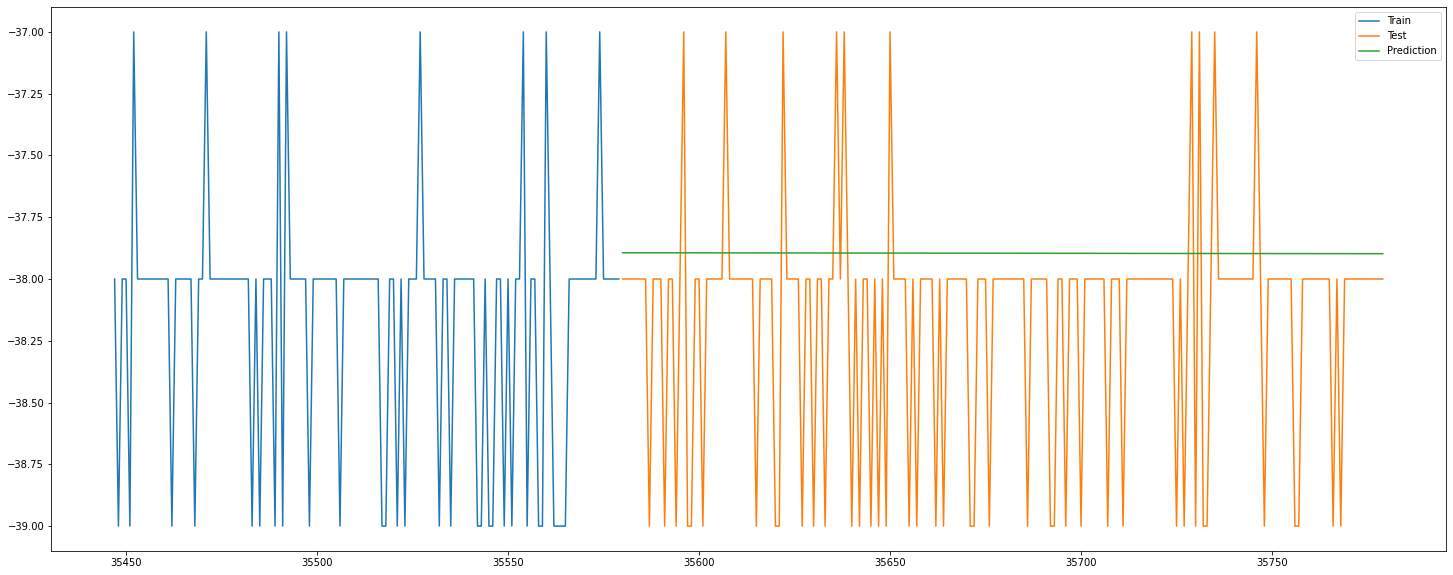

In [160]:
plt.figure(figsize=(25,10))

plt.plot(df_train_show.iloc[35447:,1])
plt.plot(df_test_show.iloc[:200,1])

plt.plot(forecast_show.iloc[df_test_show.index[0]:df_test_show.index[0]+200,-1])

plt.legend(['Train','Test','Prediction'])

plt.show()

##### *Prophet com crescimento logístico, VALIDATION max como cap e VALIDATION min como floor*

Para o segundo teste com modelo de crescimento logístico, utilizaram-se os valores de máximo e mínimo de VALIDATION para cap e floor registrado para cada tag de RFID.<br>
Para o dataset criado, mantiveram-se as colunas de VALIDATION, TIMESTAMP, MIN e MAX, sendo que eles foram renomeados para y, ds, floor e cap respectivamente.

In [161]:
df_Prophet = df_original.drop(['EPC','MEAN','COUNT'], axis=1)

df_Prophet = df_Prophet.rename(columns={'VALIDATION': 'y','TIMESTAMP':'ds','MIN':'floor','MAX':'cap'})
df_Prophet.head()

ds     y  floor  cap
0  1559288006669161 -38.0    -53  -37
1  1559288006411266 -38.0    -52  -36
2  1559288006208139 -36.0    -46  -35
3  1559288005894531 -38.0    -53  -36
4  1559288005639682 -38.0    -56  -36

Como haviam inconsistências no index do dataset, reiniciaram-se os valores, deixando assim o incremento contínuo.

In [162]:
df_Prophet.index = pd.RangeIndex(0,df_Prophet.shape[0])
df_Prophet

ds     y  floor  cap
0      1559288006669161 -38.0    -53  -37
1      1559288006411266 -38.0    -52  -36
2      1559288006208139 -36.0    -46  -35
3      1559288005894531 -38.0    -53  -36
4      1559288005639682 -38.0    -56  -36
...                 ...   ...    ...  ...
44470  1559310373087455 -36.0    -57  -35
44471  1559310373347245 -37.0    -57  -34
44472  1559310373608031 -37.0    -55  -34
44473  1559310373860986 -38.0    -57  -34
44474  1559310374120188 -38.0    -55  -34

[44475 rows x 4 columns]

Os valores da coluna ds foram sobrescritos com a série de tempo com incremento de um milissegundo criada.

In [163]:
df_Prophet['ds'] = time_index
df_Prophet.head()

ds     y  floor  cap
0 2019-01-01 00:00:00.000 -38.0    -53  -37
1 2019-01-01 00:00:00.001 -38.0    -52  -36
2 2019-01-01 00:00:00.002 -36.0    -46  -35
3 2019-01-01 00:00:00.003 -38.0    -53  -36
4 2019-01-01 00:00:00.004 -38.0    -56  -36

In [164]:
df_window = df_Prophet.iloc[min_period:max_period,:]
df_window

ds     y  floor  cap
0     2019-01-01 00:00:00.000 -38.0    -53  -37
1     2019-01-01 00:00:00.001 -38.0    -52  -36
2     2019-01-01 00:00:00.002 -36.0    -46  -35
3     2019-01-01 00:00:00.003 -38.0    -53  -36
4     2019-01-01 00:00:00.004 -38.0    -56  -36
...                       ...   ...    ...  ...
44470 2019-01-01 00:00:44.470 -36.0    -57  -35
44471 2019-01-01 00:00:44.471 -37.0    -57  -34
44472 2019-01-01 00:00:44.472 -37.0    -55  -34
44473 2019-01-01 00:00:44.473 -38.0    -57  -34
44474 2019-01-01 00:00:44.474 -38.0    -55  -34

[44475 rows x 4 columns]

Para se manter os parâmetros similares entre os modelos LSTM e Prophet, realizou-se a divisão do dataset entre treino e teste com a proporção de 80% e 20%, sem modo shuffle e com  semente aleatória 100.

In [165]:
df_train, df_test = train_test_split(df_window, test_size=0.2, shuffle=False, random_state=100)

print (df_train.shape, df_test.shape)

train_size = df_train.shape[0]
test_size = df_test.shape[0]

(35580, 4) (8895, 4)


Para os valores de cap e floor, utilizaram-se os valores máximo e mínimo de y(t) do dataset de treino.

In [166]:
df_train['cap'] = df_train['y'].max()
df_train['floor'] = df_train['y'].min()

Outra prática adotada para que as métricas de avaliação pudessem ser comparadas foi o escalonamento do dataset de treino com valor de 0 a 1 (mínimo e máximo), com escalonador treinado sendo utilizado posteriormente para o dataset de previsão e de teste.

In [167]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[['y']])
df_train['y'] = scaler.transform(df_train[['y']])

df_train.head()

ds         y  floor   cap
0 2019-01-01 00:00:00.000  0.363636  -42.0 -31.0
1 2019-01-01 00:00:00.001  0.363636  -42.0 -31.0
2 2019-01-01 00:00:00.002  0.545455  -42.0 -31.0
3 2019-01-01 00:00:00.003  0.363636  -42.0 -31.0
4 2019-01-01 00:00:00.004  0.363636  -42.0 -31.0

Para manter-se a proporcionalidade dos valores, os valores de cap e floor foram escalonados com o escalonador treinado com os valores de VALIDATION do dataset de treino.

In [168]:
df_train['cap'] = scaler.transform(df_train[['cap']])
df_train['floor'] = scaler.transform(df_train[['floor']])
df_train.head()

ds         y  floor  cap
0 2019-01-01 00:00:00.000  0.363636    0.0  1.0
1 2019-01-01 00:00:00.001  0.363636    0.0  1.0
2 2019-01-01 00:00:00.002  0.545455    0.0  1.0
3 2019-01-01 00:00:00.003  0.363636    0.0  1.0
4 2019-01-01 00:00:00.004  0.363636    0.0  1.0

Utilizaram-se os valores máximo e mínimo de VALIDATION para cap e floor do dataset future.

In [169]:
model = Prophet(growth='logistic')
model.fit(df_train)
future = model.make_future_dataframe(periods=test_size, freq='ms')
future['cap'] = df_train['cap'].max()
future['floor'] = df_train['floor'].min()
future

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds  cap  floor
0     2019-01-01 00:00:00.000  1.0    0.0
1     2019-01-01 00:00:00.001  1.0    0.0
2     2019-01-01 00:00:00.002  1.0    0.0
3     2019-01-01 00:00:00.003  1.0    0.0
4     2019-01-01 00:00:00.004  1.0    0.0
...                       ...  ...    ...
44470 2019-01-01 00:00:44.470  1.0    0.0
44471 2019-01-01 00:00:44.471  1.0    0.0
44472 2019-01-01 00:00:44.472  1.0    0.0
44473 2019-01-01 00:00:44.473  1.0    0.0
44474 2019-01-01 00:00:44.474  1.0    0.0

[44475 rows x 3 columns]

In [170]:
forecast = model.predict(future)

Após a realização da previsão dos dados futuros, gerou-se o gráfico com a apresentação dos resultados e o gráfico com os valores de treino mais a tendência gerada com seu intervalo de incerteza.<br>
No primeiro gráfico, pode-se observar a **linha sólida vermelha** como a tendência do modelo gerado, os **pontos pretos** distribuidos são os valores do dataset de treino original, as **linhas pontilhadas vermelhas verticais** são os pontos de mudança de tendência identificados e a **faixa azul clara** em torno da tendência são o intervalo de incerteza.<br>
No segundo gráfico, pode-se observar a linha de tendência gerada pelo modelo e o intervalo de incerteza da previsão futura gerada.

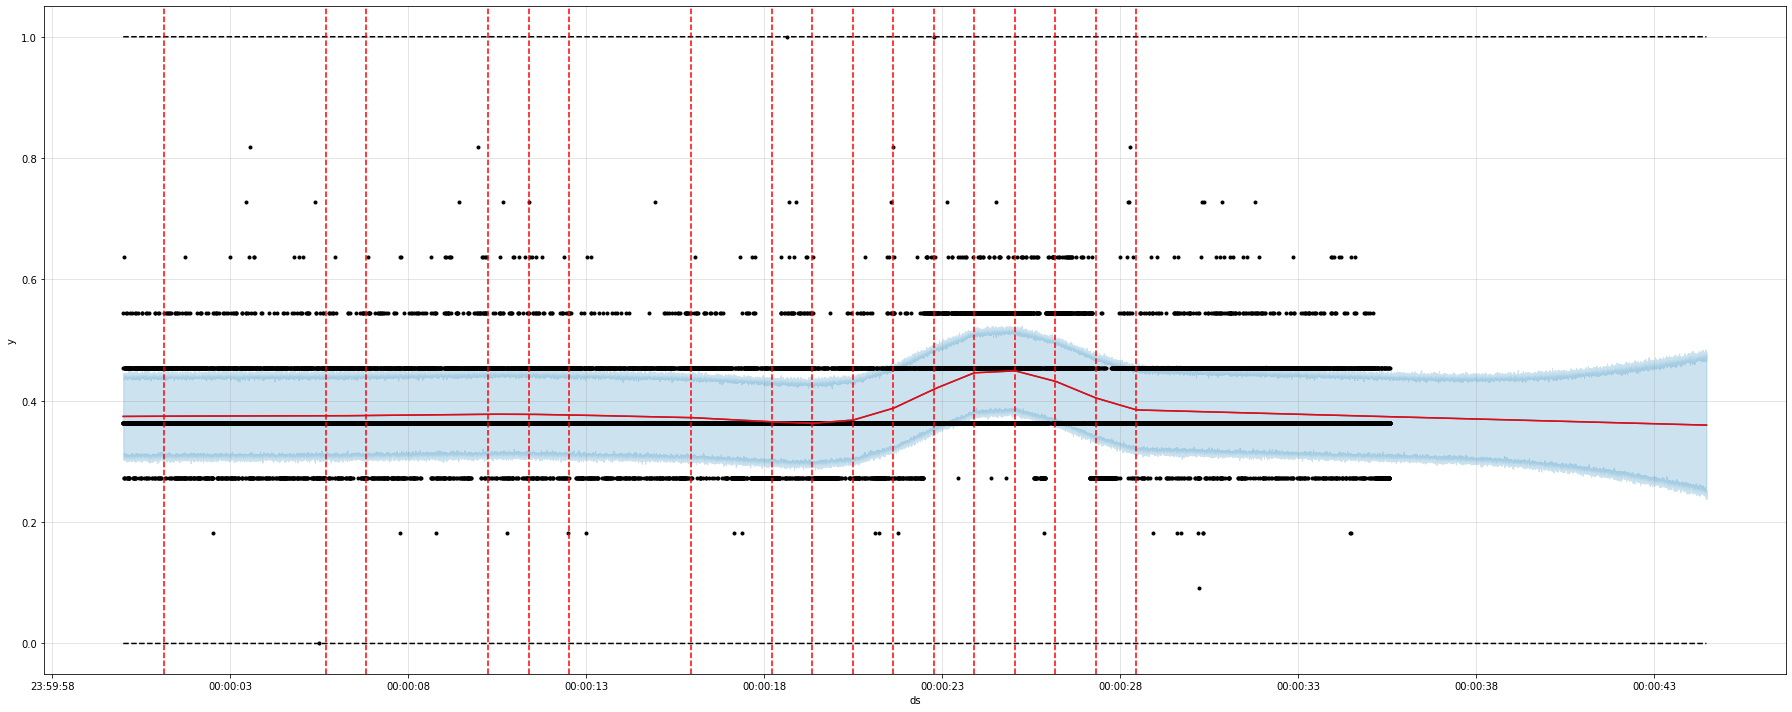

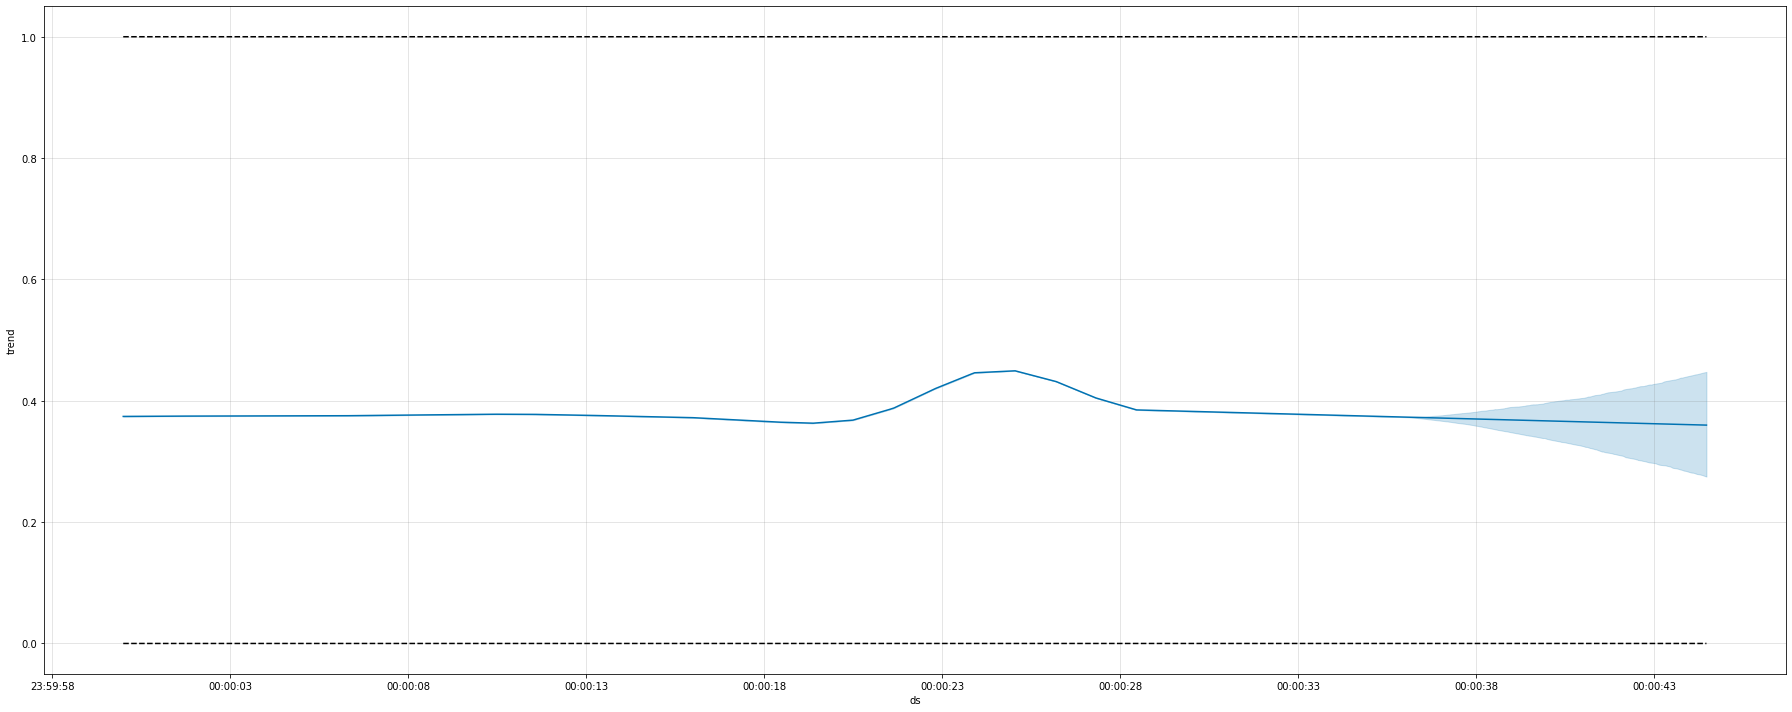

In [171]:
fig = model.plot(forecast,figsize=(25,10))
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig2 = model.plot_components(forecast,figsize=(25,10))
plt.show()

Para poder se avaliar a métrica da raíz do erro quadrático médio, escalonou-se também o dataset de teste, utilizando o escalonador gerado com o dataset de treino.

In [172]:
df_test['y'] = scaler.transform(df_test[['y']])
df_test.head()

ds         y  floor  cap
35580 2019-01-01 00:00:35.580  0.363636    -52  -36
35581 2019-01-01 00:00:35.581  0.363636    -55  -36
35582 2019-01-01 00:00:35.582  0.363636    -56  -37
35583 2019-01-01 00:00:35.583  0.363636    -50  -37
35584 2019-01-01 00:00:35.584  0.363636    -56  -37

Com base nos valores previstos e os valores reais, calculou-se o valor de RMSE (Raíz do Erro Quadrático Médio).

In [173]:
rmse = sqrt(mean_squared_error(df_test.iloc[:,1], forecast.iloc[-df_test.shape[0]:,-1]))
print('RMSE: %f' % rmse)

RMSE: 0.069486


In [174]:
df_train_show = df_train.copy()
df_train_show.index = pd.RangeIndex(0,df_train.shape[0]) # reseta index
df_test_show = df_test.copy()
df_test_show.index = pd.RangeIndex(df_train.shape[0],df_train.shape[0]+df_test.shape[0]) # reseta index

df_train_show['y'] = scaler.inverse_transform(df_train_show[['y']])
df_test_show['y'] = scaler.inverse_transform(df_test_show[['y']])

forecast_show = forecast.copy()
forecast_show['yhat'] = scaler.inverse_transform(forecast_show[['yhat']])

Por fim, comparou-se o a distribuição dos dados dos valores reais e previstos da série.

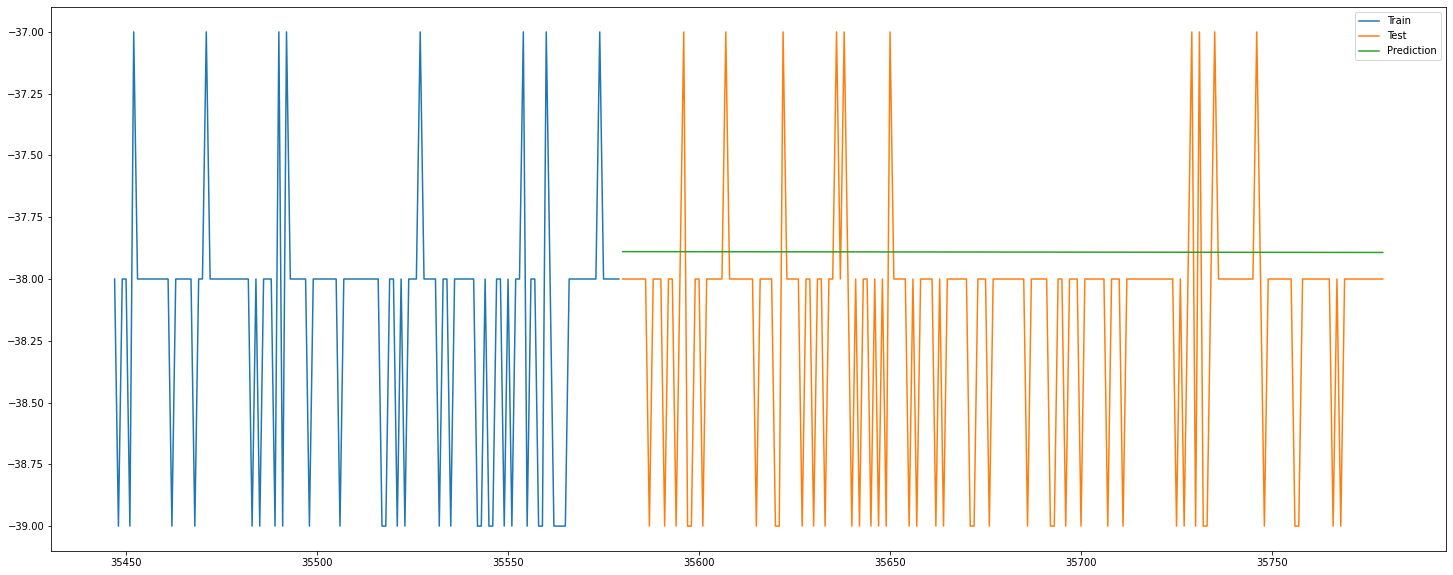

In [175]:
plt.figure(figsize=(25,10))

plt.plot(df_train_show.iloc[35447:,1])
plt.plot(df_test_show.iloc[:200,1])

plt.plot(forecast_show.iloc[df_test_show.index[0]:df_test_show.index[0]+200,-1])

plt.legend(['Train','Test','Prediction'])

plt.show()

##### *Prophet com crescimento logístico, cap de -35 e floor de -40, utilizado de maneira empirica através da observação da distribuição dos dados de VALIDATION*

Para o terceiro teste com modelo de crescimento logístico, valores fixos para cap e floor, de maneira empirica, com base na observação da tendência da distribuição dos valores de y(t).<br>
Para o dataset criado, mantiveram-se as colunas de VALIDATION, TIMESTAMP, MIN e MAX, sendo que eles foram renomeados para y, ds, floor e cap respectivamente.

In [176]:
df_Prophet = df_original.drop(['EPC','MEAN','COUNT'], axis=1)

df_Prophet = df_Prophet.rename(columns={'VALIDATION': 'y','TIMESTAMP':'ds','MIN':'floor','MAX':'cap'})
df_Prophet.head()

ds     y  floor  cap
0  1559288006669161 -38.0    -53  -37
1  1559288006411266 -38.0    -52  -36
2  1559288006208139 -36.0    -46  -35
3  1559288005894531 -38.0    -53  -36
4  1559288005639682 -38.0    -56  -36

Como haviam inconsistências no index do dataset, reiniciaram-se os valores, deixando assim o incremento contínuo.

In [177]:
df_Prophet.index = pd.RangeIndex(0,df_Prophet.shape[0])
df_Prophet

ds     y  floor  cap
0      1559288006669161 -38.0    -53  -37
1      1559288006411266 -38.0    -52  -36
2      1559288006208139 -36.0    -46  -35
3      1559288005894531 -38.0    -53  -36
4      1559288005639682 -38.0    -56  -36
...                 ...   ...    ...  ...
44470  1559310373087455 -36.0    -57  -35
44471  1559310373347245 -37.0    -57  -34
44472  1559310373608031 -37.0    -55  -34
44473  1559310373860986 -38.0    -57  -34
44474  1559310374120188 -38.0    -55  -34

[44475 rows x 4 columns]

Os valores da coluna ds foram sobrescritos com a série de tempo com incremento de um milissegundo criada.

In [178]:
df_Prophet['ds'] = time_index
df_Prophet.head()

ds     y  floor  cap
0 2019-01-01 00:00:00.000 -38.0    -53  -37
1 2019-01-01 00:00:00.001 -38.0    -52  -36
2 2019-01-01 00:00:00.002 -36.0    -46  -35
3 2019-01-01 00:00:00.003 -38.0    -53  -36
4 2019-01-01 00:00:00.004 -38.0    -56  -36

In [179]:
df_window = df_Prophet.iloc[min_period:max_period,:]
df_window

ds     y  floor  cap
0     2019-01-01 00:00:00.000 -38.0    -53  -37
1     2019-01-01 00:00:00.001 -38.0    -52  -36
2     2019-01-01 00:00:00.002 -36.0    -46  -35
3     2019-01-01 00:00:00.003 -38.0    -53  -36
4     2019-01-01 00:00:00.004 -38.0    -56  -36
...                       ...   ...    ...  ...
44470 2019-01-01 00:00:44.470 -36.0    -57  -35
44471 2019-01-01 00:00:44.471 -37.0    -57  -34
44472 2019-01-01 00:00:44.472 -37.0    -55  -34
44473 2019-01-01 00:00:44.473 -38.0    -57  -34
44474 2019-01-01 00:00:44.474 -38.0    -55  -34

[44475 rows x 4 columns]

Para se manter os parâmetros similares entre os modelos LSTM e Prophet, realizou-se a divisão do dataset entre treino e teste com a proporção de 80% e 20%, sem modo shuffle e com  semente aleatória 100.

In [180]:
df_train, df_test = train_test_split(df_window, test_size=0.2, shuffle=False, random_state=100)

print (df_train.shape, df_test.shape)

train_size = df_train.shape[0]
test_size = df_test.shape[0]

(35580, 4) (8895, 4)


Os valores de -35 e -40 foram adotados como cap e floor de maneira empirica, com base na observação na tendência dos valores de y(t).

In [181]:
df_train['cap'] = -35
df_train['floor'] = -40

Outra prática adotada para que as métricas de avaliação pudessem ser comparadas foi o escalonamento do dataset de treino com valor de 0 a 1 (mínimo e máximo), com escalonador treinado sendo utilizado posteriormente para o dataset de previsão e de teste.

In [182]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[['y']])
df_train['y'] = scaler.transform(df_train[['y']])

df_train.head()

ds         y  floor  cap
0 2019-01-01 00:00:00.000  0.363636    -40  -35
1 2019-01-01 00:00:00.001  0.363636    -40  -35
2 2019-01-01 00:00:00.002  0.545455    -40  -35
3 2019-01-01 00:00:00.003  0.363636    -40  -35
4 2019-01-01 00:00:00.004  0.363636    -40  -35

Para manter-se a proporcionalidade dos valores, os valores de cap e floor foram escalonados com o escalonador treinado com os valores de VALIDATION do dataset de treino.

In [183]:
df_train['cap'] = scaler.transform(df_train[['cap']])
df_train['floor'] = scaler.transform(df_train[['floor']])
df_train.head()

ds         y     floor       cap
0 2019-01-01 00:00:00.000  0.363636  0.181818  0.636364
1 2019-01-01 00:00:00.001  0.363636  0.181818  0.636364
2 2019-01-01 00:00:00.002  0.545455  0.181818  0.636364
3 2019-01-01 00:00:00.003  0.363636  0.181818  0.636364
4 2019-01-01 00:00:00.004  0.363636  0.181818  0.636364

In [184]:
model = Prophet(growth='logistic')
model.fit(df_train)
future = model.make_future_dataframe(periods=test_size, freq='ms')
future['cap'] = df_train['cap'].max()
future['floor'] = df_train['floor'].min()
future

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       cap     floor
0     2019-01-01 00:00:00.000  0.636364  0.181818
1     2019-01-01 00:00:00.001  0.636364  0.181818
2     2019-01-01 00:00:00.002  0.636364  0.181818
3     2019-01-01 00:00:00.003  0.636364  0.181818
4     2019-01-01 00:00:00.004  0.636364  0.181818
...                       ...       ...       ...
44470 2019-01-01 00:00:44.470  0.636364  0.181818
44471 2019-01-01 00:00:44.471  0.636364  0.181818
44472 2019-01-01 00:00:44.472  0.636364  0.181818
44473 2019-01-01 00:00:44.473  0.636364  0.181818
44474 2019-01-01 00:00:44.474  0.636364  0.181818

[44475 rows x 3 columns]

In [185]:
forecast = model.predict(future)

Após a realização da previsão dos dados futuros, gerou-se o gráfico com a apresentação dos resultados e o gráfico com os valores de treino mais a tendência gerada com seu intervalo de incerteza.<br>
No primeiro gráfico, pode-se observar a **linha sólida vermelha** como a tendência do modelo gerado, os **pontos pretos** distribuidos são os valores do dataset de treino original, as **linhas pontilhadas vermelhas verticais** são os pontos de mudança de tendência identificados e a **faixa azul clara** em torno da tendência são o intervalo de incerteza.<br>
No segundo gráfico, pode-se observar a linha de tendência gerada pelo modelo e o intervalo de incerteza da previsão futura gerada.

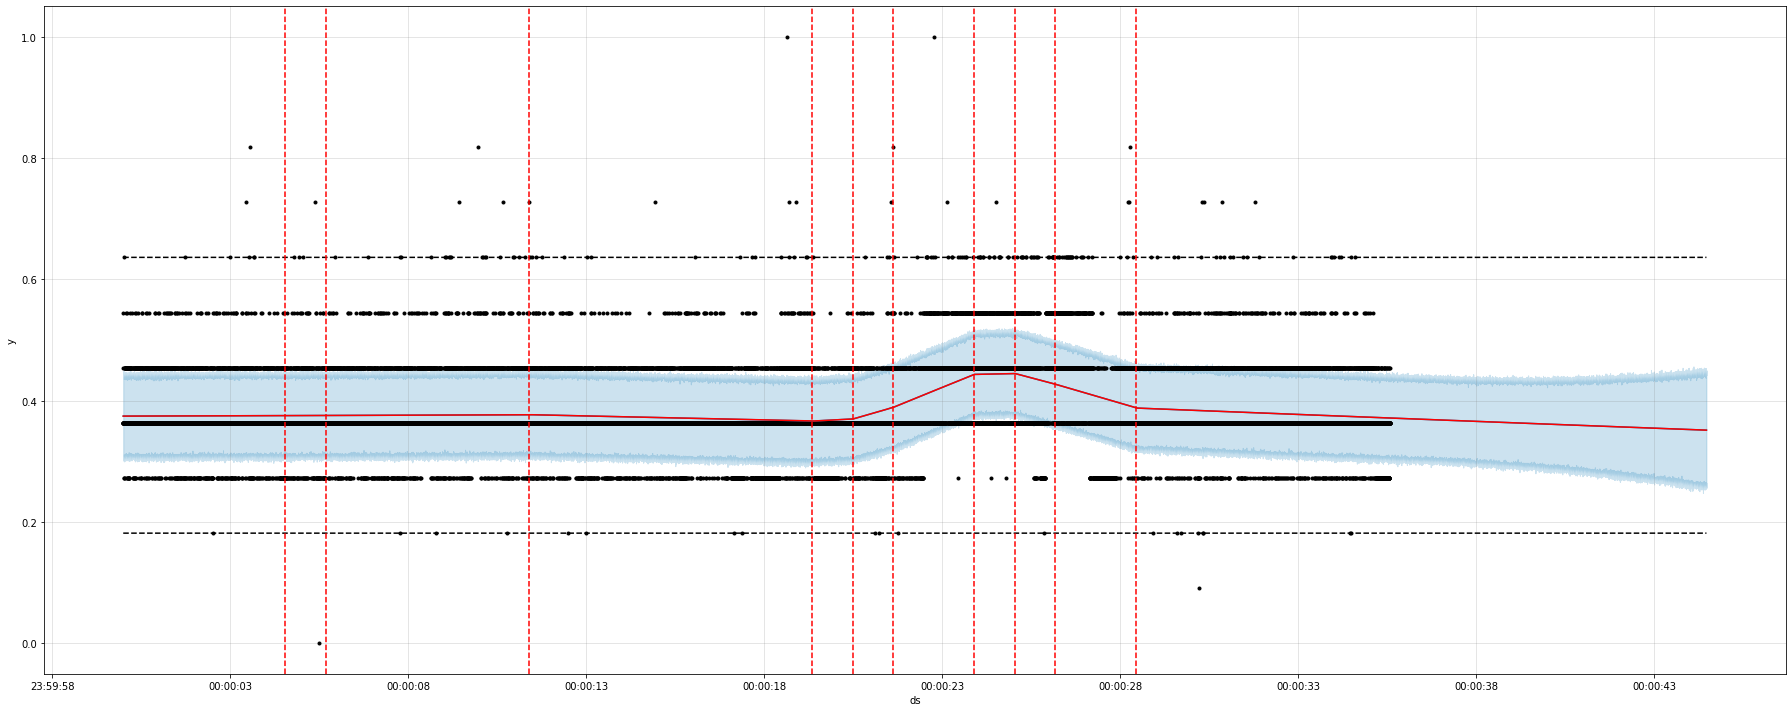

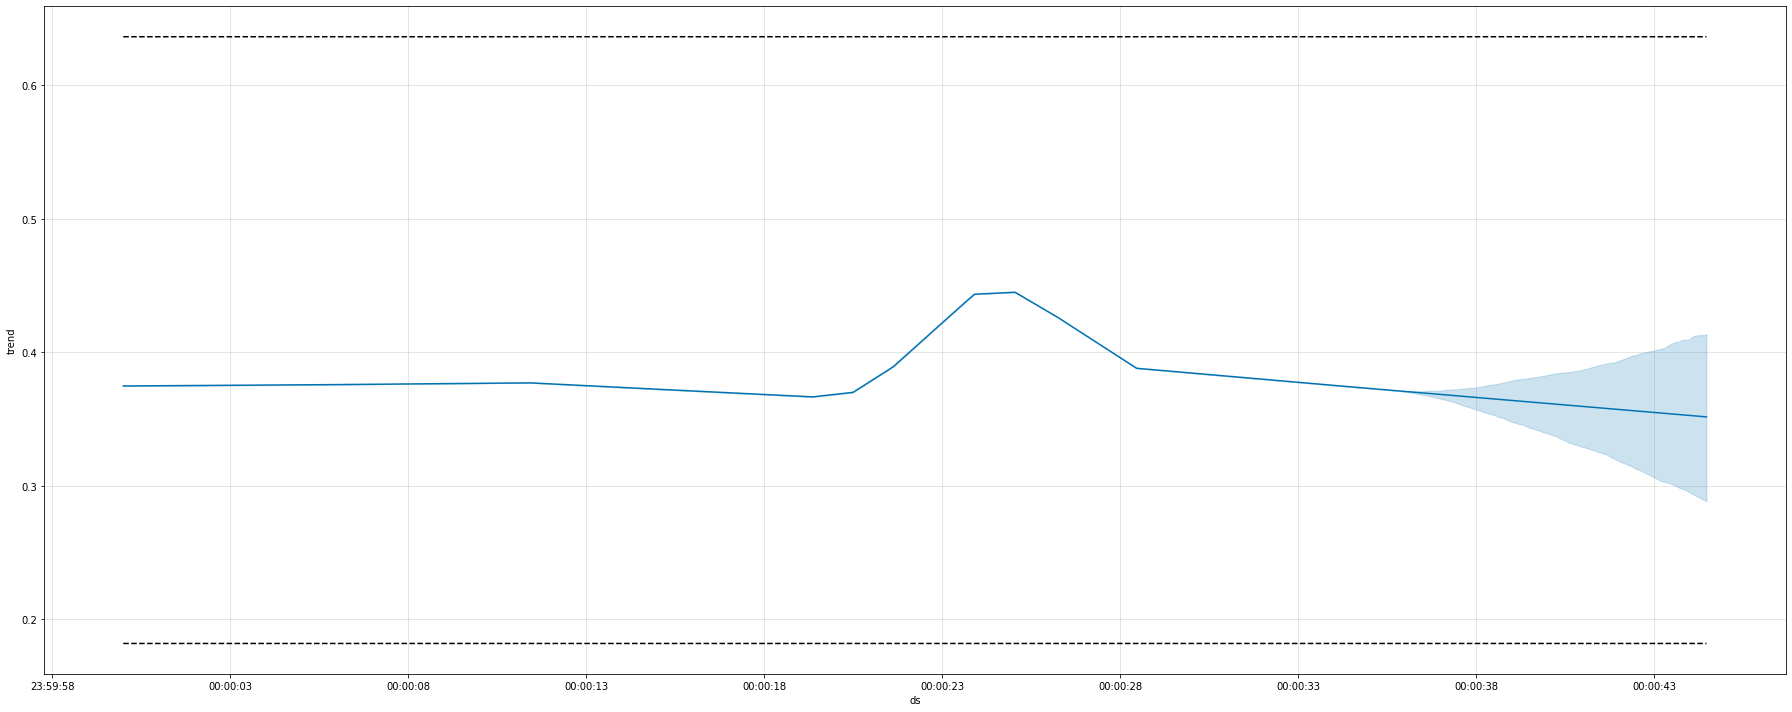

In [186]:
fig = model.plot(forecast,figsize=(25,10))
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig2 = model.plot_components(forecast,figsize=(25,10))
plt.show()

Para poder se avaliar a métrica da raíz do erro quadrático médio, escalonou-se também o dataset de teste, utilizando o escalonador gerado com o dataset de treino.

In [187]:
df_test['y'] = scaler.transform(df_test[['y']])
df_test.head()

ds         y  floor  cap
35580 2019-01-01 00:00:35.580  0.363636    -52  -36
35581 2019-01-01 00:00:35.581  0.363636    -55  -36
35582 2019-01-01 00:00:35.582  0.363636    -56  -37
35583 2019-01-01 00:00:35.583  0.363636    -50  -37
35584 2019-01-01 00:00:35.584  0.363636    -56  -37

Com base nos valores previstos e os valores reais, calculou-se o valor de RMSE (Raíz do Erro Quadrático Médio).

In [188]:
rmse = sqrt(mean_squared_error(df_test.iloc[:,1], forecast.iloc[-df_test.shape[0]:,-1]))
print('RMSE: %f' % rmse)

RMSE: 0.071174


Por fim, comparou-se o a distribuição dos dados dos valores reais e previstos da série.

In [189]:
df_train_show = df_train.copy()
df_train_show.index = pd.RangeIndex(0,df_train.shape[0]) # reseta index
df_test_show = df_test.copy()
df_test_show.index = pd.RangeIndex(df_train.shape[0],df_train.shape[0]+df_test.shape[0]) # reseta index

df_train_show['y'] = scaler.inverse_transform(df_train_show[['y']])
df_test_show['y'] = scaler.inverse_transform(df_test_show[['y']])

forecast_show = forecast.copy()
forecast_show['yhat'] = scaler.inverse_transform(forecast_show[['yhat']])

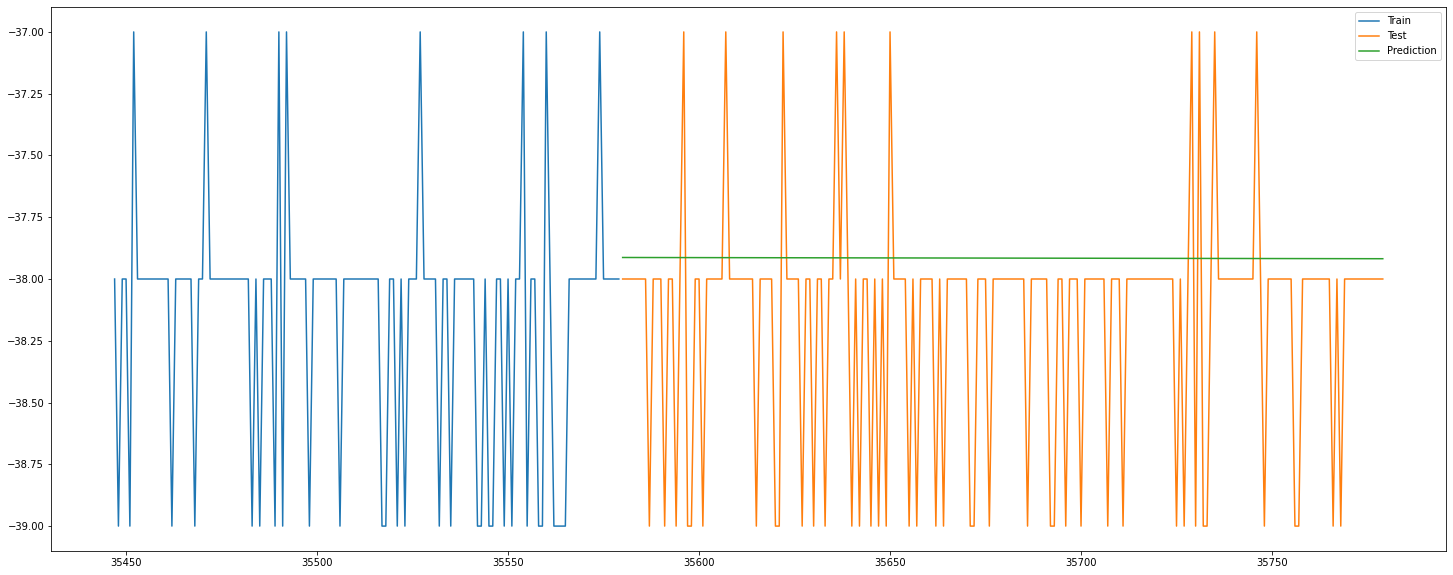

In [192]:
plt.figure(figsize=(25,10))

plt.plot(df_train_show.iloc[35447:,1])
plt.plot(df_test_show.iloc[:200,1])
plt.plot(forecast_show.iloc[df_test_show.index[0]:df_test_show.index[0]+200,-1])

plt.legend(['Train','Test','Prediction'])

plt.show()

#### Conclusão Prophet

Ao se observar os resultados obtidos com nos quatro cenários apresentados para o Prophet, pode-se observar que todos tiveram uma tendência similar e um valor de raíz do erro quadrático médio próximos.<br>
O modelo linear apresentou-se bastante vantajoso, devido à sua maneira extremamente fácil de implementar, porém observou-se também que neste caso, houve uma variação muito grande no intervalo de confiança da previsão.<br>
Dentre todos os cenários apresentados, o que apresentou resultados mais satisfatório foi o cenário de crescimento logístico utilizando como limite de saturação superior (cap) e de limite de saturação inferior (floor) o máximo valor de RSSI medido dentre as tags e o mínimo valor de RSSI medido dentre as tags. Este cenário, apesar de ter demonstrado um valor de raíz do erro quadratico médio ligeiramente inferior ao do cenário com crescimento linerar, apresentou resultado de raíz do erro quadratico médio melhor dentre os três cenários de crescimento logístico e o melhor resultado de intervalo de confiança dos valores previstos dentre todos os cenários avaliados.<br>

# Conclusão

Usar Machine Learning para auxiliar no monitoramento preditivo das leituras das TAGs de RFID em um processo produtivo se demonstrou promissor.
Em todos os modelos e variações testadas o erro ficou menor que 1db de potência, o que ainda garante um ótima qualidade de validação da TAG no processo produtivo o que resultaria numa TAG válida.

Com os modelos escolhidos não foi possível ser conclusívo na melhor opção ja que ambos tiveram a mesma performance em relação à métrica de treinamento.

Como próximos passos, os testes com outros modelos seria um opção, como por exemplo o ARIMA, também muito famoso e já oferecido comercialmente na empresa que foi fruto desse estudo. Outra meio de explorar ainda mais esse problema é usar outros logs que tenham mais variações em relação aos valores de validação ou um log com mais dados. A dificuldade de conseguí-los seria alta dado a confidencialidade da informação.

Por fim, esse estudo serviu para um grande aprofundamento do assunto e prática das matérias de Machine Learning aprendidas e isso não seria possível se não escolhessemos um dataset real de uma empresa privada.


# Referências

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ <br>
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ <br>
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ <br>
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ <br>
https://cocoa.ethz.ch/downloads/2015/02/1795_%5BKTF14a%5D%20Classification%20Models%20for%20RFID-based%20Real%20Time%20Detection.pdf <br>
https://hal.archives-ouvertes.fr/hal-01744328/file/ertek_chi_zhang_2017_RFID.pdf <br>
https://arxiv.org/ftp/arxiv/papers/1708/1708.03854.pdf <br>
https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d <br>
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ <br>
https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/ <br>
https://medium.com/data-hackers/s%C3%A9ries-temporais-com-machine-learning-parte-2-75e161b7d78e <br>
http://www.portalaction.com.br/series-temporais/14-testes-de-estacionariedade <br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
http://deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/ <br>
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/ <br>
https://facebook.github.io/prophet/docs/non-daily_data.html <br>
https://facebook.github.io/prophet/docs/trend_changepoints.html <br>
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/ <br>
https://facebook.github.io/prophet/docs/quick_start.html#python-api <br>
https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66 <br>
https://facebook.github.io/prophet/docs/trend_changepoints.html <br>
https://facebook.github.io/prophet/docs/saturating_forecasts.html <br>
https://rdrr.io/cran/prophet/man/make_future_dataframe.html <br>
https://cran.r-project.org/web/packages/prophet/prophet.pdf <br>
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3 <br>
https://towardsdatascience.com/forecasting-with-python-and-tableau-dd37a218a1e5 <br>
https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66 <br>
https://github.com/raffg/prophet_forecasting/blob/master/prophet_airpassengers.ipynb <br>
https://peerj.com/preprints/3190.pdf <br>
https://medium.com/@christopher.shayan/experimenting-on-facebook-prophet-eb44818278da <br>
https://facebook.github.io/prophet/docs/diagnostics.html <br>
https://towardsdatascience.com/demand-forecasting-using-fb-prophet-e3d1444b9dd8<br>
https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511<br>
https://medium.com/analytics-vidhya/how-does-prophet-work-44addaab6148<br>
https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511<br>
http://www.producao.ufrgs.br/arquivos/disciplinas/119_teq6_st_decomposicao.pdf<br>
http://www.stat.yale.edu/~lc436/papers/Harvey_Peters1990.pdf<br>
